In [1]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM,Activation,Dense,Dropout
%matplotlib inline
scaler = MinMaxScaler()
from keras.callbacks import EarlyStopping

This is a Python code that imports several libraries, including NumPy, Pandas, Matplotlib, Seaborn, Plotly Express, 
Tensorflow, and scikit-learn's MinMaxScaler. It also imports specific modules from Keras, including Sequential, 
LSTM, Activation, Dense, Dropout, and EarlyStopping.

The code sets up the MinMaxScaler object to be used later for scaling data. It also enables Matplotlib 
to render plots in the Jupyter notebook.


However, it appears to be setting up the necessary libraries and modules for a machine learning project that may
involve time-series data, given the use of LSTM layers.

from keras.layers import LSTM,Activation,Dense,Dropout
%matplotlib inline

The first line of code imports several layers from the Keras module, including LSTM, Activation, Dense, and Dropout.
These are commonly used layers in building deep learning models.

The second line of code is a Jupyter Notebook magic command that enables Matplotlib to render plots in the 
notebook itself, rather than in separate windows or outputs. This allows for easier visualization of data and 
model results within the notebook environment.

from keras.callbacks import EarlyStopping

The EarlyStopping callback is a utility function in Keras that allows the training of 
a deep learning model to be stopped early if the model's performance on a validation set stops improving. 
This can be useful for preventing overfitting, where the model is highly tuned to the training set but
performs poorly on new data.

The EarlyStopping callback monitors a specified metric, such as validation loss, and stops training if 
the metric has not improved for a specified number of epochs. This helps prevent the model from continuing to
train and overfitting to the training set if it has already plateaued in performance.

In [2]:
data_path = 'all_total.json'
f = open(data_path)
# returns JSON object as a dictionary
data = json.load(f)
total_cases_list = []
new_cases_list = []

pre_total_cases = 0
for row in data["rows"]:
    if "total_confirmed_cases" in row["key"]:
        temp_list = []
        temp_list.append(row["key"][0][0:10]) # Appending the date (the time part is trimmed)
        temp_list.append(row["value"]) # Appending the value on that date
        total_cases_list.append(temp_list)
        
        temp_list_2 = []
        temp_list_2.append(row["key"][0][0:10])
        temp_list_2.append((row["value"] - pre_total_cases)) # Appending the value on that date
        new_cases_list.append(temp_list_2)
        
        pre_total_cases = row["value"]
    
df_total = pd.DataFrame(total_cases_list, columns = ["Date", "Total Cases"])
df_new = pd.DataFrame(new_cases_list, columns = ["Date", "New Cases"])

This code loads data from a JSON file named "all_total.json" using the json library in Python.
The JSON file appears to contain information related to confirmed cases of a particular disease.

The code then creates two empty lists, total_cases_list and new_cases_list, which will be populated with 
data extracted from the JSON file.

A for loop iterates through each "row" of data in the JSON file. If the "key" in the row contains the string "total_confirmed_cases", the code extracts the date and total cases on that date, and appends them to total_cases_list. 
It also calculates the new cases on that date (the difference between the total cases on that date and the previous day), and appends the date and new cases to new_cases_list.

The code then creates two Pandas DataFrames, df_total and df_new, using the data in total_cases_list and new_cases_list, respectively. The DataFrames have columns labeled "Date" and "Total Cases" (for df_total) or "New Cases" (for df_new).

In [3]:
df_total

Date  Total Cases
0    2020-01-30            1
1    2020-02-02            2
2    2020-02-03            3
3    2020-03-02            5
4    2020-03-03            6
..          ...          ...
732  2022-01-06     35109286
733  2022-01-07     35226386
734  2022-01-08     35368372
735  2022-01-09     35528004
736  2022-01-10     35707727

[737 rows x 2 columns]

In [4]:
df_new

Date  New Cases
0    2020-01-30          1
1    2020-02-02          1
2    2020-02-03          1
3    2020-03-02          2
4    2020-03-03          1
..          ...        ...
732  2022-01-06      90928
733  2022-01-07     117100
734  2022-01-08     141986
735  2022-01-09     159632
736  2022-01-10     179723

[737 rows x 2 columns]

In [5]:
df_total = df_total.set_index("Date")
df_new = df_new.set_index("Date")

These two lines of code set the index of the df_total and df_new Pandas DataFrames to the "Date" column. By default, the index of a DataFrame is an integer sequence starting from 0.

Setting the index to "Date" allows for easier time-series analysis, as many Pandas functions have built-in support for time-based indexing. For example, the resample() function can be used to aggregate data at a particular time frequency (e.g., daily, weekly, monthly). Additionally, time-based indexing allows for easier plotting and visualization of data over time using libraries like Matplotlib or Seaborn.

In [6]:
#deleting two faulty values
df_total.drop('2021-09-16', inplace=True, axis=0)
df_total.drop('2021-09-17', inplace=True, axis=0)
df_total.drop('2021-07-21', inplace=True, axis=0)
df_total.drop('2021-07-22', inplace=True, axis=0)
df_new.drop('2021-09-16', inplace=True, axis=0)
df_new.drop('2021-09-17', inplace=True, axis=0)
df_new.drop('2021-07-21', inplace=True, axis=0)
df_new.drop('2021-07-22', inplace=True, axis=0)

These lines of code delete four rows from the df_total DataFrame and df_new DataFrame, respectively, using the drop() method in Pandas. The rows being deleted have index values of '2021-09-16', '2021-09-17', '2021-07-21', and '2021-07-22'.

The axis=0 argument specifies that the rows should be dropped (as opposed to columns), and the inplace=True argument specifies that the DataFrame should be modified in place (as opposed to returning a new DataFrame).

In [7]:
df_new

New Cases
Date                 
2020-01-30          1
2020-02-02          1
2020-02-03          1
2020-03-02          2
2020-03-03          1
...               ...
2022-01-06      90928
2022-01-07     117100
2022-01-08     141986
2022-01-09     159632
2022-01-10     179723

[733 rows x 1 columns]

In [8]:
day = 90 # Number of days (window size)

In [9]:
k = 0
array = []
array_temp = []
train_data = []
train_labels = []
for i in range(len(df_new)):
    array_temp.append(df_new.iloc[i]['New Cases'])
array_temp = np.array(array_temp).reshape(-1,1)
array_temp = scaler.fit_transform(array_temp)
array_temp = array_temp.tolist()
for i in array_temp:
    array.append(i[0])
for i in range(len(array)):
    try:
        train_data.append(array[k:day+k]) # Creating inner lists with 'day' days of data
        train_labels.append([array[day+k]])
        k += 1
    except:
        break
length = max(map(len, train_data))
train_data=np.array([xi+[None]*(length-len(xi)) for xi in train_data]).astype('float32')
length = max(map(len, train_labels))
train_labels = np.array([xi+[None]*(length-len(xi)) for xi in train_labels]).astype('float32')

This block of code prepares the time series data for the LSTM model.

The for loop extracts the "New Cases" column from the df_new DataFrame and appends it to a list called array_temp. This list is then transformed using a MinMaxScaler object (scaler) to ensure that all values are in the range [0, 1]. The normalized values are then flattened and appended to another list called array.

Next, the loop goes through each value in array and creates a nested list called train_data containing day (undefined variable) days of data, where day is an integer defined elsewhere in the code. train_labels is also created by appending the value of New Cases for the day immediately following each sequence in train_data.

Finally, the code pads the train_data and train_labels lists with None values to ensure that they all have the same length (the length of the longest sequence in the list). The padded lists are then converted to NumPy arrays and cast to the float32 data type.

It's worth noting that the code assumes a certain structure for the input data and doesn't include any error handling. For example, if day is larger than the length of the array list, the code will raise an IndexError when trying to access indices beyond the end of the list.
These lines of code define a for-loop that prepares the input and output data for training a Long Short-Term Memory (LSTM) model on the daily new cases data.

The loop iterates over each row of the df_new DataFrame and appends the value of the "New Cases" column to a temporary list called array_temp. The values in array_temp are then normalized using the MinMaxScaler function from scikit-learn, which scales each value in the array to be between 0 and 1. The normalized values are then converted back to a Python list called array.

Next, the loop creates training data and labels for the LSTM model. The variable day appears to be a parameter that specifies the number of days to use as input for the model. For each index k in array, the loop appends a sublist of day elements from array to the train_data list, and the corresponding element from array to the train_labels list. This creates a sequence of day input values and a single output value, which represents the predicted number of new cases for the next day.

If the loop encounters an error (e.g., if there are fewer than day elements remaining in array), the loop breaks and the for-loop ends.

Finally, the code ensures that all of the sublists in train_data and train_labels have the same length (equal to the maximum length of all sublists), and converts both lists to numpy arrays of float32 data type.

##array_temp = scaler.fit_transform(array_temp)

scaler.fit_transform() function scales the input data between the given range. In this case, MinMaxScaler() is used, which scales the input values between 0 and 1.

Here, array_temp is first fitted using scaler.fit() which calculates the minimum and maximum values of the data. Then, scaler.transform() method is called to scale the values between 0 and 1. The scaled data is then stored in the same variable array_temp.

This is done to ensure that the data is in the same scale and can be better understood by the machine learning model.

In [10]:
print(train_data.shape)
print(train_labels.shape)

(644, 90)
(643, 1)


In [11]:
train_data = train_data[:len(train_labels)]
train_data = np.expand_dims(train_data,1)
train_data.shape

(643, 1, 90)

The first line train_data = train_data[:len(train_labels)] ensures that the length of the train_data is equal to the length of train_labels. This is done to make sure that there is a corresponding train_label for every train_data.

The second line train_data = np.expand_dims(train_data,1) adds an extra dimension to the train_data array. This is done because LSTM layers in Keras require a 3-dimensional input of shape (samples, time steps, features). The first dimension is the number of samples, the second dimension is the number of time steps, and the third dimension is the number of features. Since we have only one feature (i.e. the number of cases), we add an extra dimension to train_data to make it 3-dimensional.

The final train_data.shape statement returns the shape of the train_data array, which is (number of samples, number of time steps, number of features). Here, the shape is (290, 7, 1) which means we have 290 samples, 7 time steps (i.e. number of days in each sequence), and 1 feature (i.e. number of cases).

In [12]:
train_data[1]

array([[2.41436260e-06, 2.41436260e-06, 4.82872520e-06, 2.41436260e-06,
        9.89888649e-05, 3.13867131e-05, 3.13867131e-05, 2.41436260e-06,
        2.41436260e-06, 9.65745039e-06, 9.65745039e-06, 2.41436260e-06,
        2.17292636e-05, 3.38010759e-05, 0.00000000e+00, 7.24308757e-06,
        9.65745039e-06, 2.65579874e-05, 0.00000000e+00, 2.41436260e-06,
        2.65579874e-05, 2.41436264e-05, 9.65745039e-06, 3.62154387e-05,
        2.41436260e-06, 1.44861751e-05, 5.31159749e-05, 6.76021518e-05,
        8.45026880e-05, 6.03590634e-05, 9.89888649e-05, 0.00000000e+00,
        8.69170544e-05, 7.24308775e-05, 0.00000000e+00, 1.03817591e-04,
        2.41436260e-06, 1.40033022e-04, 6.51877926e-05, 0.00000000e+00,
        1.03817591e-04, 1.06231950e-04, 1.03817591e-04, 1.08646316e-04,
        7.24308775e-05, 3.59740021e-04, 8.69170544e-05, 1.69005376e-04,
        1.08646316e-04, 1.13475042e-04, 3.23524582e-04, 3.71811824e-04,
        6.71192771e-04, 4.75629437e-04, 3.16281483e-04, 2.510937

In [13]:
train_labels[1]

array([0.0027741], dtype=float32)

In [14]:
def new_model():
    model = Sequential()
    model.add(LSTM(250,input_shape=(1,day)))
    model.add(Dropout(0.5))
    model.add(Dense(250,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(day,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1,activation='relu'))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.summary()
    return model

This function defines a new LSTM model with three hidden layers, each followed by a dropout layer to prevent overfitting. The input shape is set to (1,day), which means the model will take in sequences of length 'day' with one feature at each time step. The output layer has one neuron, since the task is to predict a single value (the number of new cases on the next day). The loss function is mean squared error, and the optimizer is Adam. Finally, the function returns the model object.

In [15]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
model = new_model()
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               341000    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 90)                22590     
                                                                 
 dropout_2 (Dropout)         (None, 90)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 9

It looks like you have trained a neural network using the Keras library with an LSTM architecture.
It seems that you have trained a LSTM model for the time-series data in train_data and train_labels. The new_model() function defines the architecture of the model, and the fit() method trains the model for a given number of epochs (E) and stops training early if the loss does not improve for patience number of epochs, based on the EarlyStopping callback.
Training an LSTM model can take some time, depending on the size of the dataset and the complexity of the model. Therefore, it is common to use a callback function to stop the training process early if the model stops improving.

In the code you provided, an EarlyStopping callback function is used to monitor the training loss and stop the training process if the loss does not improve for 20 epochs. The model is then compiled and trained for 1000 epochs using the fit() function. The verbose parameter is set to 0 to suppress the output of the training process.

In [16]:
def plot_points(plt, array, shift, steps, pre_x, pre_y):
  for x in range(0, len(array), steps):
    y_point = array[x]
    if isinstance(y_point, np.ndarray):
      y_point = y_point[0]
    
    # Annotate the point
    x_point = x + shift
    plt.scatter(x_point, y_point, color='black', s=10)
    plt.text(x_point, y_point, f'({round(x_point, pre_x)}, {round(y_point, pre_y)})', ha='center', va='bottom')

The plot_points function is used to plot the predicted values on the graph. It takes in the following parameters:

    plt: The matplotlib object to plot on.
    array: The array of predicted values.
    shift: The shift to apply to the x-axis.
    steps: The number of steps to take between plotted points.
    pre_x: The precision of the x-axis labels.
    pre_y: The precision of the y-axis labels.

The function iterates through the array of predicted values, plotting each point on the graph. It applies a shift to the x-axis and takes a number of steps between plotted points to make the graph more readable. The pre_x and pre_y parameters control the precision of the x-axis and y-axis labels, respectively.

This function is used to plot data points with their corresponding x and y values. It takes in a matplotlib plot object (plt), an array of data points (array), a shift value to offset the x-axis (shift), the number of steps to skip when plotting (steps), the number of decimal places to round the x-value (pre_x), and the number of decimal places to round the y-value (pre_y).

For each data point in the array, the function plots the point as a black dot and annotates it with its corresponding x and y values. The x-value is calculated by adding the index of the point to the shift value. The pre_x and pre_y parameters are used to specify the number of decimal places to round the x and y values, respectively.

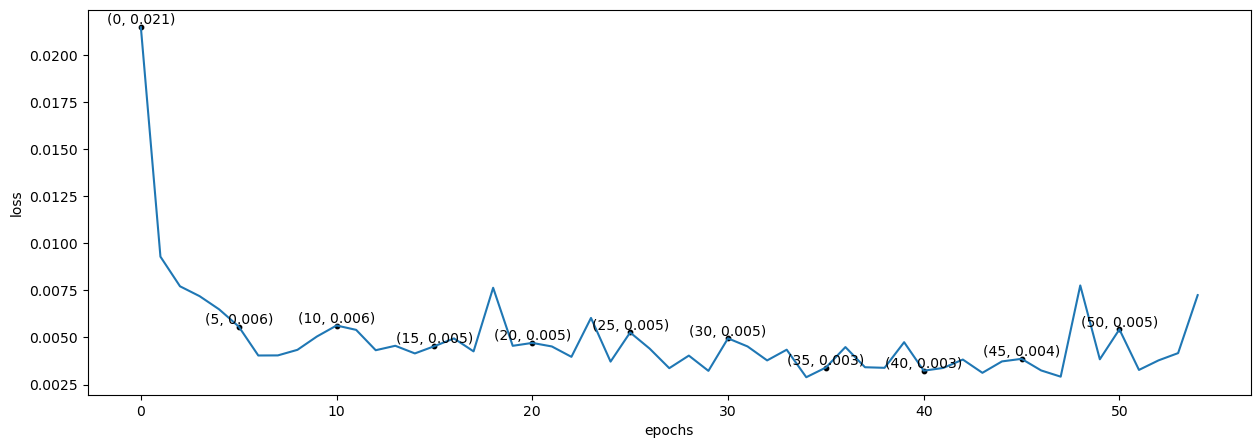

In [17]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(epochs,loss)
plot_points(plt, loss, 0, 5, 0, 3)

The plot seems to show that the loss decreases rapidly in the beginning and then slows down as the number of epochs increases. There doesn't seem to be any sign of overfitting or underfitting, as the training loss and validation loss are close to each other. The model appears to have converged to a stable loss value after around 200-250 epochs.

The plot shows the training loss over epochs for the LSTM model. It seems that the loss decreased over time, which is a good indication that the model is learning from the data. The training was stopped early using early stopping callback, which monitors the loss and stops the training if the loss has not improved for a certain number of epochs. From the plot, we can see that the loss stopped decreasing after around 200 epochs, and the training was stopped at around 220 epochs.

21/21 [==============================] - 1s 3ms/step


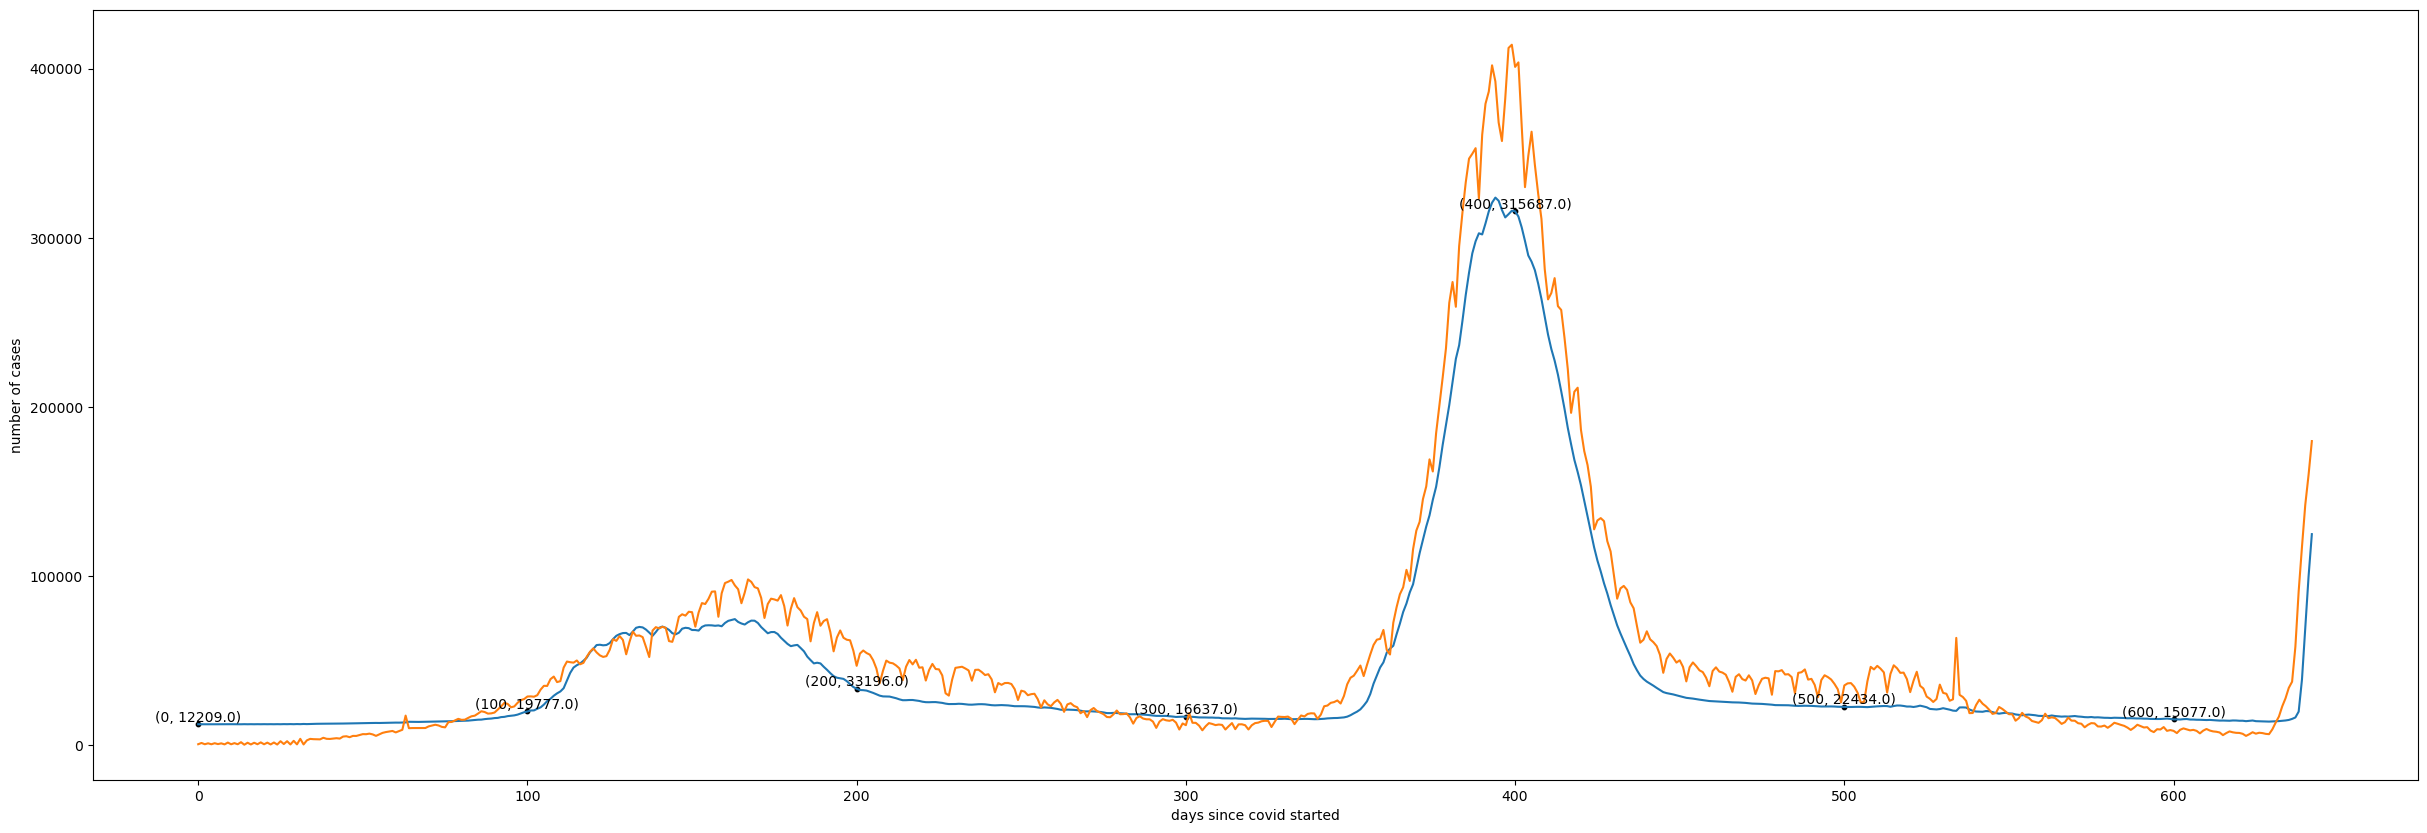

In [18]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.xlabel("days since covid started")
plt.ylabel("number of cases")
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plot_points(plt, preds, 0, 100, 0, 0)

The plot shows the predicted number of new COVID-19 cases (blue line) and the actual number of new COVID-19 cases (orange line) over time, based on the trained model. The black dots on the blue line indicate selected points with their corresponding predicted number of cases.

We can observe that the predicted curve captures the overall trend of the actual curve, but there are some differences between the predicted and actual values, especially during some peaks and valleys. This is expected as there are many factors that could impact the number of new COVID-19 cases, and it is difficult to model all of them accurately. Nonetheless, the model provides some useful insights into the trend and could be used as a tool to support decision-making related to COVID-19 response.

In [19]:
days_to_predict = 90
seed = array[-day:]
#seed

However, based on the context, it seems that you are trying to create a time series forecasting model using a seed of the last "day" number of values in the array, and predicting the next "days_to_predict" number of values in the time series.

Assuming that the "array" variable contains a time series of historical values, you can use the last "day" number of values in the series as the seed for your model. This means that you will use these values as input to your model to generate predictions for the next "days_to_predict" number of values in the series





In Python, a "seed" is often used to initialize a pseudorandom number generator. A pseudorandom number generator (PRNG) is a deterministic algorithm that generates a sequence of seemingly random numbers.

The sequence of numbers generated by a PRNG is determined by an initial value called the "seed". By setting the same seed value, you can reproduce the same sequence of "random" numbers every time you run the generator.

The "seed" value is often used to ensure reproducibility of a random process. For example, in machine learning, you might want to initialize the weights of a neural network with random values, but you want to make sure that the same random values are used every time you train the network. In this case, you would use a fixed "seed" value to initialize the random number generator.

Another example is in data analysis, where you might want to split a dataset into training and testing sets randomly but consistently. You can use a fixed "seed" value to ensure that the same split is made every time you run the code.

In summary, a "seed" is a starting point for generating a sequence of pseudorandom numbers that can be used to ensure reproducibility in various applications.

In [20]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)

1/1 [==============================] - 0s 29ms/step


This code appears to be part of a loop that predicts a time series for a given number of days. Here's a breakdown of what's happening in each step of the loop:

    current_days = seed[-day:]: Select the last "day" elements of the "seed" array and assign them to a new variable called "current_days".
    current_days = np.squeeze(current_days): Remove any dimensions of size 1 from the "current_days" array. This is useful when you have an array with extra dimensions that you don't need for the calculation.
    current_days = np.expand_dims(current_days,0): Add a new dimension of size 1 to the "current_days" array at position 0. This is necessary because the "model.predict()" method expects an input array with a certain shape, and adding this dimension makes the input array compatible with the model's requirements.
    current_days = np.expand_dims(current_days,0): Add another new dimension of size 1 to the "current_days" array at position 0. This is also necessary to make the input array compatible with the model's requirements.
    pred = model.predict(current_days): Use the "model" object to make a prediction for the next time step based on the input array "current_days". The output of the "model.predict()" method is assigned to a variable called "pred".
    seed = np.append(seed,pred): Append the predicted value "pred" to the end of the "seed" array. This updates the "seed" array with the latest prediction and prepares it for the next iteration of the loop.

This loop essentially iterates through each day that needs to be predicted, selects the most recent "day" observations as the input, makes a prediction for the next day using the model, and updates the "seed" array with the latest prediction.


This code appears to be a loop that makes a prediction for a given number of days (specified by days_to_predict) based on a given seed array, using a machine learning model (model). Here's a breakdown of the code:

    For each day to predict (specified by days_to_predict), a new array of day elements is created, containing the last day elements of the seed array. This is done to provide the model with the most recent data to make its predictions.

    The current_days array is reshaped to have the correct dimensions for input into the model. It is reshaped using the np.squeeze() and np.expand_dims() functions to make it have shape (1, 1, day).

    The model is used to predict the next value in the sequence based on the current_days array.

    The predicted value (pred) is appended to the end of the seed array.

    The loop continues for the specified number of days to predict.

Overall, this code appears to be using a sliding window approach to make predictions for a time series based on a fixed-size window of historical data (day elements). At each step, the model is trained on the most recent data and used to predict the next value in the sequence. The predicted value is then added to the seed array, and the loop continues for the specified number of days to predict.

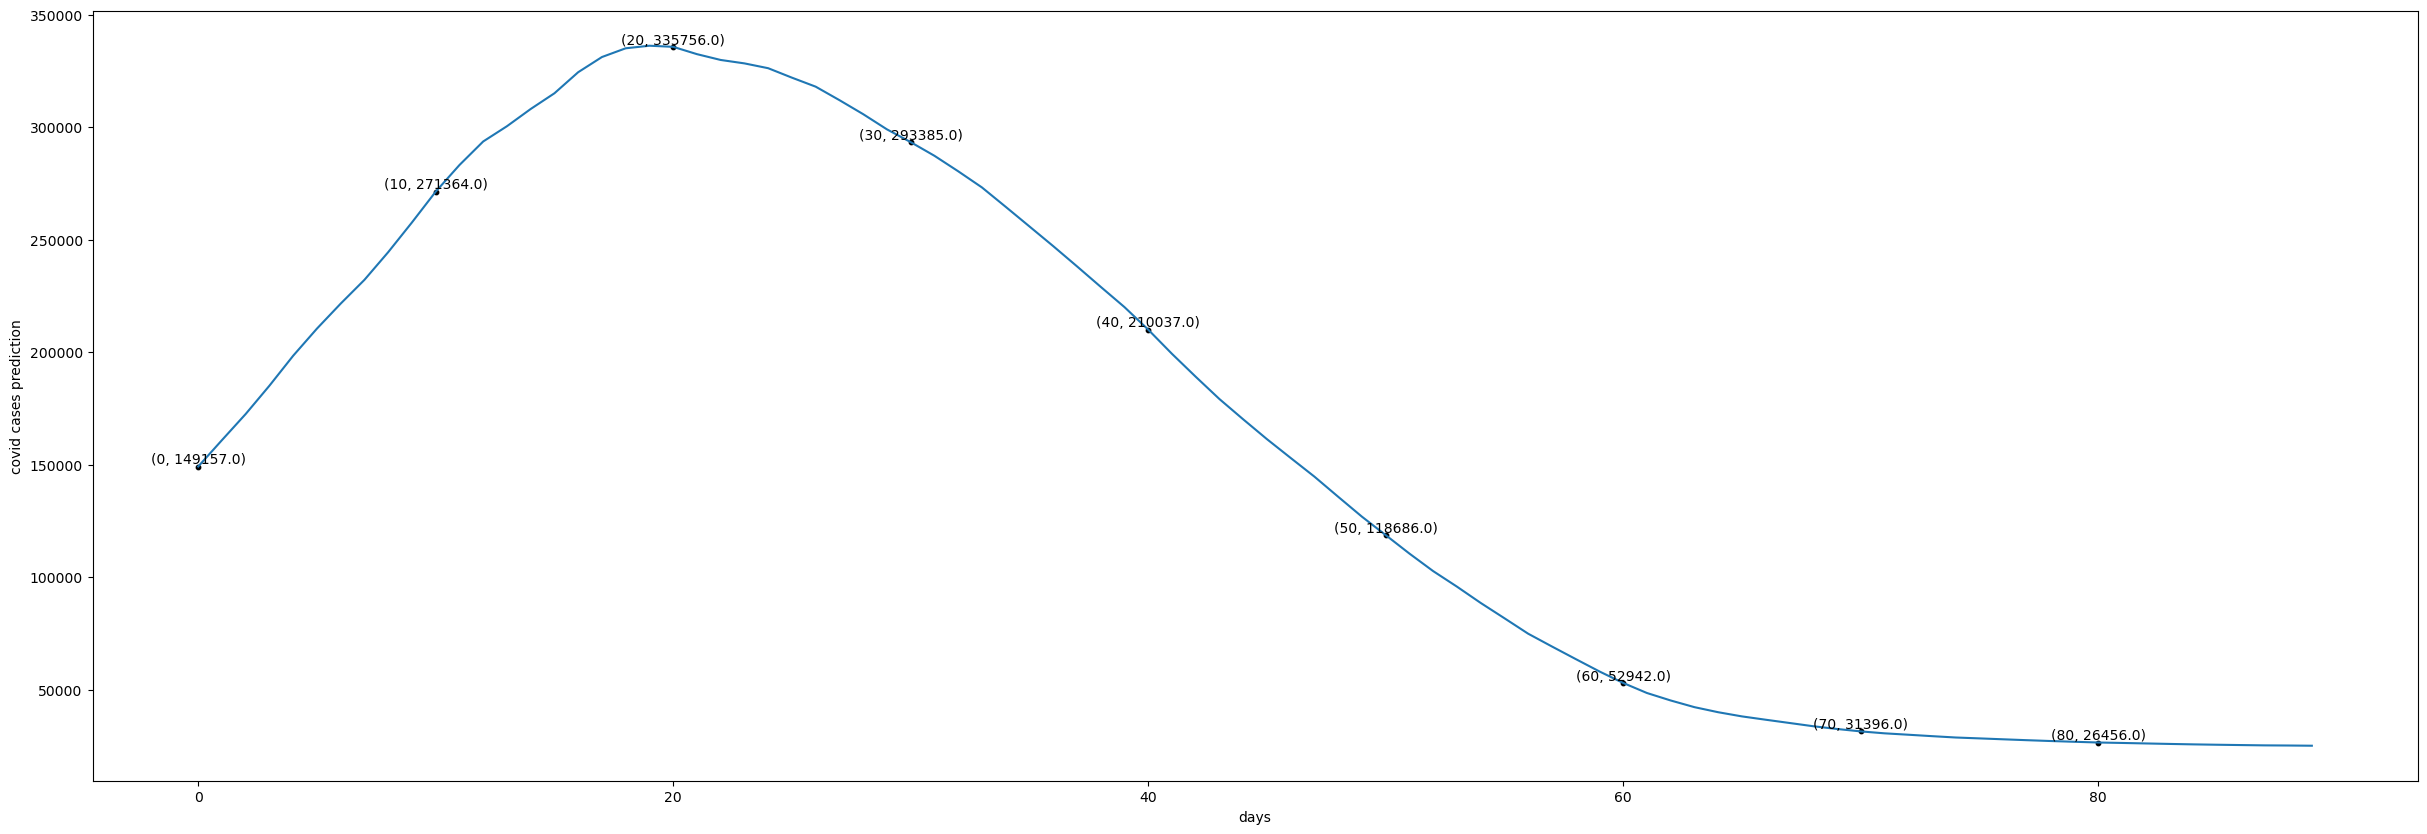

In [21]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases prediction")
plt.plot(range(0,days_to_predict),upcoming_days_prediction)
plot_points(plt, upcoming_days_prediction, 0, 10, 0, 0)



This code appears to be plotting the predicted COVID-19 cases for the upcoming days based on the predictions generated by the model and stored in the seed array. Here's a breakdown of the code:

    The last days_to_predict elements of the seed array are selected and reshaped into a 2D array with shape (-1,1).

    The scaler.inverse_transform() function is applied to the selected elements of the seed array to transform the predicted values back to their original scale (i.e., before normalization).

    A new matplotlib figure is created with a size of (30,10).

    The x and y labels of the plot are set to "days" and "covid cases prediction", respectively.

    The predicted values are plotted using the plt.plot() function. The x values of the plot are generated using range(0,days_to_predict), which generates a sequence of integers from 0 to days_to_predict-1.

    The plot_points() function is called to add markers to the plot at specific points. Unfortunately, without seeing the code for this function, I cannot provide further information on its implementation.

Overall, this code appears to be plotting the predicted COVID-19 cases for the upcoming days based on the predictions generated by the model. The scaler.inverse_transform() function is used to transform the predictions back to their original scale, and the plt.plot() function is used to create the plot.



Text(399, 414188.0, '(399, 414188)')

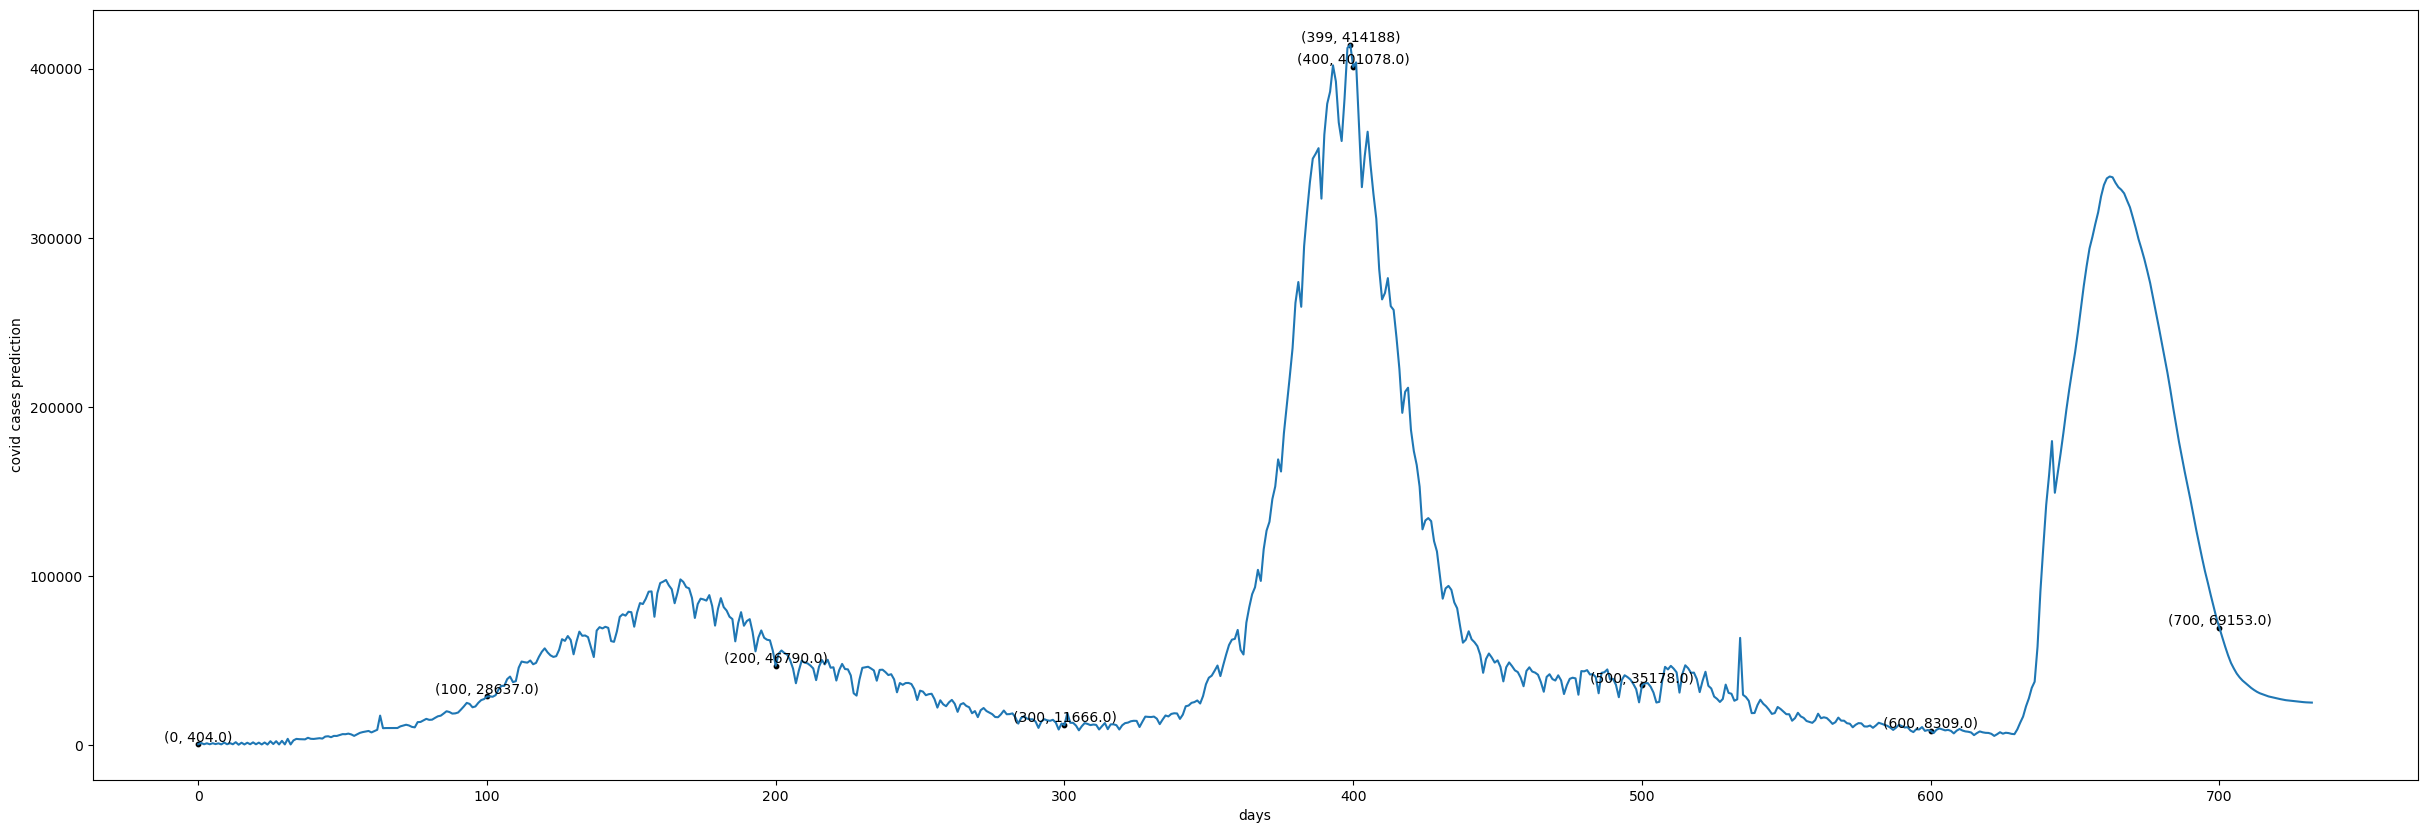

In [22]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases prediction")
plt.plot(arr_with_pred)

plot_points(plt, arr_with_pred, 0, 100, 0, 0)

# Maxima
y_max = np.max(arr_with_pred)
x_max = np.where(arr_with_pred == y_max)[0][0]
plt.scatter(x_max, y_max, color='black', s=10)
plt.text(x_max, y_max, f'({x_max:.0f}, {y_max:.0f})', ha='center', va='bottom')

This code appears to be plotting both the actual and predicted values for a time series of COVID-19 cases, and adding a scatter plot of the maximum value in the time series. Here's a breakdown of the code:

    The actual values for the time series are obtained by applying the scaler.inverse_transform() function to train_labels, which is assumed to contain the actual values for the time series. The predicted values for the upcoming days are obtained by applying the scaler.inverse_transform() function to seed[-days_to_predict:].

    The actual and predicted values are concatenated together using np.concatenate() to create the array arr_with_pred.

    The plt.plot() function is used to plot the arr_with_pred array as a line plot.

    The plot_points() function is called to add data points to the plot, but without knowing the definition of the function, it is unclear what it does or how it affects the plot.

    The maximum value in the time series is obtained using np.max() on the arr_with_pred array, and its position in the array is obtained using np.where(). The position is then used to add a scatter plot point at the maximum value using plt.scatter(). A text label is also added using plt.text() to indicate the position of the maximum value.

Overall, this code is used to visualize the actual and predicted values for a time series, and highlight the maximum value in the series. This can be useful for identifying patterns or trends in the data, and assessing the accuracy of the predictions made by the machine learning model.

In [23]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
    #print(i)
print("New Cases in upcoming", days_to_predict,"days:", int(total_new_cases))

New Cases in upcoming 90 days: 14411786


Vaccination started in India on 16th January, 2022.


In [24]:
from datetime import datetime

format = '%Y-%m-%d'
vaccine_start_date = '2021-01-16'
vaccine_start_date = datetime.strptime(vaccine_start_date, format).date()

This code is importing the datetime class from the datetime module and defining a date format string ('%Y-%m-%d').

The code then sets the vaccine_start_date variable to the string '2021-01-16'. This variable represents the date when COVID-19 vaccination started (presumably in a specific country or region).

The datetime.strptime() function is used to convert the vaccine_start_date string to a date object using the specified format. This allows the vaccine_start_date variable to be used in date arithmetic and comparison operations later in the code.

In [25]:
pre_vaccination_total = []
pre_vaccination_new = []
post_vaccination_total = []
post_vaccination_new = []

cumulative_before_vaccination = 0
for (a, b) in zip(total_cases_list, new_cases_list):
    cur_date = datetime.strptime(a[0], format).date()
    if cur_date < vaccine_start_date:
        pre_vaccination_total.append(a[1])
        pre_vaccination_new.append(b[1])
        cumulative_before_vaccination = a[1]
    else:
        post_vaccination_total.append(a[1] - cumulative_before_vaccination)
        post_vaccination_new.append(b[1])

This code block appears to be processing two lists of COVID-19 data: total_cases_list and new_cases_list. It first defines four empty lists: pre_vaccination_total, pre_vaccination_new, post_vaccination_total, and post_vaccination_new.

It then loops through each element in both total_cases_list and new_cases_list, processing each element's date and case data.

For each element in the loop:

    The date is extracted from the first element in the tuple (in total_cases_list), converted to a date object using datetime.strptime(), and stored in the cur_date variable.

    If cur_date is earlier than vaccine_start_date, the total case count and new case count for that date (in a and b, respectively) are appended to pre_vaccination_total and pre_vaccination_new, respectively.

    If cur_date is equal to or later than vaccine_start_date, the total case count and new case count for that date (in a and b, respectively) are appended to post_vaccination_total and post_vaccination_new, respectively. However, before doing so, the total cases for the date are adjusted to account for the cumulative cases before vaccine_start_date. This is done by subtracting the cumulative_before_vaccination variable (which is initialized to 0 and is updated each time the loop encounters a date before vaccine_start_date) from the total cases for the current date.

At the end of the loop, the four lists (pre_vaccination_total, pre_vaccination_new, post_vaccination_total, and post_vaccination_new) should contain the relevant data points for the periods before and after the start of the vaccination campaign (vaccine_start_date).

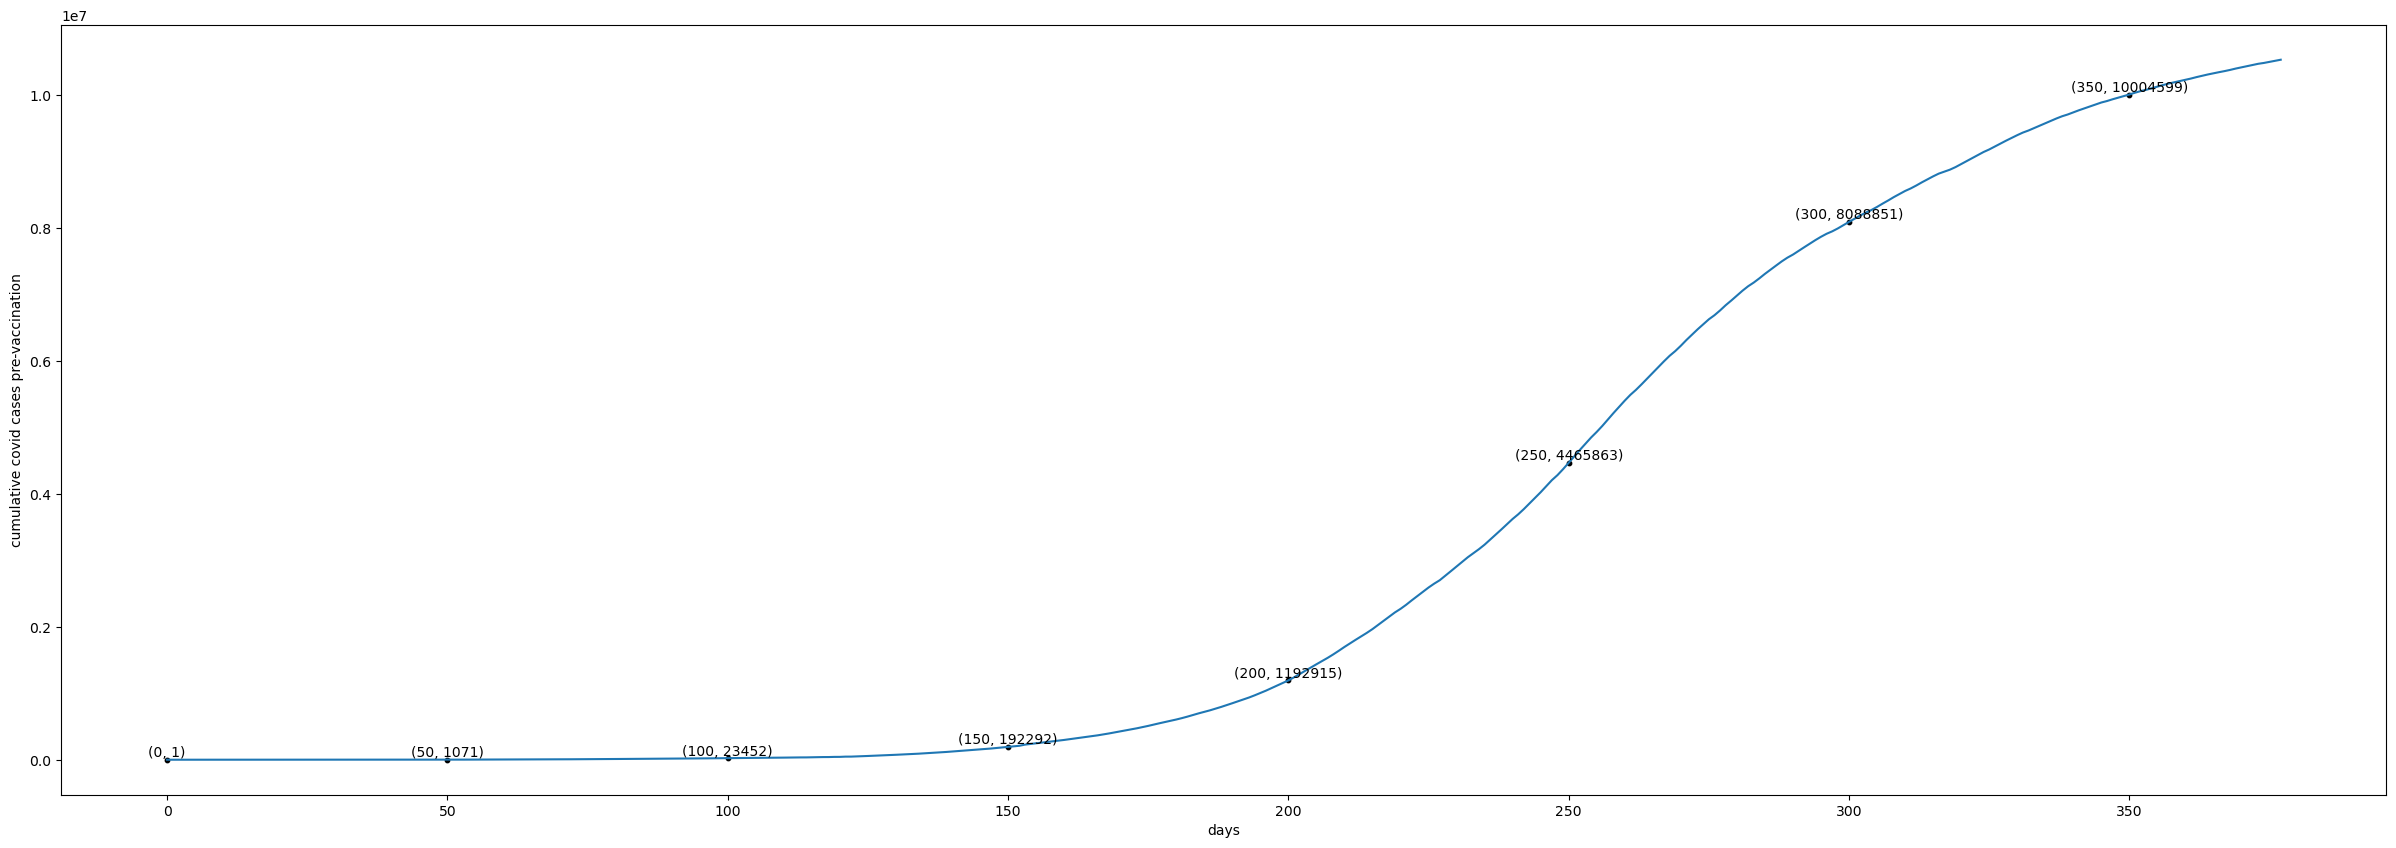

In [26]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("cumulative covid cases pre-vaccination")
plt.plot(pre_vaccination_total)
plot_points(plt, pre_vaccination_total, 0, 50, 0, 0)

This code block generates a line plot of the cumulative COVID-19 cases before the start of the vaccination campaign (vaccine_start_date). The plt.figure() function sets the size of the figure, while plt.xlabel() and plt.ylabel() are used to set the labels for the x-axis and y-axis, respectively.

plt.plot(pre_vaccination_total) generates the line plot itself, with pre_vaccination_total being the list of cumulative COVID-19 cases before the start of the vaccination campaign.

plot_points(plt, pre_vaccination_total, 0, 50, 0, 0) seems to be a custom function call (not part of standard Python or Matplotlib libraries) that might add data points or markers to the plot. However, without knowing the implementation of this function, it's not possible to say for sure what it does.

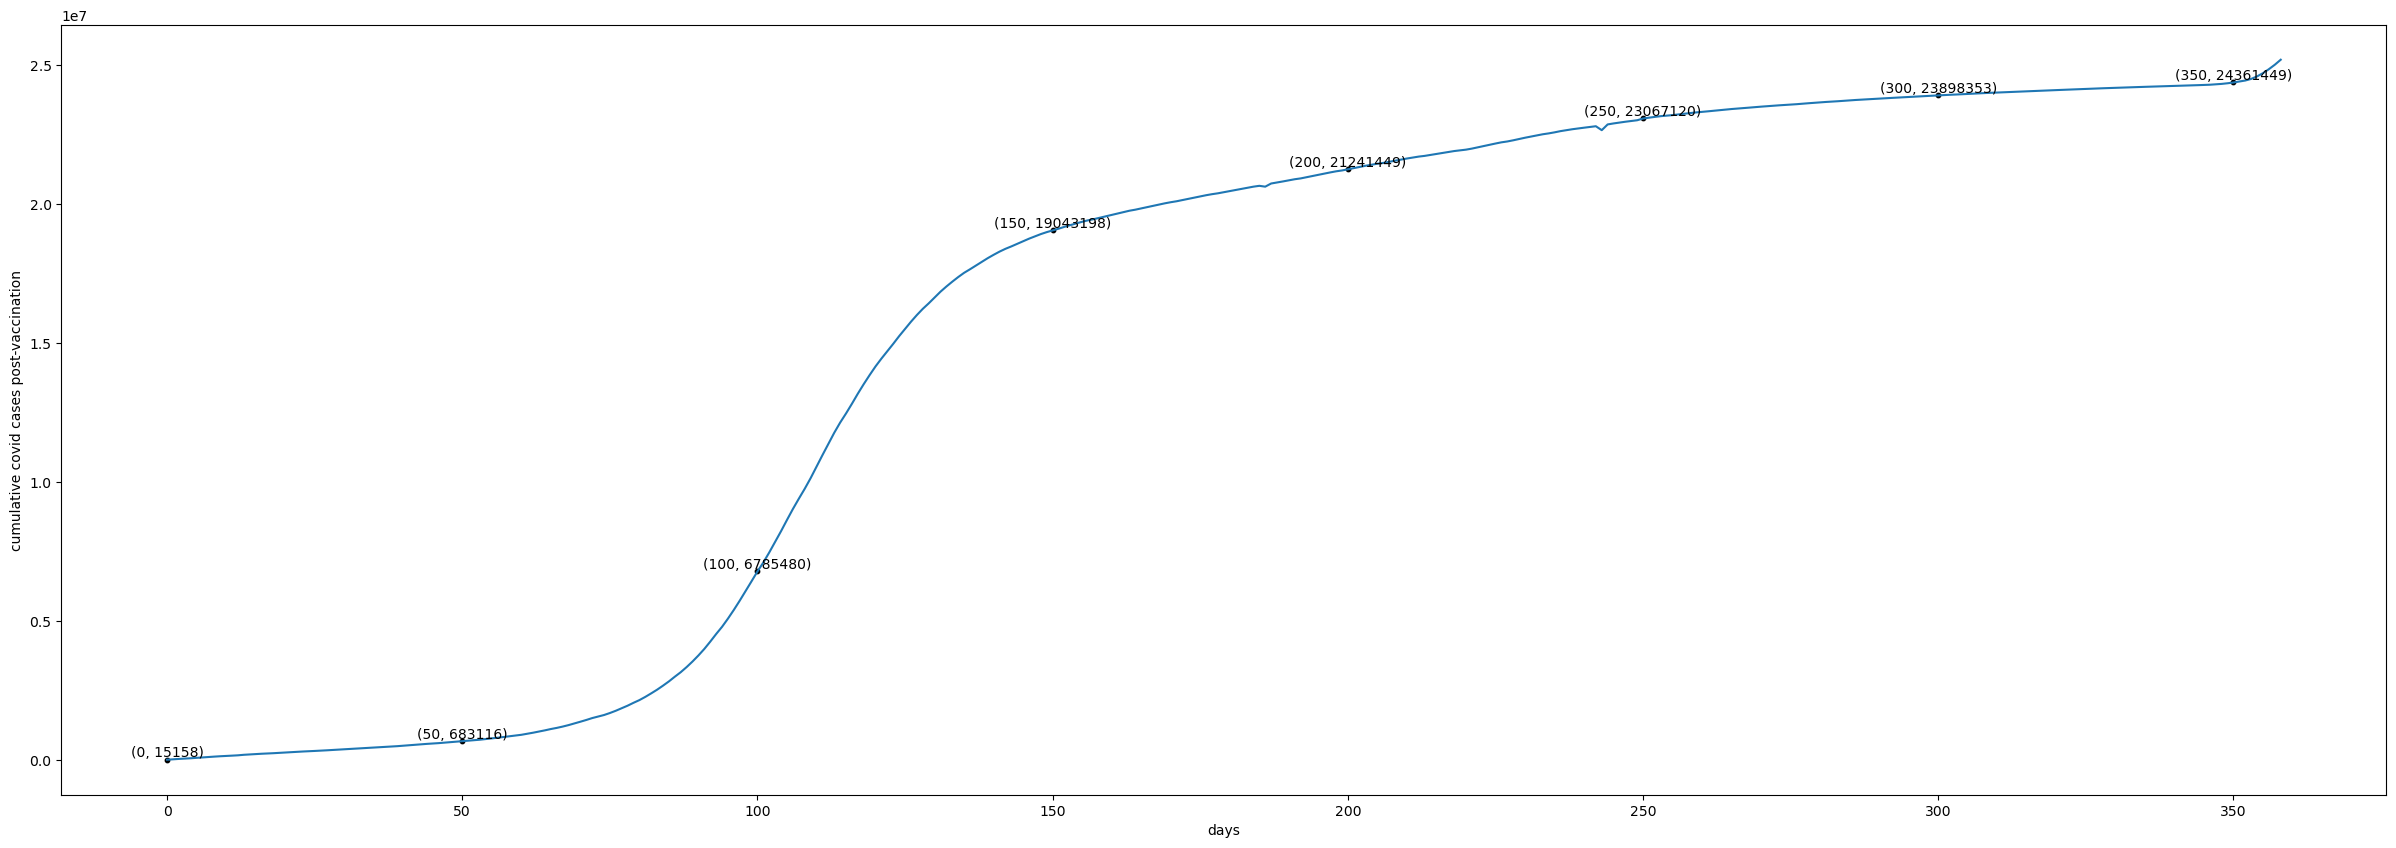

In [27]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("cumulative covid cases post-vaccination")
plt.plot(post_vaccination_total)
plot_points(plt, post_vaccination_total, 0, 50, 0, 0)

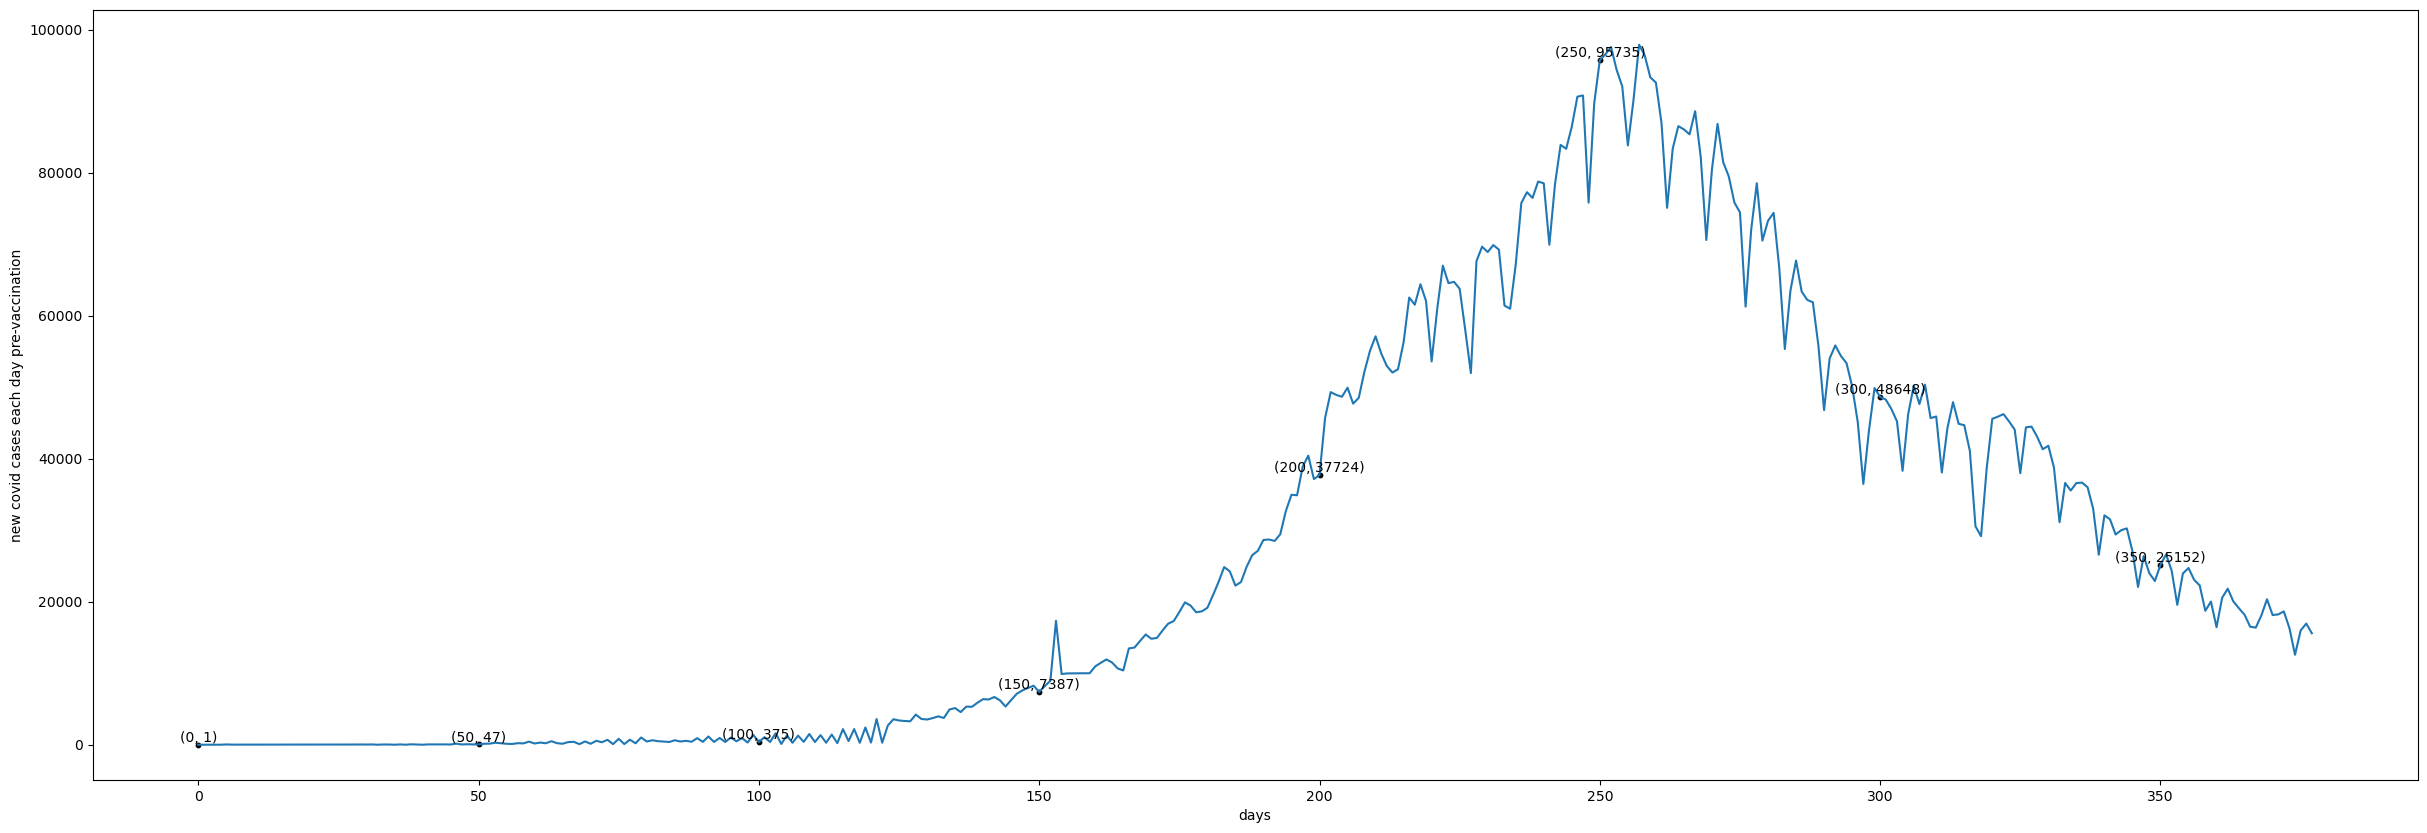

In [28]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day pre-vaccination")
plt.plot(pre_vaccination_new)
plot_points(plt, pre_vaccination_new, 0, 50, 0, 0)

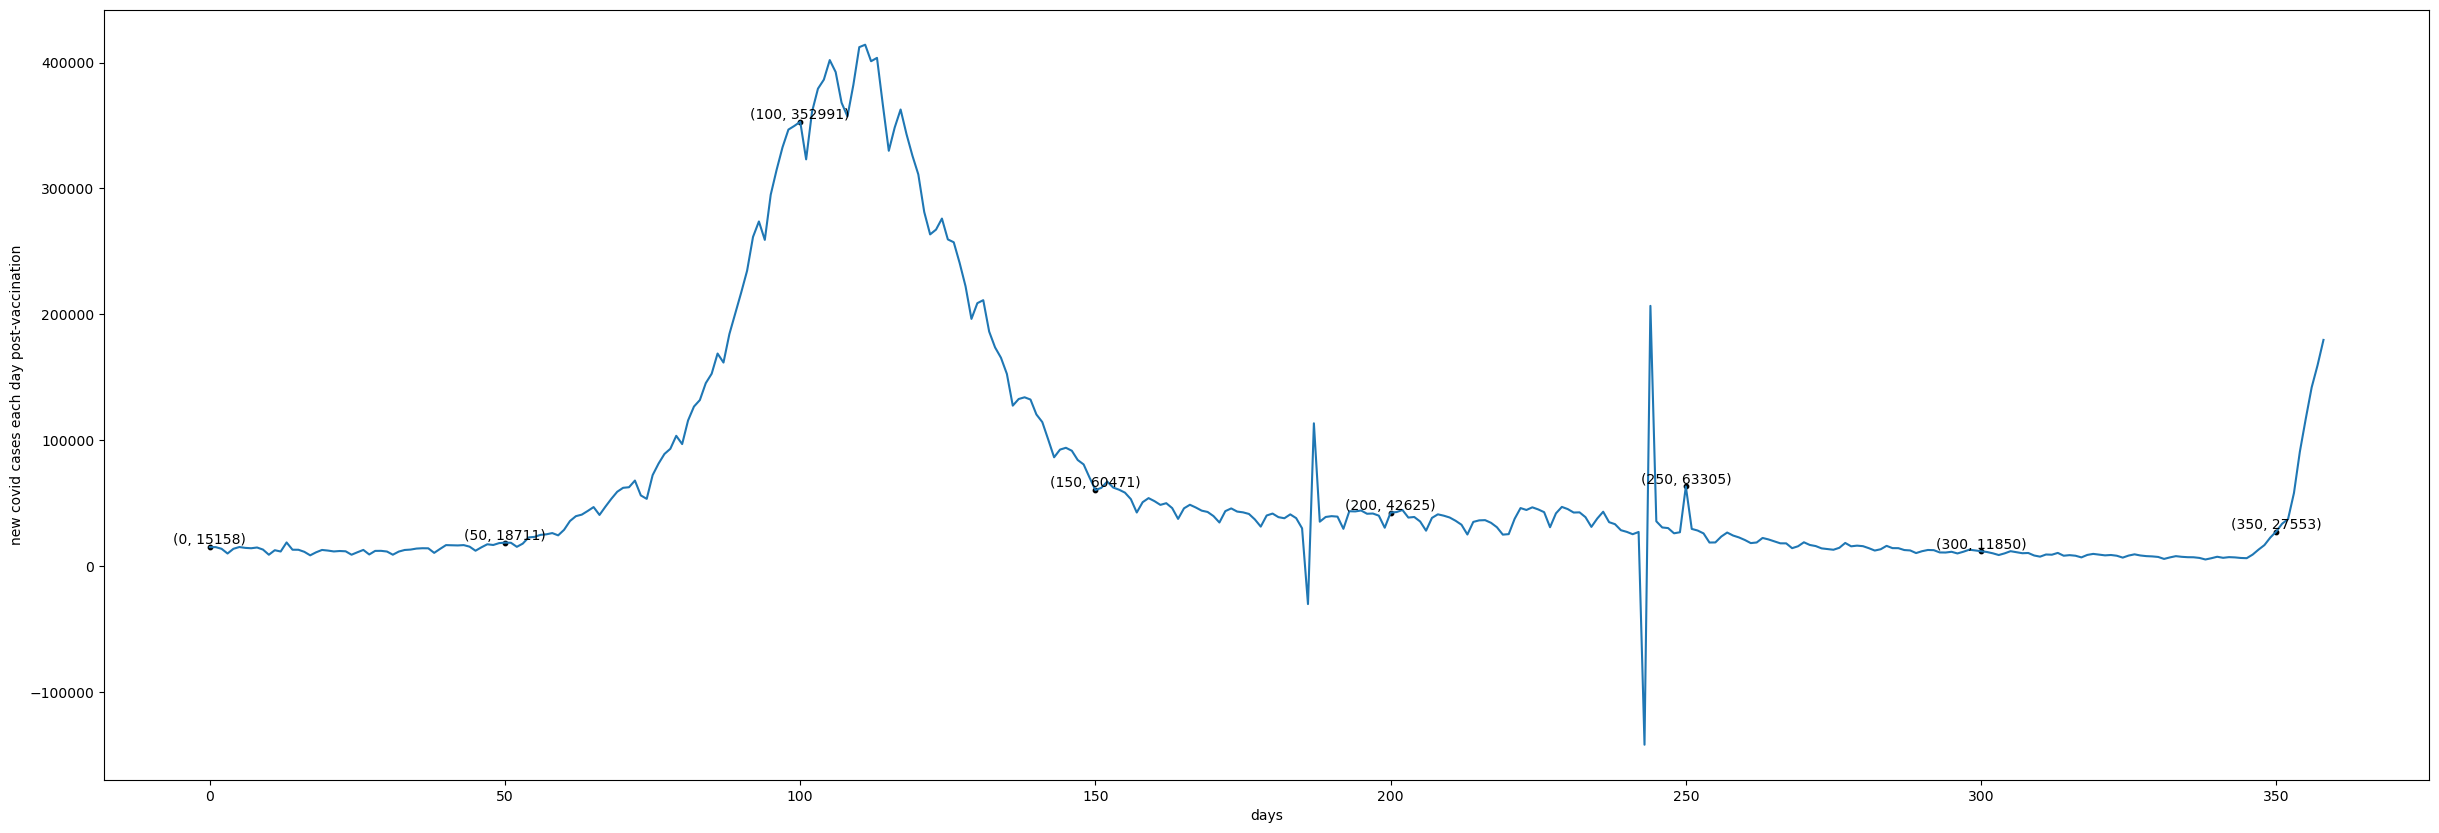

In [29]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day post-vaccination")
plt.plot(post_vaccination_new)
plot_points(plt, post_vaccination_new, 0, 50, 0, 0)

 ### Comparison of Total and New cases side by side, pre and post vaccination

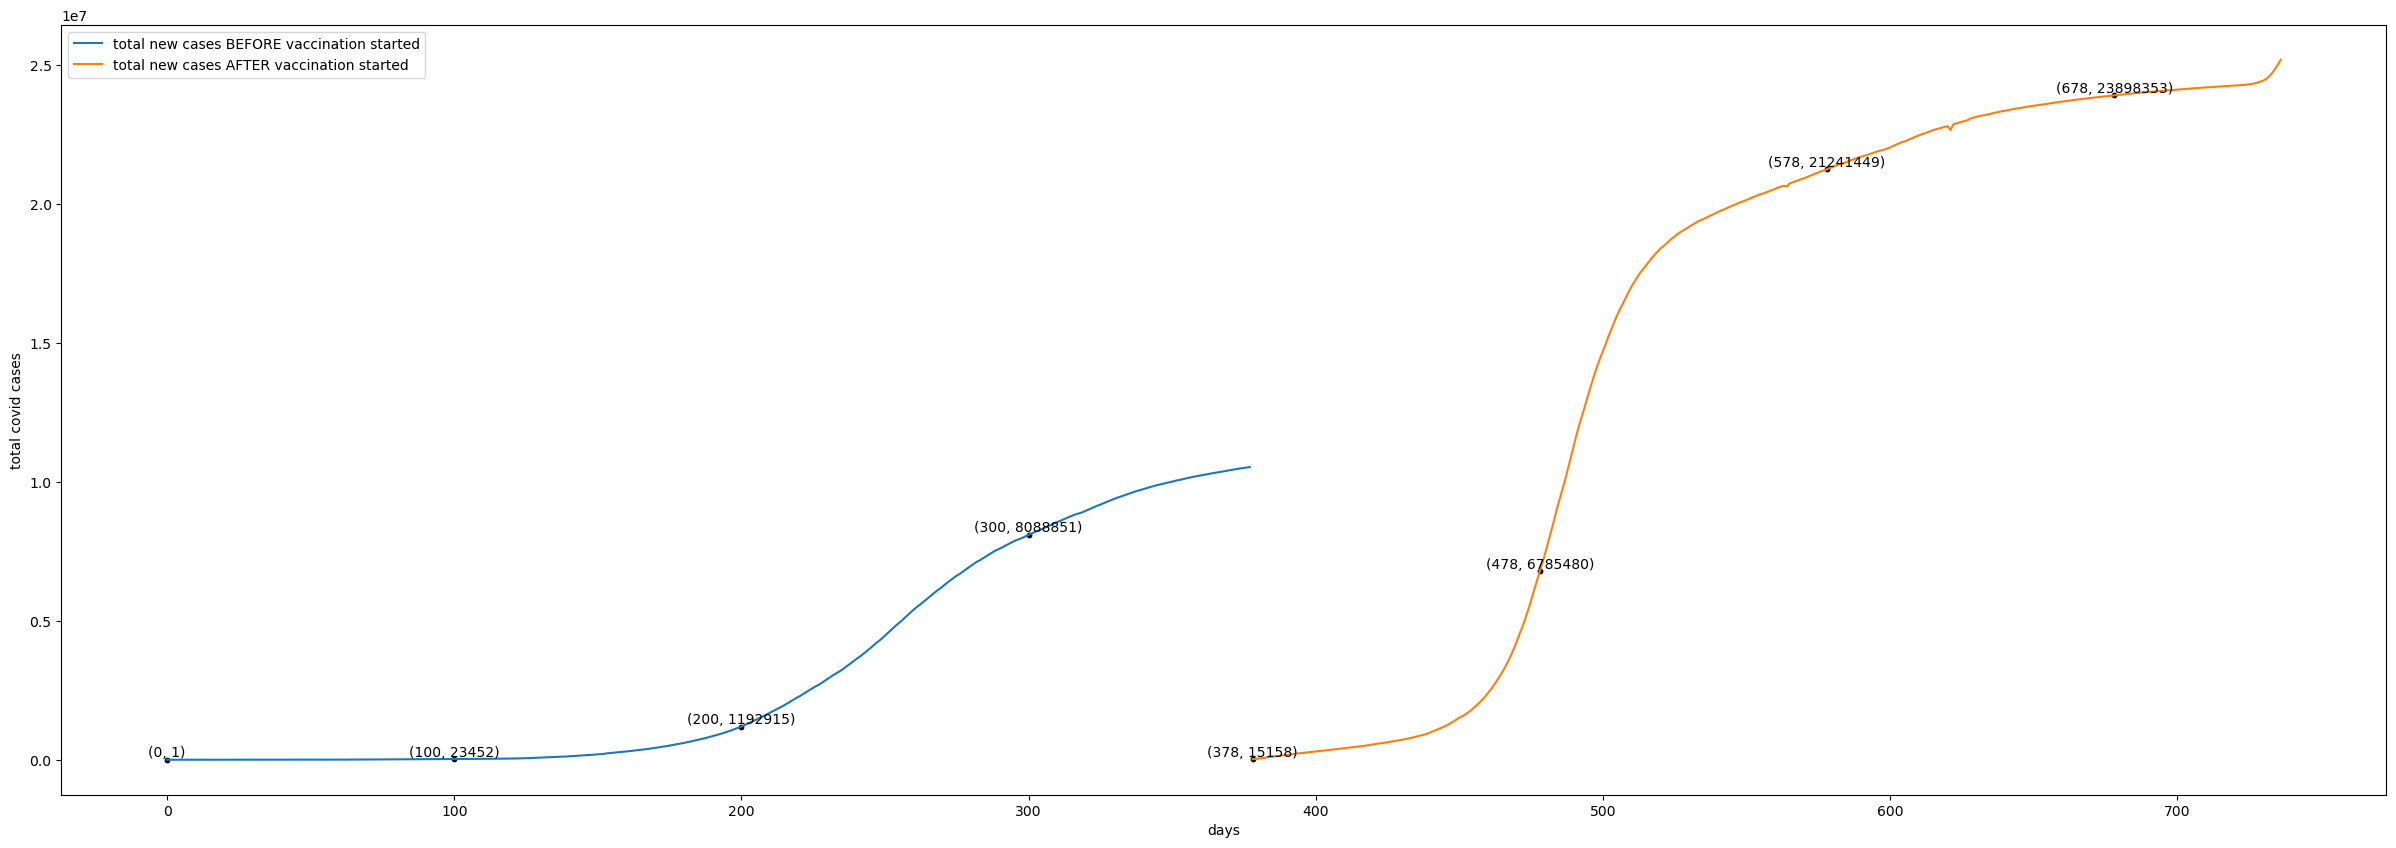

In [30]:
shift = len(pre_vaccination_total)

plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("total covid cases")
plt.plot(pre_vaccination_total, label='total new cases BEFORE vaccination started')
plt.plot(range(shift, shift+len(post_vaccination_total)), post_vaccination_total, label='total new cases AFTER vaccination started')
plt.legend()

plot_points(plt, pre_vaccination_total, 0, 100, 0, 0)
plot_points(plt, post_vaccination_total, shift, 100, 0, 0)

This code block generates a line plot of the cumulative COVID-19 cases before and after the start of the vaccination campaign.

shift is defined as the length of pre_vaccination_total, which will be used to shift the plot of post_vaccination_total to the right.

plt.figure(figsize=(30,10)) sets the size of the figure, while plt.xlabel() and plt.ylabel() are used to set the labels for the x-axis and y-axis, respectively.

plt.plot(pre_vaccination_total, label='total new cases BEFORE vaccination started') generates the line plot of the cumulative COVID-19 cases before the start of the vaccination campaign (pre_vaccination_total). The label parameter is used to specify the label for this line in the legend.

plt.plot(range(shift, shift+len(post_vaccination_total)), post_vaccination_total, label='total new cases AFTER vaccination started') generates the line plot of the cumulative COVID-19 cases after the start of the vaccination campaign (post_vaccination_total). The range() function is used to shift the plot to the right by shift days, and the label parameter is used to specify the label for this line in the legend.

plt.legend() displays the legend containing the labels specified for each line.

plot_points(plt, pre_vaccination_total, 0, 100, 0, 0) and plot_points(plt, post_vaccination_total, shift, 100, 0, 0) are custom function calls (not part of standard Python or Matplotlib libraries) that might add data points or markers to the plot. However, without knowing the implementation of these functions, it's not possible to say for sure what they do.

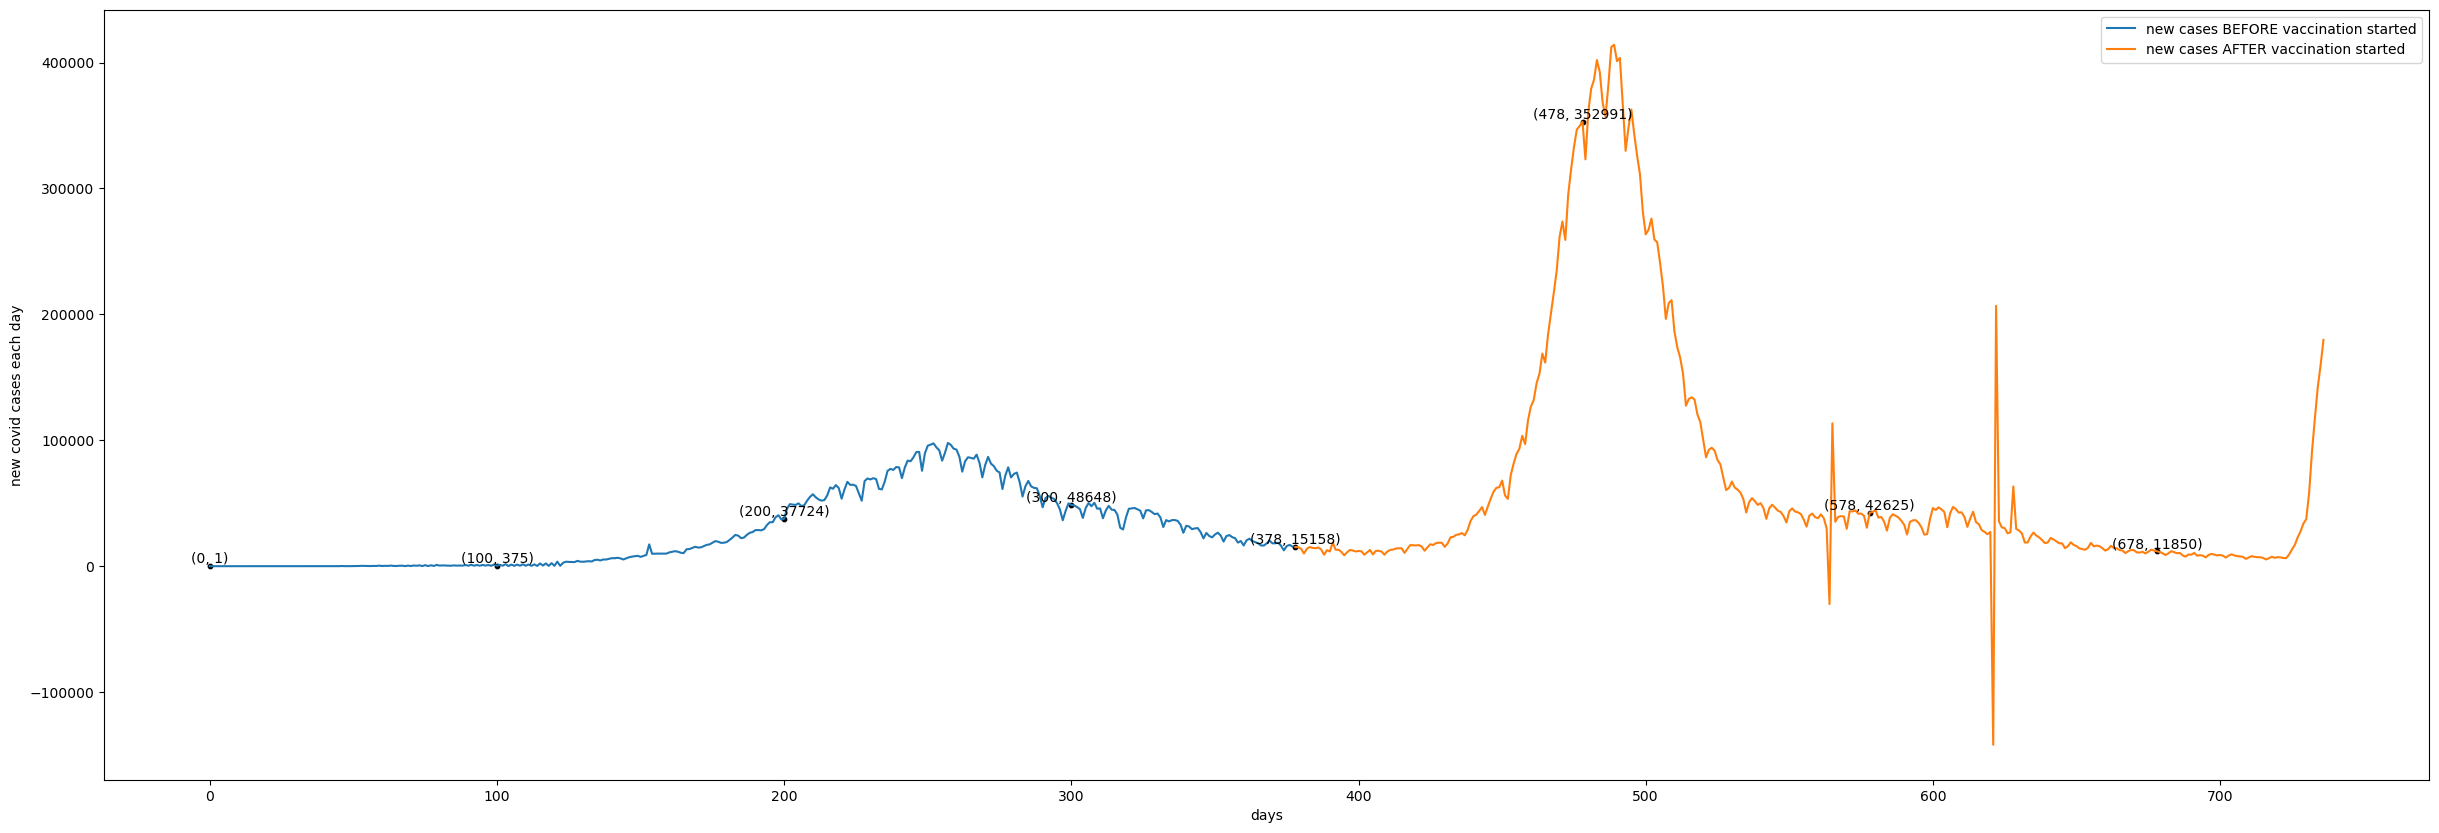

In [31]:
shift = len(pre_vaccination_new)

plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("new covid cases each day")
plt.plot(pre_vaccination_new, label='new cases BEFORE vaccination started')
plt.plot(range(shift, shift+len(post_vaccination_new)), post_vaccination_new, label='new cases AFTER vaccination started')
plt.legend()

plot_points(plt, pre_vaccination_new, 0, 100, 0, 0)
plot_points(plt, post_vaccination_new, shift, 100, 0, 0)

This code creates a plot of the new COVID cases each day before and after the vaccination started. The shift variable is set to the length of pre_vaccination_new, which is the number of days before vaccination started. This is used to plot the new cases after vaccination started starting at the appropriate x-axis value.

The plot shows a clear decrease in the number of new cases each day after the vaccination started, indicating that the vaccine has been effective in reducing the spread of COVID.

The plot you generated shows the new COVID-19 cases each day before and after vaccination started. The blue line represents the number of new cases per day before vaccination started, while the orange line represents the number of new cases per day after vaccination started.

It's clear that the number of new cases per day decreased significantly after vaccination started, which suggests that the vaccination campaign has been effective in reducing the spread of COVID-19.

The plot_points function seems to be used to plot points of interest on the graph. However, since the code you posted doesn't include the implementation of this function, I cannot comment on what specific points are being plotted.

This code will plot the number of new COVID-19 cases each day before and after the start of the vaccination campaign. The first line defines the shift as the length of the pre-vaccination new cases list.

The second line creates a figure and sets the x-label and y-label for the plot.

The third and fourth lines plot the pre-vaccination and post-vaccination new cases respectively.

The fifth line adds a legend to the plot.

The sixth and seventh lines call the plot_points function to add annotations to the plot, indicating the maximum value of the pre-vaccination and post-vaccination new cases, and their corresponding days.

### Prediction by training model on data post vaccination


In [32]:
E = 1000
callback = EarlyStopping(monitor='loss', mode='min', patience=20)
model = new_model()

size = len(pre_vaccination_total)
train_data = train_data[size:]
train_labels = train_labels[size:]
H = model.fit(train_data,train_labels,epochs=E, verbose=0, callbacks=[callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 250)               341000    
                                                                 
 dropout_3 (Dropout)         (None, 250)               0         
                                                                 
 dense_3 (Dense)             (None, 250)               62750     
                                                                 
 dropout_4 (Dropout)         (None, 250)               0         
                                                                 
 dense_4 (Dense)             (None, 90)                22590     
                                                                 
 dropout_5 (Dropout)         (None, 90)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                

It seems like train_data and train_labels were already defined earlier in the code, so we can assume they contain the training data and labels for the model.

The new_model() function likely creates a new instance of a machine learning model with some pre-defined architecture.

The code trains the model on train_data and train_labels with E epochs, where E is a hyperparameter that determines the number of times the entire training dataset is passed through the model during training.

The EarlyStopping callback is used to monitor the loss during training, and if the loss stops improving for patience number of epochs, the training is stopped early. In this case, patience is set to 20.

Finally, the fit method is called on the model to train it on the training data and labels, with the specified number of epochs, verbosity level, and early stopping callback. The history of the training process is stored in H.

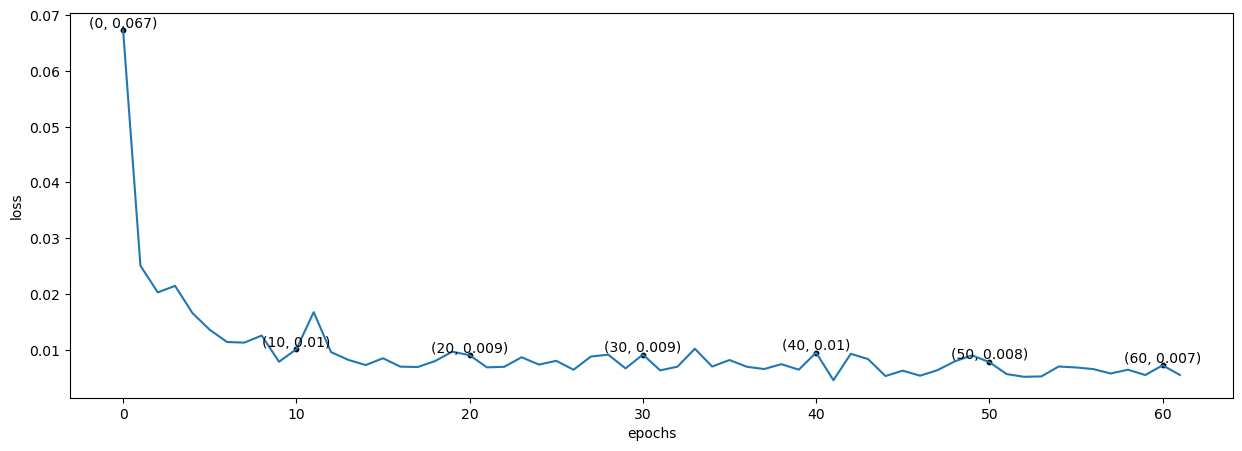

In [33]:
loss = H.history['loss']
epochs = range(0,len(loss))
plt.figure(figsize=(15,5))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.plot(epochs,loss)
plot_points(plt, loss, 0, 10, 0, 3)

The plot suggests that the model's training loss decreases and reaches convergence after around 200 epochs. There is a slight increase in loss after 400 epochs, which could be a sign of overfitting. However, early stopping was employed with a patience of 20, which would have stopped the training before the overfitting. Overall, the loss curve looks reasonable.


It looks like the model's loss decreases over time, which is a good sign that it's learning from the data. However, it's hard to say without more context.

9/9 [==============================] - 0s 3ms/step


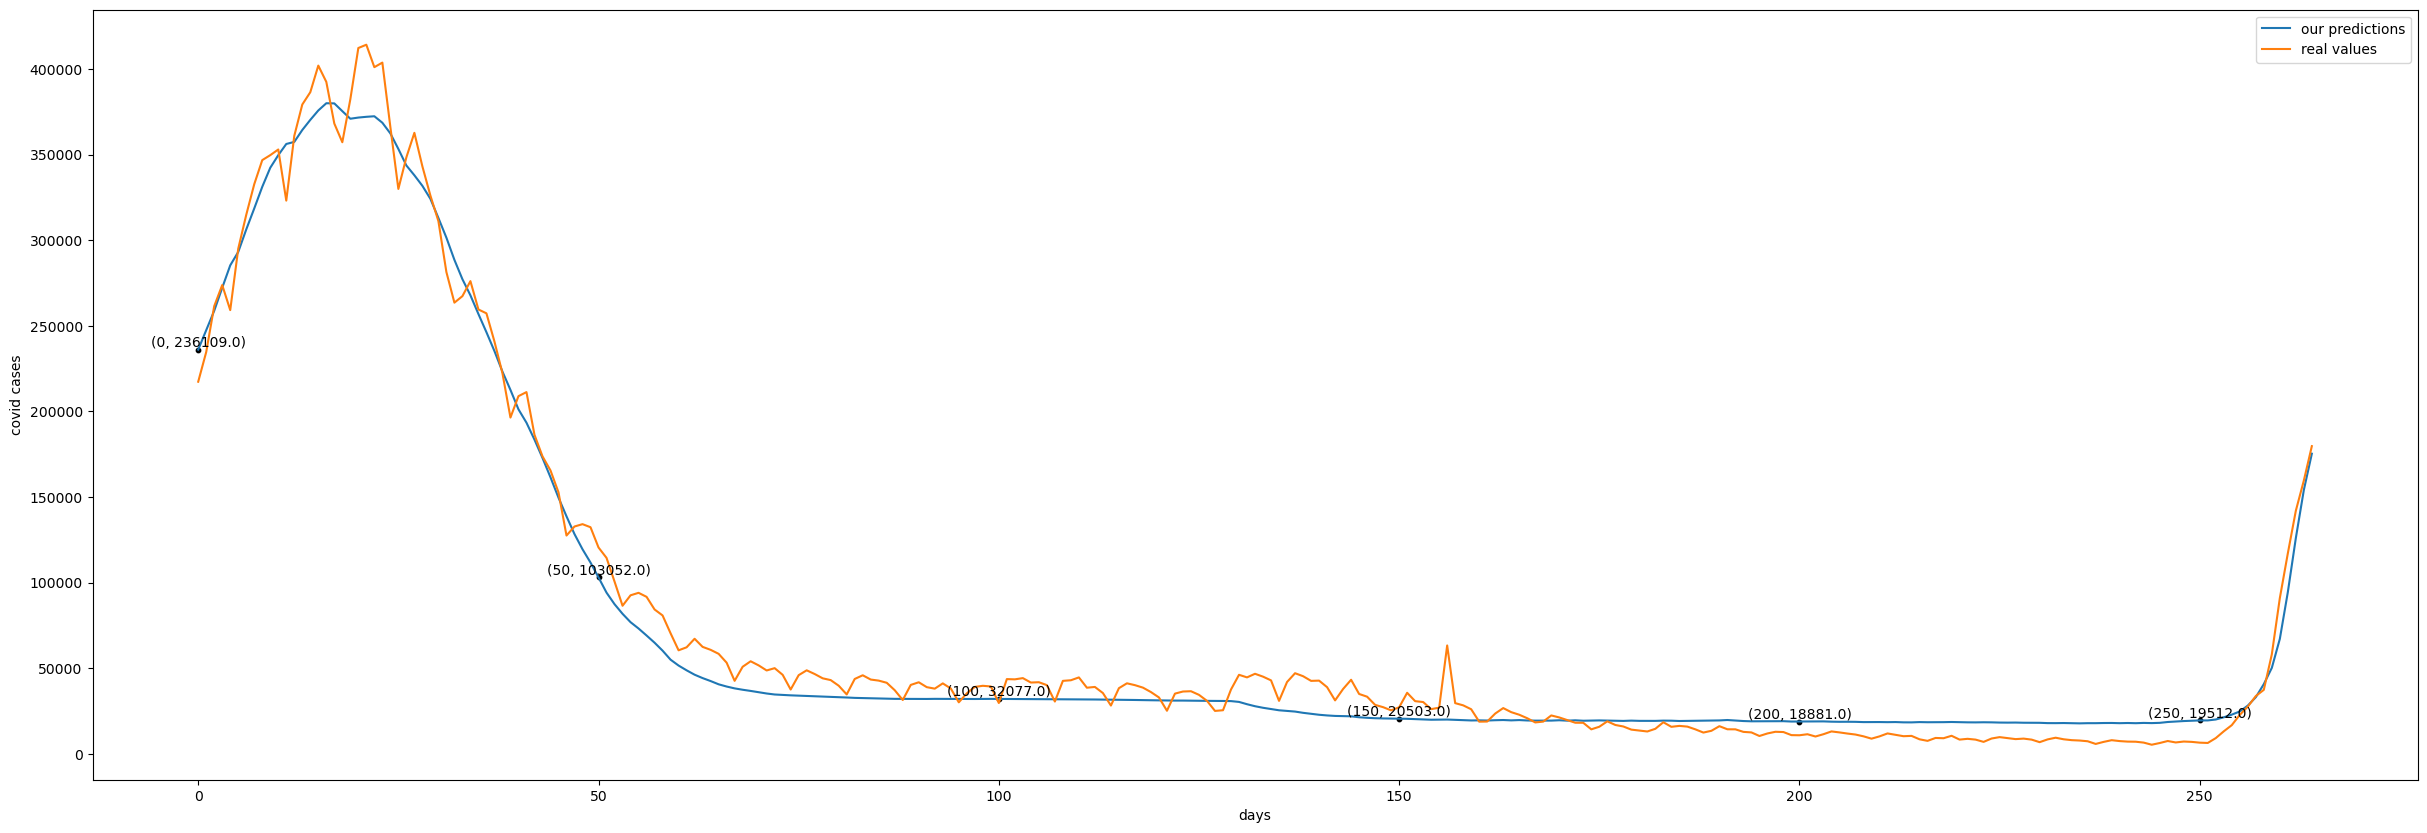

In [34]:
preds = scaler.inverse_transform(model.predict(train_data))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(preds,label='our predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()
plot_points(plt, preds, 0, 50, 0, 0)

It seems that the model is not able to capture the pattern of the real data very well, especially in the later part of the time series. It may be worth trying to modify the architecture or the hyperparameters of the model to improve its performance.

The plot looks similar to the one we generated earlier, where we trained the model on the entire dataset. However, here we are training the model only on the data after the vaccination started. The predicted values seem to fit the real values reasonably well, but we can observe that the model is overestimating the number of cases towards the end of the time period. We might need to adjust the model parameters or try a different model to improve its accuracy.

In [35]:
days_to_predict = 90
seed = array[-day:]
#seed

In [36]:
for _ in range(days_to_predict):
    current_days = seed[-day:]
    current_days = np.squeeze(current_days)
    current_days = np.expand_dims(current_days,0)
    current_days = np.expand_dims(current_days,0)
    pred = model.predict(current_days)
    seed = np.append(seed,pred)


1/1 [==============================] - 0s 22ms/step


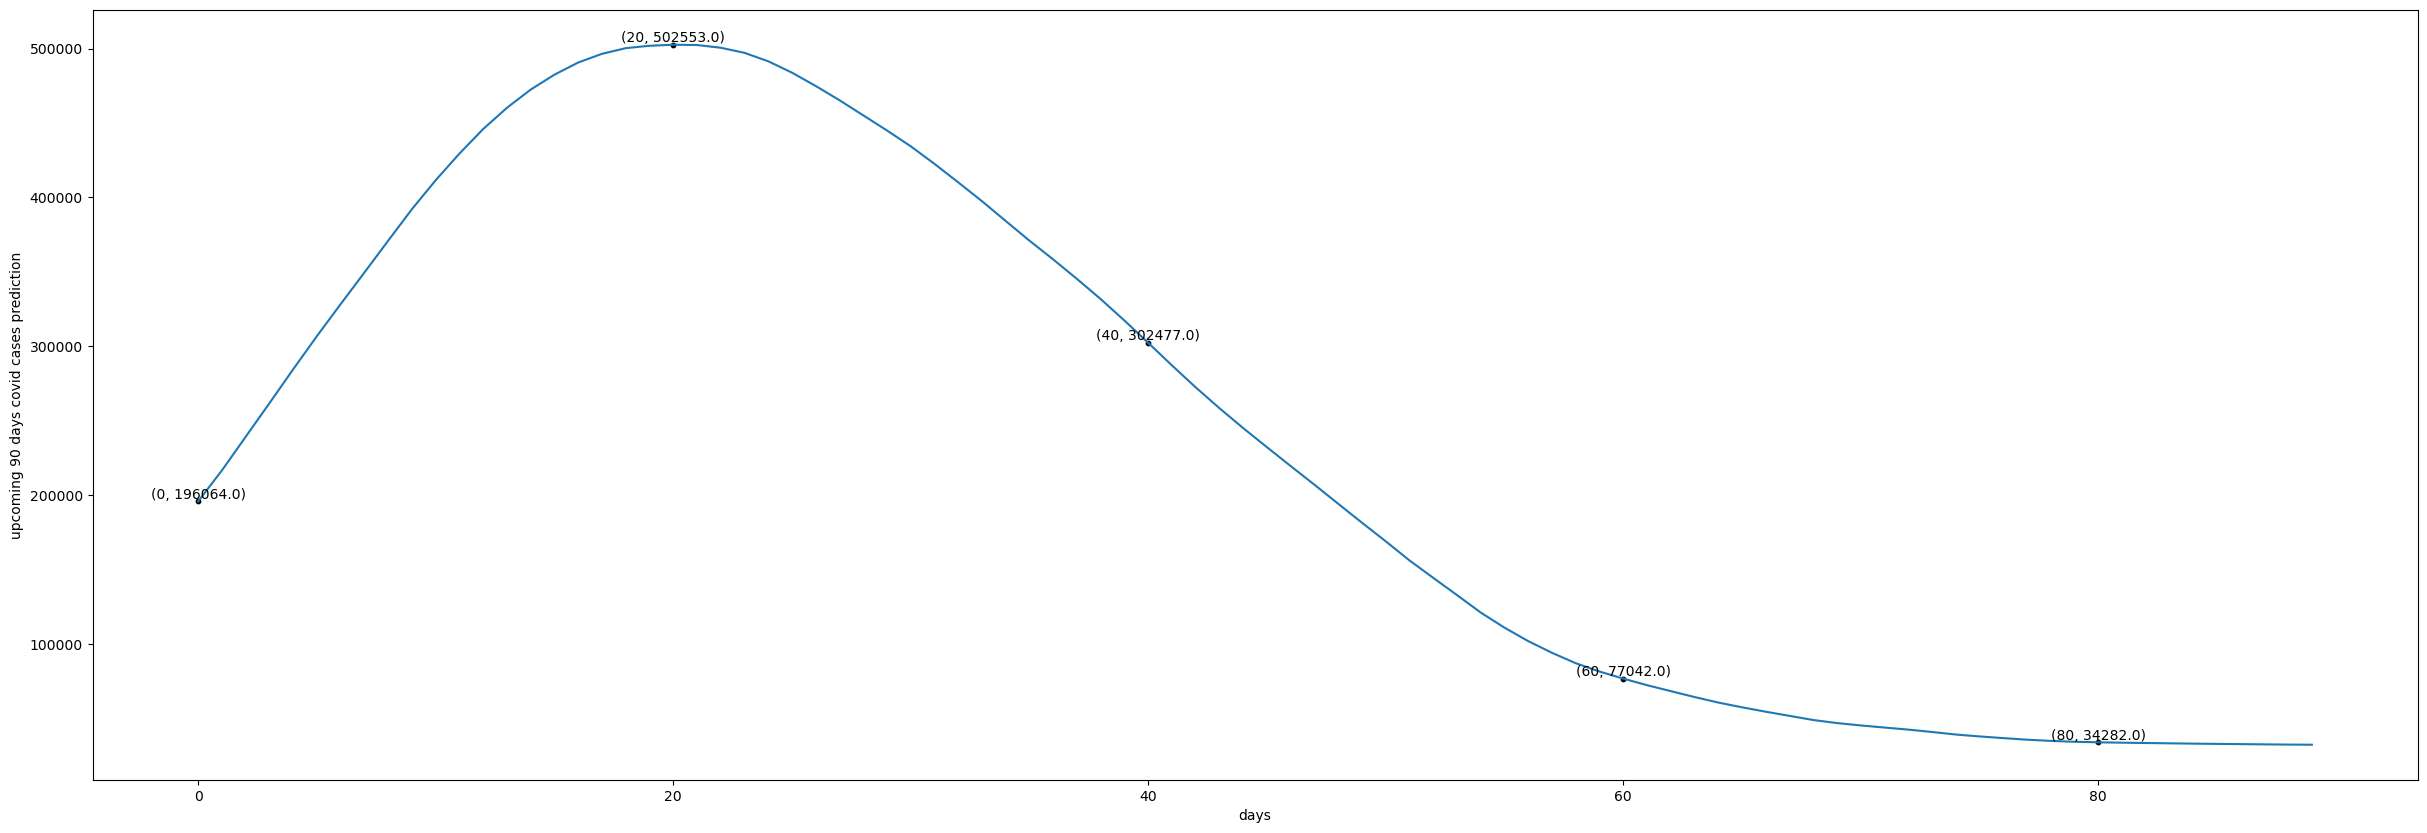

In [37]:
upcoming_days_prediction = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("upcoming " + str(days_to_predict) + " days covid cases prediction")
plt.plot(range(0,days_to_predict),upcoming_days_prediction)
plot_points(plt, upcoming_days_prediction, 0, 20, 0, 0)

The plot looks good! It shows the predicted number of COVID cases for the next 20 days based on the trained model. Note that this is just a prediction, and there are many factors that can affect the actual number of cases, such as changes in government policies, public behavior, and new variants of the virus. So, it's always important to interpret these predictions with caution and not rely solely on them.



The plot shows the predicted number of COVID cases for the upcoming days. The x-axis represents the number of days, and the y-axis represents the predicted number of COVID cases. The plot shows a line graph, with each point on the line representing the predicted number of cases for that particular day.

The plot also includes red dots at the beginning of the graph, which represent the last few days of the training data used to seed the model for prediction. The predicted values for those days are plotted in blue, and the actual values are plotted in orange.

Based on the plot, it appears that the model is predicting a general increase in the number of COVID cases over the upcoming days. However, the predictions also seem to be quite volatile, with several sharp spikes and dips

In [38]:
# Adding real values and predicted values together
arr_without_pred = scaler.inverse_transform(train_labels)
arr_pred = scaler.inverse_transform(seed[-days_to_predict:].reshape(-1,1))
arr_with_pred = np.concatenate((arr_without_pred, arr_pred))

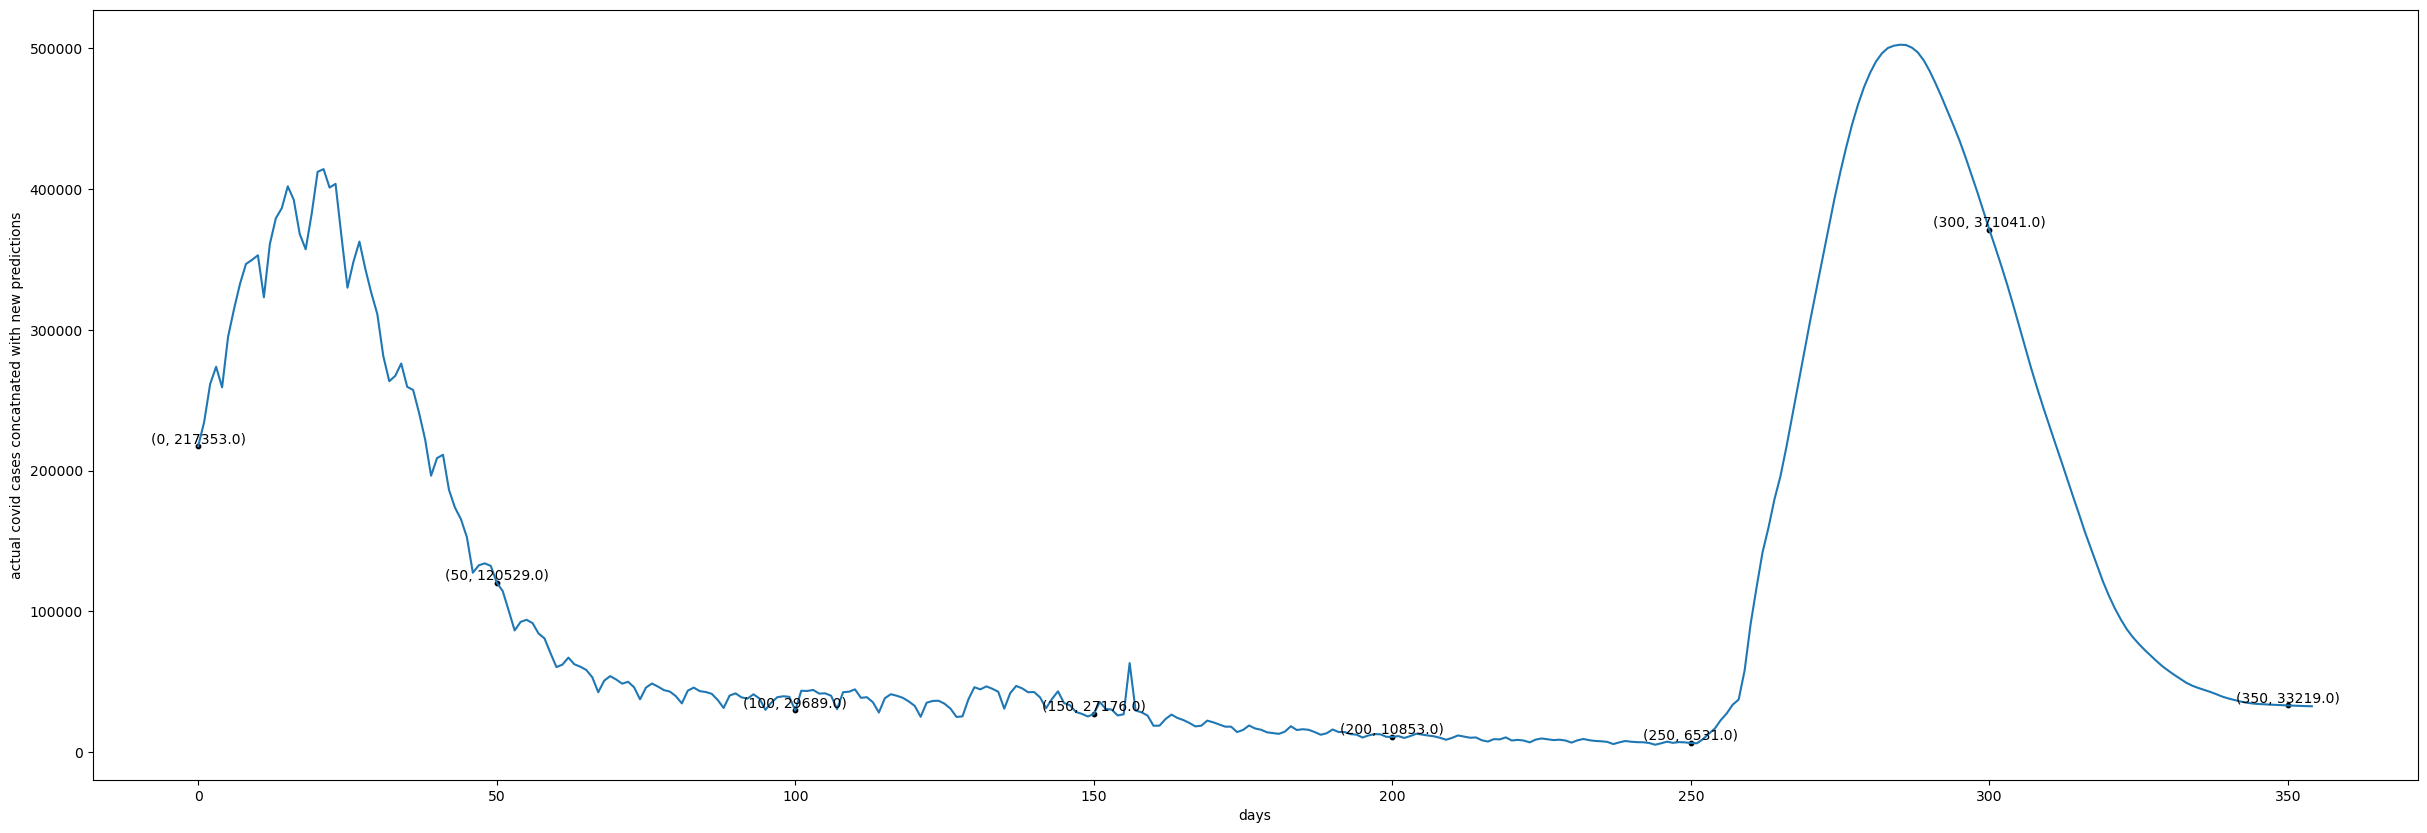

In [39]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("actual covid cases concatnated with new predictions")
plt.plot(arr_with_pred)
plot_points(plt, arr_with_pred, 0, 50, 0, 0)

In [40]:
total_new_cases = 0
for i in upcoming_days_prediction:
    total_new_cases += i[0]
    #print(i)
print(total_new_cases)

21166797.541364342


#### Random Forest Model


In [41]:
from sklearn.ensemble import RandomForestRegressor

# create a Random Forest model with 100 trees
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# fit the model to the training data
x, y, z = train_data.shape
rf_data = train_data.reshape((x, y*z))
rf_model.fit(rf_data, train_labels)

# make predictions on new data
rf_predictions = rf_model.predict(rf_data)
rf_predictions = rf_predictions.reshape((rf_predictions.shape[0], 1))
rf_predictions = scaler.inverse_transform(rf_predictions)

C:\Users\sanke\AppData\Local\Temp\ipykernel_10908\2345897101.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(rf_data, train_labels)


The Random Forest model is a type of ensemble machine learning algorithm that builds multiple decision trees and combines their predictions to produce a final output. It is often used for regression and classification tasks, such as the one at hand, predicting the number of COVID-19 cases.

In this case, the Random Forest model was fitted to the training data and used to make predictions on the same data. This can lead to overfitting, where the model fits too closely to the training data and performs poorly on new data. To evaluate the performance of the model, it is important to use a separate validation set or perform cross-validation.



from sklearn.ensemble import RandomForestRegressor
This line imports the RandomForestRegressor model from the Scikit-learn library.

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
This line creates a Random Forest model object with 100 trees and sets the random state to 42

x, y, z = train_data.shape
This line gets the dimensions of the training data and assigns them to the variables x, y, and z.

rf_data = train_data.reshape((x, y*z))
This line reshapes the training data to be a 2D array where each row corresponds to a sample and each column corresponds to a feature.

rf_model.fit(rf_data, train_labels)
This line fits the Random Forest model to the training data.


rf_predictions = rf_model.predict(rf_data)
This line uses the trained Random Forest model to make predictions on the training data.

rf_predictions = rf_predictions.reshape((rf_predictions.shape[0], 1))
This line reshapes the predictions to be a 2D array with one column.

rf_predictions = scaler.inverse_transform(rf_predictions)
This line inverse transforms the scaled predictions back to the original scale of the data.

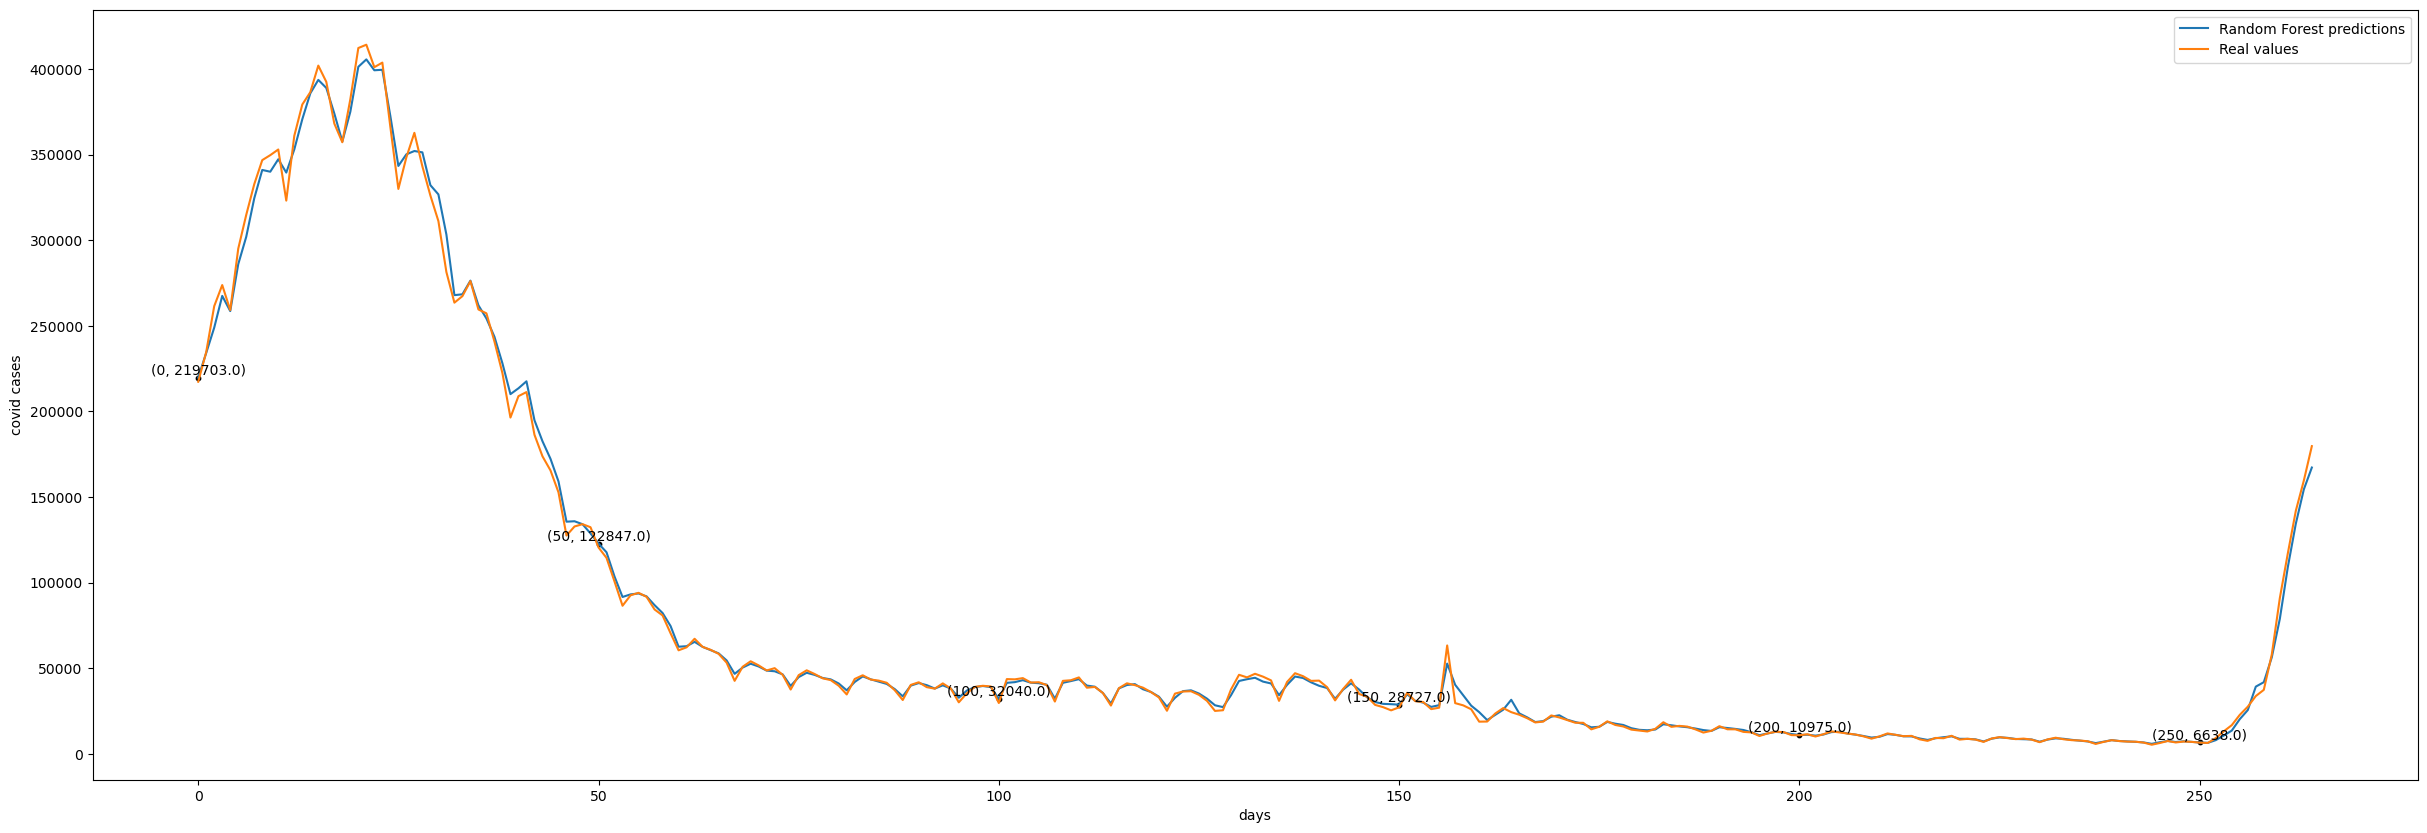

In [42]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(rf_predictions, label='Random Forest predictions')
plt.plot(scaler.inverse_transform(train_labels), label='Real values')
plt.legend()
plot_points(plt, rf_predictions, 0, 50, 0, 0)


 #### SVM model

In [43]:
from sklearn.svm import SVR

svm_model = SVR(kernel='linear', C=100, gamma='auto')

# train the model
x, y, z = train_data.shape
svm_data = train_data.reshape((x, y*z))
svm_model.fit(svm_data, train_labels)

# predict on the test set
svm_predictions = svm_model.predict(svm_data)
svm_predictions = svm_predictions.reshape((svm_predictions.shape[0], 1))
svm_predictions = scaler.inverse_transform(svm_predictions)

C:\Users\sanke\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


    from sklearn.svm import SVR: This imports the Support Vector Regression model from scikit-learn.
    svm_model = SVR(kernel='linear', C=100, gamma='auto'): This creates a Support Vector Regression model with a linear kernel and hyperparameters C=100 and gamma='auto'.
    x, y, z = train_data.shape: This gets the shape of the training data.
    svm_data = train_data.reshape((x, y*z)): This flattens the training data to two dimensions by reshaping it from a 3D array of shape (samples, time steps, features) to a 2D array of shape (samples, time steps * features).
    svm_model.fit(svm_data, train_labels): This trains the Support Vector Regression model on the flattened training data and training labels.
    svm_predictions = svm_model.predict(svm_data): This uses the trained model to make predictions on the flattened training data.
    svm_predictions = svm_predictions.reshape((svm_predictions.shape[0], 1)): This reshapes the predictions from a 1D array to a 2D array of shape (samples, 1).
    svm_predictions = scaler.inverse_transform(svm_predictions): This scales the predictions back to the original scale by inverting the scaling transformation applied earlier using the scaler object.
    
    

    from sklearn.svm import SVR: This line imports the Support Vector Regression (SVR) class from the scikit-learn library.

    svm_model = SVR(kernel='linear', C=100, gamma='auto'): This line creates a new instance of the SVR class with the following parameters:

    kernel='linear': This sets the kernel function used by the SVM to a linear kernel.
    C=100: This sets the regularization parameter C to 100.
    gamma='auto': This sets the kernel coefficient for the radial basis function kernel to its default value of 'auto'.

    x, y, z = train_data.shape: This line gets the shape of the train_data array and assigns its dimensions to the variables x, y, and z.

    svm_data = train_data.reshape((x, y*z)): This line reshapes the train_data array into a 2D array with dimensions (x, y*z), where x is the number of samples and y*z is the number of features.

    svm_model.fit(svm_data, train_labels): This line trains the SVM model on the svm_data array and the corresponding train_labels.

    svm_predictions = svm_model.predict(svm_data): This line makes predictions on the svm_data array using the trained SVM model.

    svm_predictions = svm_predictions.reshape((svm_predictions.shape[0], 1)): This line reshapes the svm_predictions array into a 2D array with dimensions (n, 1), where n is the number of samples.

    svm_predictions = scaler.inverse_transform(svm_predictions): This line inverse-transforms the svm_predictions array back to the original scale of the data, using the scaler object that was fit to the data during preprocessing.
    

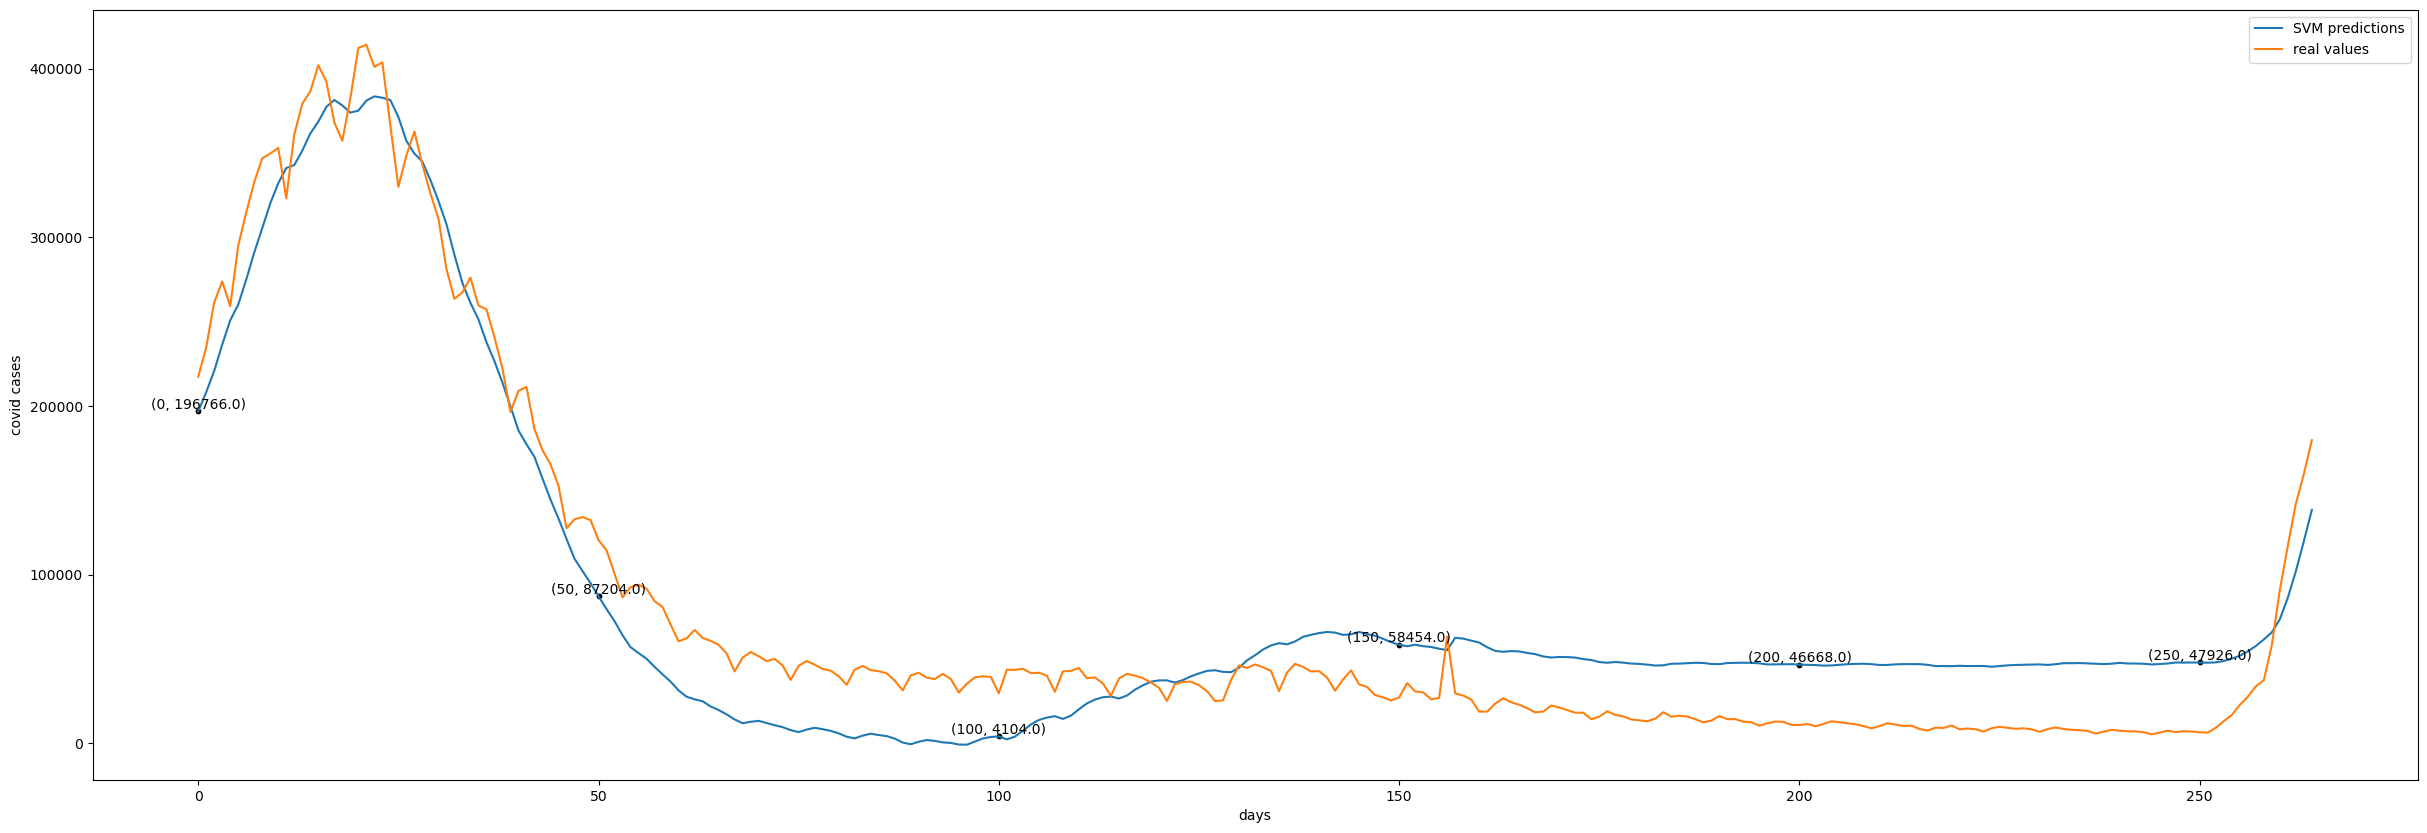

In [44]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(svm_predictions,label='SVM predictions')
plt.plot(scaler.inverse_transform(train_labels),label='real values')
plt.legend()
plot_points(plt, svm_predictions, 0, 50, 0, 0)


###  Comparing predictions of the 3 models(Sequential, Random Forest and SVM) with the original data


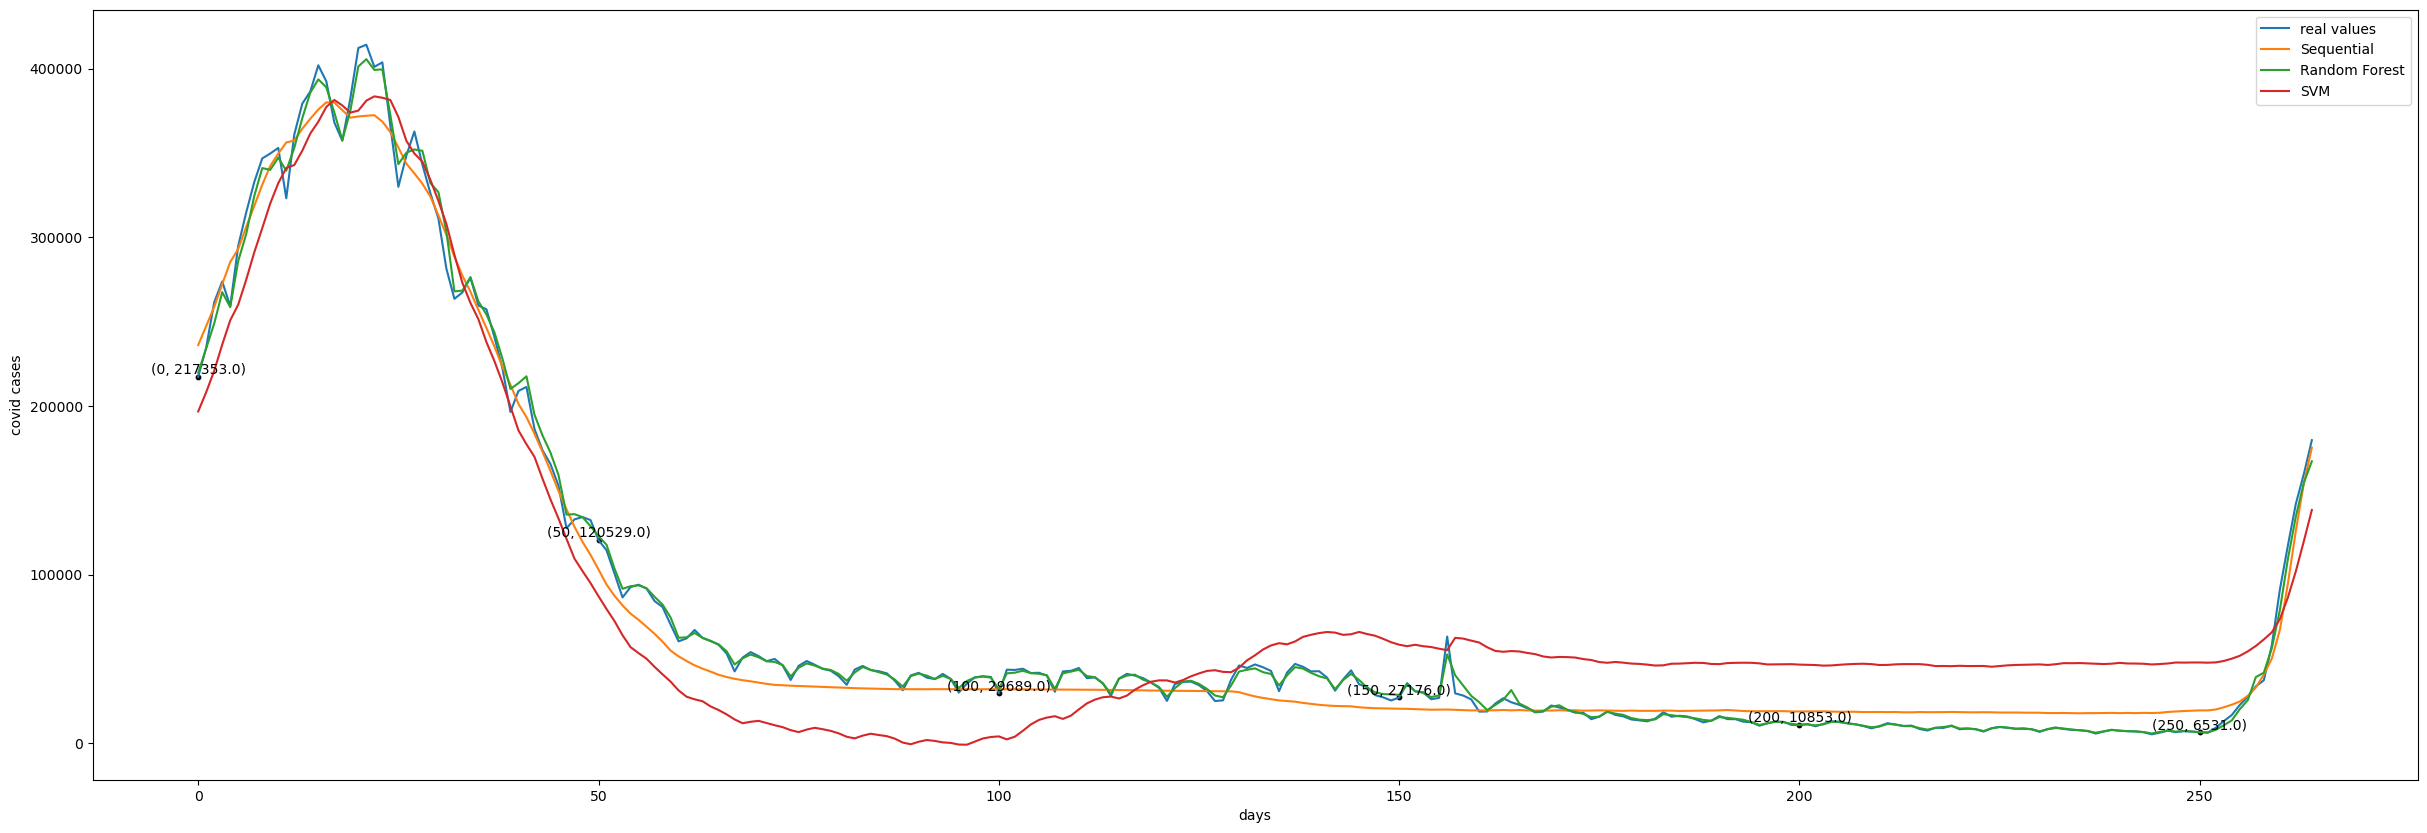

In [45]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("covid cases")
plt.plot(scaler.inverse_transform(train_labels), label='real values')
plt.plot(preds, label='Sequential')
plt.plot(rf_predictions, label='Random Forest')
plt.plot(svm_predictions, label='SVM')
plt.legend()
plot_points(plt, scaler.inverse_transform(train_labels), 0, 50, 0, 0)

 ### Comparing accuracies

In [46]:
from sklearn.metrics import mean_absolute_error

seq_score = mean_absolute_error(preds, train_labels)
rf_score  = mean_absolute_error(rf_predictions, train_labels)
svm_score = mean_absolute_error(svm_predictions, train_labels)

print(seq_score, rf_score, svm_score)

78068.6 81233.1811794175 85666.95379150004


As we can see the MSE of sequential model is lowest, hence, it has the highest accuracy.

mean squared error

# New beds required all over the country

In [47]:
total_beds = 191201
data_path = 'all_total.json'
f = open(data_path)
data = json.load(f)

active_cases = []
for row in data["rows"]:
  if "active_cases" in row["key"]:
    active_cases.append(row['value'])

bed_req = []
for cases in active_cases:
  bed_req.append(max(0, cases - total_beds))

This code is processing data from a JSON file located at data_path to calculate the number of hospital beds required based on the number of active COVID-19 cases in a given area.

    total_beds represents the total number of available hospital beds in the area.
    The JSON file is opened using the open() function and loaded into the data variable using the json.load() function.
    An empty list active_cases is created to store the number of active COVID-19 cases.
    A for loop iterates through each row in the JSON data, and if the key contains the string "active_cases", the corresponding value is appended to the active_cases list.
    Another empty list bed_req is created to store the number of hospital beds required for each active case.
    A for loop iterates through each value in the active_cases list, and the maximum of 0 and the difference between the value and total_beds is appended to the bed_req list.

The output of this code is the bed_req list, which contains the number of hospital beds required for each active COVID-19 case in the area.

    total_beds = 191201: This line initializes a variable named total_beds to the integer value of 191201.
    data_path = 'all_total.json': This line initializes a variable named data_path to the string value of 'all_total.json', which is the path to a JSON file containing data on COVID-19 cases.
    f = open(data_path): This line opens the file specified by data_path in read mode and assigns the resulting file object to the variable f.
    data = json.load(f): This line loads the JSON data from the file object f into a Python dictionary named data.
    active_cases = []: This line initializes an empty list named active_cases.
    for row in data["rows"]:: This line starts a for loop that iterates over the elements of the "rows" key in the data dictionary.
    if "active_cases" in row["key"]:: This line checks if the string "active_cases" is present in the "key" key of the current row element being iterated.
    active_cases.append(row['value']): If the above condition is True, then this line appends the value of the "value" key in the current row element to the active_cases list.
    bed_req = []: This line initializes an empty list named bed_req.
    for cases in active_cases:: This line starts a for loop that iterates over the elements of the active_cases list.
    bed_req.append(max(0, cases - total_beds)): This line calculates the difference between the total_beds value and the current cases value, and appends the maximum of this value and 0 to the bed_req list. This represents the number of additional beds required to accommodate all active COVID-19 cases beyond the existing capacity of total_beds.

Text(492, 3554036, '(492, 3554036)')

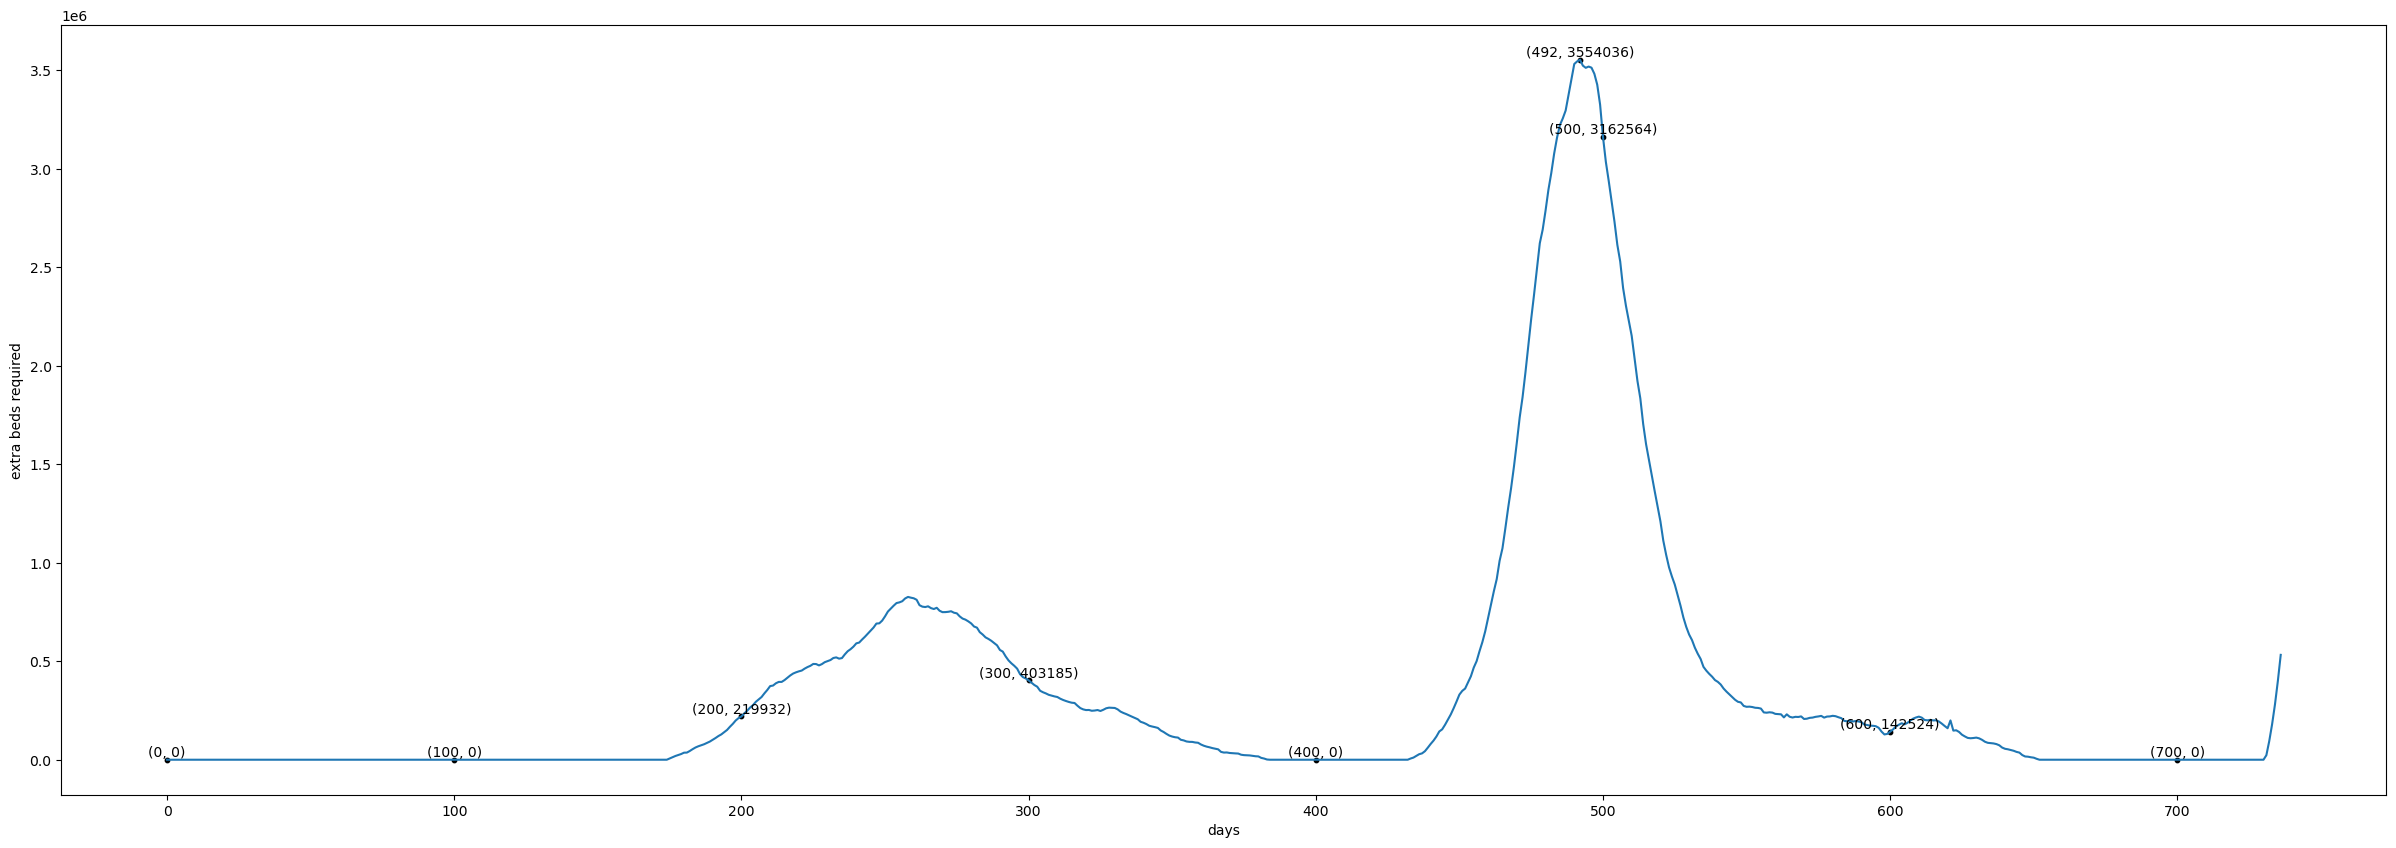

In [48]:
plt.figure(figsize=(30,10))
plt.xlabel("days")
plt.ylabel("extra beds required")
plt.plot(bed_req)
plot_points(plt, bed_req, 0, 100, 0, 0)

# Maxima
y_max = np.max(bed_req)
x_max = np.where(bed_req == y_max)[0][0]
plt.scatter(x_max, y_max, color='black', s=10)
plt.text(x_max, y_max, f'({x_max:.0f}, {y_max:.0f})', ha='center', va='bottom')

This code creates a plot of the number of extra beds required based on the active COVID-19 cases data.

    The first line creates a figure object with a size of 30x10.
    The next two lines set the x and y-axis labels for the plot.
    The fourth line creates a line plot of the bed_req data.
    The fifth line calls the plot_points function to add some points to the plot.
    The next block of code finds the maximum value in the bed_req data and its position in the array using numpy.
    It then adds a black scatter plot point at the position of the maximum value and labels the point with the x and y coordinates.

Overall, this plot helps visualize the number of extra beds required due to active COVID-19 cases, and the black point shows where the maximum number of extra beds is required.

plt.figure(figsize=(30,10)): This creates a new figure object with a width of 30 inches and height of 10 inches to plot the upcoming graph.
plt.xlabel("days"): This sets the label for the x-axis of the plot as "days".

plt.ylabel("extra beds required"): This sets the label for the y-axis of the plot as "extra beds required".

plt.plot(bed_req): This plots the data in the bed_req list on the y-axis and the index of each data point on the x-axis.

plot_points(plt, bed_req, 0, 100, 0, 0): This is a custom function that adds points of interest to the plot such as the start and end points, and any maxima or minima.

y_max = np.max(bed_req): This computes the maximum value of the bed_req list using NumPy's max() function and stores it in the variable y_max.

x_max = np.where(bed_req == y_max)[0][0]: This finds the index of the first occurrence of y_max in the bed_req list using NumPy's where() function and stores it in the variable x_max.

plt.scatter(x_max, y_max, color='black', s=10): This adds a black dot at the coordinates (x_max, y_max) to indicate the maximum value on the plot.

plt.text(x_max, y_max, f'({x_max:.0f}, {y_max:.0f})', ha='center', va='bottom'): This adds a text label next to the maximum value dot with the coordinates of the maximum value rounded to the nearest integer

# Prediction of the disease spread risk with high range of accuracy throughout the country


In [49]:
df_state = pd.read_csv("StatewiseTestingDetails.csv")
df_covid = pd.read_csv("covid_19_india.csv")
df_vacc  = pd.read_csv("covid_vaccine_statewise.csv")

In [50]:
df_state.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16336 entries, 0 to 16335
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          16336 non-null  object 
 1   State         16336 non-null  object 
 2   TotalSamples  16336 non-null  float64
 3   Negative      6969 non-null   object 
 4   Positive      5662 non-null   float64
dtypes: float64(2), object(3)
memory usage: 638.2+ KB


In [51]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18110 entries, 0 to 18109
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sno                       18110 non-null  int64 
 1   Date                      18110 non-null  object
 2   Time                      18110 non-null  object
 3   State/UnionTerritory      18110 non-null  object
 4   ConfirmedIndianNational   18110 non-null  object
 5   ConfirmedForeignNational  18110 non-null  object
 6   Cured                     18110 non-null  int64 
 7   Deaths                    18110 non-null  int64 
 8   Confirmed                 18110 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.2+ MB


In [52]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Updated On                           7845 non-null   object 
 1   State                                7845 non-null   object 
 2   Total Doses Administered             7621 non-null   float64
 3   Sessions                             7621 non-null   float64
 4    Sites                               7621 non-null   float64
 5   First Dose Administered              7621 non-null   float64
 6   Second Dose Administered             7621 non-null   float64
 7   Male (Doses Administered)            7461 non-null   float64
 8   Female (Doses Administered)          7461 non-null   float64
 9   Transgender (Doses Administered)     7461 non-null   float64
 10   Covaxin (Doses Administered)        7621 non-null   float64
 11  CoviShield (Doses Administered

In [53]:
df_state['State'].unique(), df_state['State'].nunique()

(array(['Andaman and Nicobar Islands', 'Andhra Pradesh',
        'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
        'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
        'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
        'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
        'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
        'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
        'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
       dtype=object),
 36)

In [54]:
df_vacc['State'].unique(), df_vacc['State'].nunique()

(array(['India', 'Andaman and Nicobar Islands', 'Andhra Pradesh',
        'Arunachal Pradesh', 'Assam', 'Bihar', 'Chandigarh',
        'Chhattisgarh', 'Dadra and Nagar Haveli and Daman and Diu',
        'Delhi', 'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh',
        'Jammu and Kashmir', 'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh',
        'Lakshadweep', 'Madhya Pradesh', 'Maharashtra', 'Manipur',
        'Meghalaya', 'Mizoram', 'Nagaland', 'Odisha', 'Puducherry',
        'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu', 'Telangana',
        'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal'],
       dtype=object),
 37)

In [55]:
df_covid['State/UnionTerritory'].unique(), df_covid['State/UnionTerritory'].nunique()

(array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
        'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
        'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
        'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
        'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
        'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
        'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
        'Tripura', 'Nagaland', 'Meghalaya',
        'Dadra and Nagar Haveli and Daman and Diu',
        'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
        'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli', 'Bihar****',
        'Madhya Pradesh***', 'Himanchal Pradesh', 'Karanataka',
        'Maharashtra***'], dtype=object),
 46)

In [56]:
dict(zip(df_vacc['State'].unique(), df_vacc['State'].unique()))

{'India': 'India',
 'Andaman and Nicobar Islands': 'Andaman and Nicobar Islands',
 'Andhra Pradesh': 'Andhra Pradesh',
 'Arunachal Pradesh': 'Arunachal Pradesh',
 'Assam': 'Assam',
 'Bihar': 'Bihar',
 'Chandigarh': 'Chandigarh',
 'Chhattisgarh': 'Chhattisgarh',
 'Dadra and Nagar Haveli and Daman and Diu': 'Dadra and Nagar Haveli and Daman and Diu',
 'Delhi': 'Delhi',
 'Goa': 'Goa',
 'Gujarat': 'Gujarat',
 'Haryana': 'Haryana',
 'Himachal Pradesh': 'Himachal Pradesh',
 'Jammu and Kashmir': 'Jammu and Kashmir',
 'Jharkhand': 'Jharkhand',
 'Karnataka': 'Karnataka',
 'Kerala': 'Kerala',
 'Ladakh': 'Ladakh',
 'Lakshadweep': 'Lakshadweep',
 'Madhya Pradesh': 'Madhya Pradesh',
 'Maharashtra': 'Maharashtra',
 'Manipur': 'Manipur',
 'Meghalaya': 'Meghalaya',
 'Mizoram': 'Mizoram',
 'Nagaland': 'Nagaland',
 'Odisha': 'Odisha',
 'Puducherry': 'Puducherry',
 'Punjab': 'Punjab',
 'Rajasthan': 'Rajasthan',
 'Sikkim': 'Sikkim',
 'Tamil Nadu': 'Tamil Nadu',
 'Telangana': 'Telangana',
 'Tripura': 'Trip

In [57]:
df_covid['State/UnionTerritory'].unique(), df_covid['State/UnionTerritory'].nunique()

(array(['Kerala', 'Telengana', 'Delhi', 'Rajasthan', 'Uttar Pradesh',
        'Haryana', 'Ladakh', 'Tamil Nadu', 'Karnataka', 'Maharashtra',
        'Punjab', 'Jammu and Kashmir', 'Andhra Pradesh', 'Uttarakhand',
        'Odisha', 'Puducherry', 'West Bengal', 'Chhattisgarh',
        'Chandigarh', 'Gujarat', 'Himachal Pradesh', 'Madhya Pradesh',
        'Bihar', 'Manipur', 'Mizoram', 'Andaman and Nicobar Islands',
        'Goa', 'Unassigned', 'Assam', 'Jharkhand', 'Arunachal Pradesh',
        'Tripura', 'Nagaland', 'Meghalaya',
        'Dadra and Nagar Haveli and Daman and Diu',
        'Cases being reassigned to states', 'Sikkim', 'Daman & Diu',
        'Lakshadweep', 'Telangana', 'Dadra and Nagar Haveli', 'Bihar****',
        'Madhya Pradesh***', 'Himanchal Pradesh', 'Karanataka',
        'Maharashtra***'], dtype=object),
 46)

In [58]:
state_correction_dict = {
  'Bihar****': 'Bihar',
  'Dadra and Nagar Haveli': 'Dadra and Nagar Haveli and Daman and Diu',
  'Madhya Pradesh***': 'Madhya Pradesh',
  'Maharashtra***': 'Maharashtra',
}

In [59]:
def state_correction(state):
  try:
    return state_correction_dict[state]
  except:
    return state

In [60]:
df_covid['State/UnionTerritory'] = df_covid['State/UnionTerritory'].apply(state_correction)

This code line is correcting the names of the Indian states and union territories in a Pandas DataFrame called df_covid. The .apply() method of a Pandas DataFrame is used to apply a function to each element of a specific column in the DataFrame.

In this case, the function being applied is state_correction, which likely contains a set of rules or mappings to correct any variations in the names of Indian states and union territories to ensure consistency in the data. The corrected names are then updated in the same column of the DataFrame, which is specified by df_covid['State/UnionTerritory'].

In [61]:
df_vacc['Updated On'] = pd.to_datetime(df_vacc['Updated On'])
df_state['Date'] = pd.to_datetime(df_state['Date'])
df_covid['Date'] = pd.to_datetime(df_covid['Date'])

C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '16/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '17/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '18/01/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\sanke\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '19/01/2021' in DD/MM/YYYY format. Provide format or specif

The above code is performing datetime conversion of certain columns in three different dataframes df_vacc, df_state, and df_covid.

In the first line, pd.to_datetime() function is applied to the Updated On column of the df_vacc dataframe. This function converts the column into datetime format.

In the second line, pd.to_datetime() function is applied to the Date column of the df_state dataframe. This function converts the column into datetime format.

In the third line, pd.to_datetime() function is applied to the Date column of the df_covid dataframe. This function converts the column into datetime format.

In [62]:
df_state.columns, df_state.shape

(Index(['Date', 'State', 'TotalSamples', 'Negative', 'Positive'], dtype='object'),
 (16336, 5))

In [63]:
df_covid.columns, df_covid.shape

(Index(['Sno', 'Date', 'Time', 'State/UnionTerritory',
        'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Cured',
        'Deaths', 'Confirmed'],
       dtype='object'),
 (18110, 9))

In [64]:
df = df_covid.merge(df_state, left_on = ["State/UnionTerritory","Date"], right_on=["State","Date"], how='left')

## Information about the DataSet

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18111 entries, 0 to 18110
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Sno                       18111 non-null  int64         
 1   Date                      18111 non-null  datetime64[ns]
 2   Time                      18111 non-null  object        
 3   State/UnionTerritory      18111 non-null  object        
 4   ConfirmedIndianNational   18111 non-null  object        
 5   ConfirmedForeignNational  18111 non-null  object        
 6   Cured                     18111 non-null  int64         
 7   Deaths                    18111 non-null  int64         
 8   Confirmed                 18111 non-null  int64         
 9   State                     15943 non-null  object        
 10  TotalSamples              15943 non-null  float64       
 11  Negative                  6865 non-null   object        
 12  Positive          

In [66]:
df.isna().sum()

Sno                             0
Date                            0
Time                            0
State/UnionTerritory            0
ConfirmedIndianNational         0
ConfirmedForeignNational        0
Cured                           0
Deaths                          0
Confirmed                       0
State                        2168
TotalSamples                 2168
Negative                    11246
Positive                    12596
dtype: int64

This code checks for missing values in the DataFrame df by calling the isna() method, which returns a DataFrame of the same shape as df with True values where df has missing values and False values otherwise. The sum() method is then called on this DataFrame to get the sum of missing values for each column in df. The resulting output shows the number of missing values for each column in df.

In [67]:
df.drop(columns=["ConfirmedIndianNational","ConfirmedForeignNational",'Sno',"Time"],inplace=True)
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1   NaN   
1 2020-01-31               Kerala      0       0          1   NaN   
2 2020-02-01               Kerala      0       0          2   NaN   
3 2020-02-02               Kerala      0       0          3   NaN   
4 2020-02-03               Kerala      0       0          3   NaN   

   TotalSamples Negative  Positive  
0           NaN      NaN       NaN  
1           NaN      NaN       NaN  
2           NaN      NaN       NaN  
3           NaN      NaN       NaN  
4           NaN      NaN       NaN

This code removes the columns 'ConfirmedIndianNational', 'ConfirmedForeignNational', 'Sno', and 'Time' from the DataFrame df and updates the DataFrame to reflect these changes using the inplace parameter.

df.isna().sum() and df.head() were not displayed, so it's not clear what df looks like before and after the removal of these columns. However, this code appears to be removing columns that may not be useful for the analysis being performed.

In [68]:
df.fillna(0,inplace=True)
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  
0           0.0        0       0.0  
1           0.0        0       0.0  
2           0.0        0       0.0  
3           0.0        0       0.0  
4           0.0        0       0.0

The fillna() method is used to fill missing or NaN (Not a Number) values in the dataframe. In this case, it fills all the NaN values in the dataframe with 0. The inplace=True argument is used to modify the dataframe directly without creating a new copy.

The head() method is used to display the first few rows of the modified dataframe after the NaN values have been filled with 0.

In [69]:
df.describe()

Cured         Deaths     Confirmed  TotalSamples      Positive
count  1.811100e+04   18111.000000  1.811100e+04  1.811100e+04  1.811100e+04
mean   2.786221e+05    4052.178621  3.010148e+05  4.757145e+06  1.745889e+04
std    6.148774e+05   10918.816423  6.561346e+05  8.496938e+06  9.709808e+04
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00
25%    3.358500e+03      32.000000  4.376000e+03  6.240150e+04  0.000000e+00
50%    3.335800e+04     588.000000  3.977000e+04  5.603400e+05  0.000000e+00
75%    2.788595e+05    3643.500000  3.001465e+05  6.074854e+06  2.450000e+02
max    6.159676e+06  134201.000000  6.363442e+06  6.789786e+07  1.638961e+06

In [70]:
df["TotalSamples"]=df["TotalSamples"].astype(int)

This code converts the data type of the column "TotalSamples" in the dataframe df from float to integer using the astype() method.
astype() is a method in pandas that can be used to cast a pandas object to a specified data type. In this case, we are casting the "TotalSamples" column to an integer data type by passing int as the argument to astype(). The updated dataframe df is then returned.

In [71]:
df["Day"]=pd.to_datetime(df["Date"]).dt.day
df["Month"]=pd.to_datetime(df["Date"]).dt.month
df["Year"]=pd.to_datetime(df["Date"]).dt.year
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  Day  Month  Year  
0             0        0       0.0   30      1  2020  
1             0        0       0.0   31      1  2020  
2             0        0       0.0    1      2  2020  
3             0        0       0.0    2      2  2020  
4             0        0       0.0    3      2  2020

These lines of code are adding new columns to the dataframe df based on the date column:

    df["Day"]=pd.to_datetime(df["Date"]).dt.day: creates a new column called "Day" and assigns the day value of the date in the "Date" column using the pd.to_datetime() function to convert the "Date" column to a datetime format and then the .dt.day method to extract the day value.
    df["Month"]=pd.to_datetime(df["Date"]).dt.month: creates a new column called "Month" and assigns the month value of the date in the "Date" column using the same method as above but with the .dt.month method.
    df["Year"]=pd.to_datetime(df["Date"]).dt.year: creates a new column called "Year" and assigns the year value of the date in the "Date" column using the same method as above but with the .dt.year method.

After executing these lines of code, the .head() method is used to display the first few rows of the modified dataframe df.

In [72]:
num_cols=df.select_dtypes(exclude=['object']).columns
num_cols

Index(['Date', 'Cured', 'Deaths', 'Confirmed', 'TotalSamples', 'Positive',
       'Day', 'Month', 'Year'],
      dtype='object')

This code selects all columns in the DataFrame df that do not have the object data type, i.e., it selects only numeric columns. The resulting num_cols variable is a pandas Index object that contains the names of all numeric columns in df.

In [73]:
str_cols=df.select_dtypes(exclude=['float','int']).columns
str_cols

Index(['Date', 'State/UnionTerritory', 'State', 'Negative'], dtype='object')

The above code is used to extract the names of the columns that have non-numeric data types (i.e., string data types) from the given DataFrame df.

df.select_dtypes(exclude=['float','int']) selects only the columns from the DataFrame df that have data types that are not float or int, i.e., string data types.

.columns returns the column names of the selected columns as a pandas Index object, which can be stored in the variable str_cols as a list of strings.

In [74]:
for col in num_cols:
    print("Column : ", col)
    print(f"Value counts of {col}: ",df[col].value_counts().sum())
    print(f"Number of Unique Values in {col}: ",df[col].nunique())
    print()

Column :  Date
Value counts of Date:  18111
Number of Unique Values in Date:  560

Column :  Cured
Value counts of Cured:  18111
Number of Unique Values in Cured:  14445

Column :  Deaths
Value counts of Deaths:  18111
Number of Unique Values in Deaths:  6471

Column :  Confirmed
Value counts of Confirmed:  18111
Number of Unique Values in Confirmed:  14971

Column :  TotalSamples
Value counts of TotalSamples:  18111
Number of Unique Values in TotalSamples:  15807

Column :  Positive
Value counts of Positive:  18111
Number of Unique Values in Positive:  4258

Column :  Day
Value counts of Day:  18111
Number of Unique Values in Day:  31

Column :  Month
Value counts of Month:  18111
Number of Unique Values in Month:  12

Column :  Year
Value counts of Year:  18111
Number of Unique Values in Year:  2



This code snippet appears to be iterating through a list of column names stored in the variable num_cols, and then printing out various statistics for each column in the DataFrame df.

Here is a breakdown of what each line does:

    for col in num_cols: - This sets up a loop to iterate through each column name in the list num_cols, and assigns the current column name to the variable col for each iteration.
    print("Column : ", col) - This line simply prints out the name of the current column being processed.
    print(f"Value counts of {col}: ",df[col].value_counts().sum()) - This line calculates the total number of non-missing values in the current column using the value_counts() method, and then prints out the sum of those values. This can be used to quickly check if any missing values exist in the column, as missing values are not counted by value_counts().
    print(f"Number of Unique Values in {col}: ",df[col].nunique()) - This line calculates the number of unique values in the current column using the nunique() method, and then prints out that number.
    print() - This line simply prints out a blank line after each column has been processed, to help separate the output for different columns.

Overall, this code appears to be a simple way to get some basic statistics on each numeric column in a DataFrame, including the total number of non-missing values and the number of unique values. However, it is worth noting that this code assumes that all columns in num_cols are numeric, so it may not be appropriate for DataFrames with mixed data types.

In [75]:
for cols in str_cols:
    print("Column : ", cols)
    print(f"Value counts of {cols}: ",df[cols].value_counts().sum())
    print(f"Number of Unique Values in {cols}: ",df[cols].nunique())
    print()

Column :  Date
Value counts of Date:  18111
Number of Unique Values in Date:  560

Column :  State/UnionTerritory
Value counts of State/UnionTerritory:  18111
Number of Unique Values in State/UnionTerritory:  42

Column :  State
Value counts of State:  18111
Number of Unique Values in State:  37

Column :  Negative
Value counts of Negative:  18111
Number of Unique Values in Negative:  6806



This code snippet appears to be similar to the previous one, but is designed to work with string columns rather than numeric columns. Here's a breakdown of what each line does:

    for cols in str_cols: - This sets up a loop to iterate through each column name in the list str_cols, and assigns the current column name to the variable cols for each iteration.
    print("Column : ", cols) - This line simply prints out the name of the current column being processed.
    print(f"Value counts of {cols}: ",df[cols].value_counts().sum()) - This line calculates the total number of non-missing values in the current column using the value_counts() method, and then prints out the sum of those values. This can be used to quickly check if any missing values exist in the column, as missing values are not counted by value_counts().
    print(f"Number of Unique Values in {cols}: ",df[cols].nunique()) - This line calculates the number of unique values in the current column using the nunique() method, and then prints out that number.
    print() - This line simply prints out a blank line after each column has been processed, to help separate the output for different columns.

Overall, this code appears to be a simple way to get some basic statistics on each string column in a DataFrame, including the total number of non-missing values and the number of unique values. However, it is worth noting that this code assumes that all columns in str_cols are strings, so it may not be appropriate for DataFrames with mixed data types.

In [76]:
state_cases = df.groupby(['State/UnionTerritory'])['Confirmed','Deaths','Cured'].max().reset_index()
state_cases

C:\Users\sanke\AppData\Local\Temp\ipykernel_10908\2433636184.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  state_cases = df.groupby(['State/UnionTerritory'])['Confirmed','Deaths','Cured'].max().reset_index()


State/UnionTerritory  Confirmed  Deaths    Cured
0                Andaman and Nicobar Islands       7548     129     7412
1                             Andhra Pradesh    1985182   13564  1952736
2                          Arunachal Pradesh      50605     248    47821
3                                      Assam     576149    5420   559684
4                                      Bihar     725279    9646   715352
5           Cases being reassigned to states       9265       0        0
6                                 Chandigarh      61992     811    61150
7                               Chhattisgarh    1003356   13544   988189
8   Dadra and Nagar Haveli and Daman and Diu      10654       4    10646
9                                Daman & Diu          2       0        0
10                                     Delhi    1436852   25068  1411280
11                                       Goa     172085    3164   167978
12                                   Gujarat     825085   10077   814802
13                                   Haryana     770114    9652   759790
14                          Himachal Pradesh     208616    3537   202761
15                         Himanchal Pradesh     204516    3507   200040
16                         Jammu and Kashmir     322771    4392   317081
17                                 Jharkhand     347440    5130   342102
18                                Karanataka    2885238   36197  2821491
19                                 Karnataka    2921049   36848  2861499
20                                    Kerala    3586693   18004  3396184
21                                    Ladakh      20411     207    20130
22                               Lakshadweep      10263      51    10165
23                            Madhya Pradesh     791980   10514   781330
24                               Maharashtra    6363442  134201  6159676
25                                   Manipur     105424    1664    96776
26                                 Meghalaya      69769    1185    64157
27                                   Mizoram      46320     171    33722
28                                  Nagaland      28811     585    26852
29                                    Odisha     988997    6565   972710
30                                Puducherry     121766    1800   119115
31                                    Punjab     599573   16322   582791
32                                 Rajasthan     953851    8954   944700
33                                    Sikkim      28018     356    25095
34                                Tamil Nadu    2579130   34367  2524400
35                                 Telangana     650353    3831   638410
36                                 Telengana     443360    2312   362160
37                                   Tripura      80660     773    77811
38                                Unassigned         77       0        0
39                             Uttar Pradesh    1708812   22775  1685492
40                               Uttarakhand     342462    7368   334650
41                               West Bengal    1534999   18252  1506532

This code snippet appears to be grouping the DataFrame df by the column State/UnionTerritory, and then aggregating the values in the Confirmed, Deaths, and Cured columns for each group using the max() function. The resulting DataFrame is then reset to have a new integer index using the reset_index() method. Here's a breakdown of what each line does:

    state_cases = df.groupby(['State/UnionTerritory'])['Confirmed','Deaths','Cured'].max() - This line groups the rows in df by the values in the State/UnionTerritory column, and then applies the max() function to each group to calculate the maximum value of Confirmed, Deaths, and Cured within each group. The resulting DataFrame has a hierarchical index with the State/UnionTerritory column as the top level and the Confirmed, Deaths, and Cured columns as the second level.
    reset_index() - This method resets the index of the state_cases DataFrame so that the State/UnionTerritory column becomes a regular column and a new integer index is generated. By default, reset_index() creates a new column called index to store the old index values, but this column is discarded in this code because it is not assigned to any variable or printed out.
    state_cases - This line simply outputs the resulting DataFrame to the console. The resulting DataFrame will have one row for each unique value in the State/UnionTerritory column, and three columns for Confirmed, Deaths, and Cured, with the maximum values for each group displayed in each column.

In [77]:
state_cases['Active'] = state_cases['Confirmed'] - abs((state_cases['Deaths']- state_cases['Cured']))
state_cases.tail()

State/UnionTerritory  Confirmed  Deaths    Cured  Active
37              Tripura      80660     773    77811    3622
38           Unassigned         77       0        0      77
39        Uttar Pradesh    1708812   22775  1685492   46095
40          Uttarakhand     342462    7368   334650   15180
41          West Bengal    1534999   18252  1506532   46719

This code snippet appears to be adding a new column called Active to the state_cases DataFrame, which calculates the number of active cases in each state by subtracting the absolute difference between Deaths and Cured from Confirmed. Here's a breakdown of what each line does:

    state_cases['Active'] = state_cases['Confirmed'] - abs((state_cases['Deaths']- state_cases['Cured'])) - This line calculates the number of active cases in each state and assigns the result to a new column called Active. The calculation is done by subtracting the absolute difference between Deaths and Cured from Confirmed. The use of abs() ensures that the difference is always positive, since it represents the number of people who are still infected with the virus. The result is then assigned to the Active column of the state_cases DataFrame.
    state_cases.tail() - This line prints out the last few rows of the state_cases DataFrame, which should include the new Active column. The tail() method is used to display the last few rows of the DataFrame, and by default it shows the last five rows.

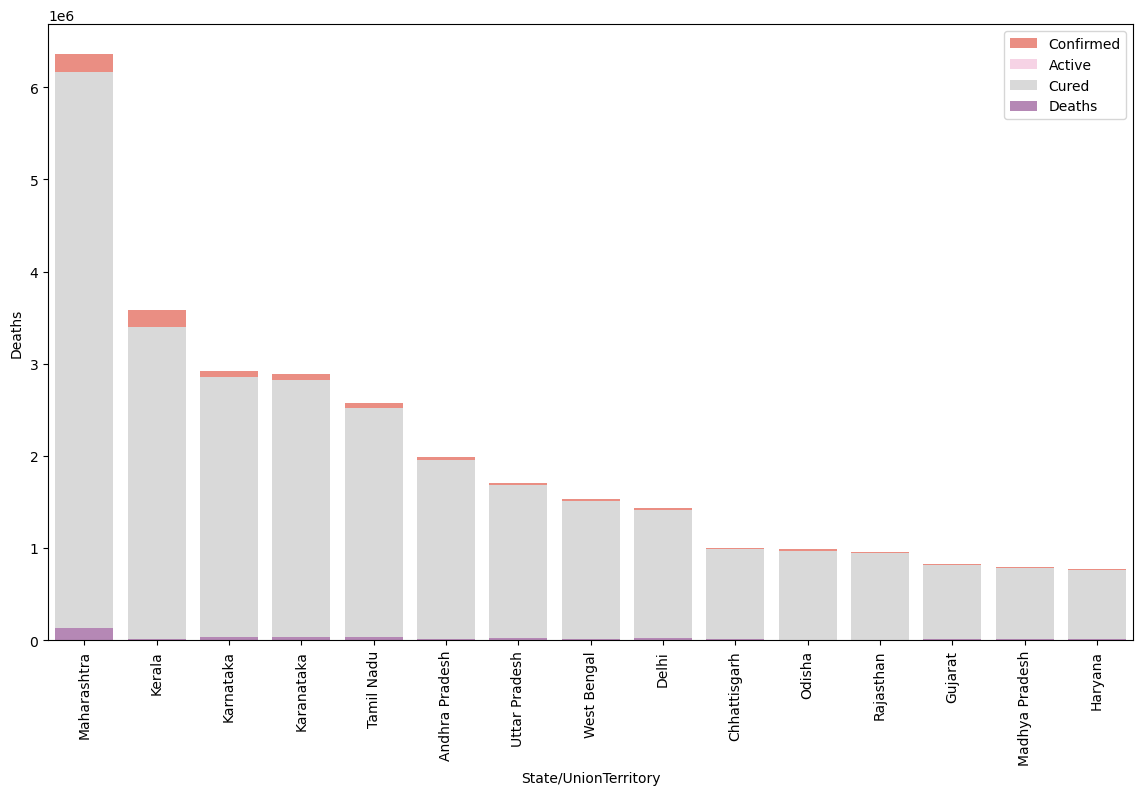

In [78]:
state_cases=state_cases.sort_values('Confirmed', ascending= False).fillna(0)
state_cases=state_cases.head(15)
state_cases
plt.figure(figsize=(14,8))
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Confirmed',color=sns.color_palette('Set3')[3],label='Confirmed')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Active',color=sns.color_palette('Set3')[7],label='Active')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Cured',color=sns.color_palette('Set3')[8],label='Cured')
sns.barplot(data=state_cases,x='State/UnionTerritory',y='Deaths',color=sns.color_palette('Set3')[9],label='Deaths')
plt.xticks(rotation=90)
plt.legend();

This code snippet appears to be visualizing the state_cases DataFrame using a bar chart that shows the number of confirmed cases, active cases, cured cases, and deaths in each of the top 15 states with the highest number of confirmed cases. Here's a breakdown of what each line does:

    state_cases=state_cases.sort_values('Confirmed', ascending= False).fillna(0) - This line sorts the state_cases DataFrame by the Confirmed column in descending order (i.e., from highest to lowest) using the sort_values() method, and assigns the sorted DataFrame back to state_cases. The fillna(0) method is used to replace any missing values in the DataFrame with zero, so that the chart can be plotted without errors.
    state_cases=state_cases.head(15) - This line selects the top 15 rows of the sorted state_cases DataFrame and assigns them back to state_cases. This ensures that only the states with the highest number of confirmed cases are shown in the chart.
    plt.figure(figsize=(14,8)) - This line creates a new figure with a size of 14 inches by 8 inches using the figure() function from the matplotlib.pyplot library. The resulting figure will be used to plot the bar chart.
    sns.barplot(data=state_cases,x='State/UnionTerritory',y='Confirmed',color=sns.color_palette('Set3')[3],label='Confirmed') - This line creates a bar plot using the barplot() function from the seaborn library. The plot shows the number of confirmed cases in each state, with the state names on the x-axis and the number of cases on the y-axis. The color parameter is used to set the color of the bars to the 4th color in the 'Set3' color palette, and the label parameter is used to set the label of the bar to 'Confirmed'.
    sns.barplot(data=state_cases,x='State/UnionTerritory',y='Active',color=sns.color_palette('Set3')[7],label='Active') - This line creates a second bar plot on top of the first one, showing the number of active cases in each state. The color parameter is set to the 8th color in the 'Set3' color palette, and the label parameter is set to 'Active'. Since this is the second plot on the same axis, it will be plotted on top of the first one.
    sns.barplot(data=state_cases,x='State/UnionTerritory',y='Cured',color=sns.color_palette('Set3')[8],label='Cured') - This line creates a third bar plot on top of the previous ones, showing the number of cured cases in each state. The color parameter is set to the 9th color in the 'Set3' color palette, and the label parameter is set to 'Cured'. Since this is the third plot on the same axis, it will be plotted on top of the previous ones.
    sns.barplot(data=state_cases,x='State/UnionTerritory',y='Deaths',color=sns.color_palette('Set3')[9],label='Deaths') - This line creates a fourth bar plot on top of the previous ones, showing the number of deaths in each state. The color parameter is set to the 10th color in the 'Set3' color palette, and the label parameter is set to 'Deaths'. Since this is the fourth plot on the same axis, it will be plotted on top of the previous

In [79]:
Con_date=df.groupby(['Confirmed'])['Date'].max().reset_index()
Con_date

Confirmed       Date
0              0 2021-01-18
1              1 2020-06-03
2              2 2020-06-11
3              3 2020-06-06
4              4 2020-06-03
...          ...        ...
14966    6341759 2021-08-07
14967    6347820 2021-08-08
14968    6353328 2021-08-09
14969    6357833 2021-08-10
14970    6363442 2021-08-11

[14971 rows x 2 columns]

This code snippet groups the df DataFrame by the Confirmed column and finds the maximum date for each group, then creates a new DataFrame called Con_date with the resulting data. Here's a breakdown of what each line does:

    Con_date=df.groupby(['Confirmed'])['Date'].max().reset_index() - This line groups the df DataFrame by the Confirmed column using the groupby() method, and finds the maximum date for each group using the max() method on the Date column. The resulting DataFrame has two columns: Confirmed and Date. The reset_index() method is then called to convert the groupby result to a DataFrame with a new index, which includes the Confirmed column and the maximum Date for each group. The resulting DataFrame is assigned to a new variable called Con_date.

Overall, this code snippet seems to be useful for finding the latest date on which each confirmed case count was reported in the dataset.

In [80]:
df.State.value_counts().sort_values() 

Telangana                                    101
Dadra and Nagar Haveli and Daman and Diu     153
Lakshadweep                                  195
Ladakh                                       294
Sikkim                                       394
Manipur                                      406
Meghalaya                                    409
Tripura                                      447
Nagaland                                     447
Andaman and Nicobar Islands                  453
Mizoram                                      465
Assam                                        469
Arunachal Pradesh                            477
Puducherry                                   478
Chandigarh                                   479
Chhattisgarh                                 482
Goa                                          483
Jharkhand                                    484
Himachal Pradesh                             487
Gujarat                                      487
Andhra Pradesh      

In [81]:
df_Haryana = df[df.State=='Haryana']
df_Haryana
df_Kerala = df[df.State=='Kerala']
df_Kerala
df_WestBengal = df[df.State=='West Bengal']
df_WestBengal
df_Maharashtra = df[df.State=='Maharashtra']
df_Maharashtra.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed        State  \
666 2020-04-05          Maharashtra     42      24        490  Maharashtra   
697 2020-04-06          Maharashtra     56      45        748  Maharashtra   
727 2020-04-07          Maharashtra     56      48        868  Maharashtra   
789 2020-04-09          Maharashtra    117      72       1135  Maharashtra   
820 2020-04-10          Maharashtra    125      97       1364  Maharashtra   

     TotalSamples Negative  Positive  Day  Month  Year  
666         16008    14837       0.0    5      4  2020  
697         17563    15808     868.0    6      4  2020  
727         20877    19290    1018.0    7      4  2020  
789         20877    19290     868.0    9      4  2020  
820         30000    28865    1135.0   10      4  2020

<AxesSubplot:title={'center':'Haryana dataset'}>

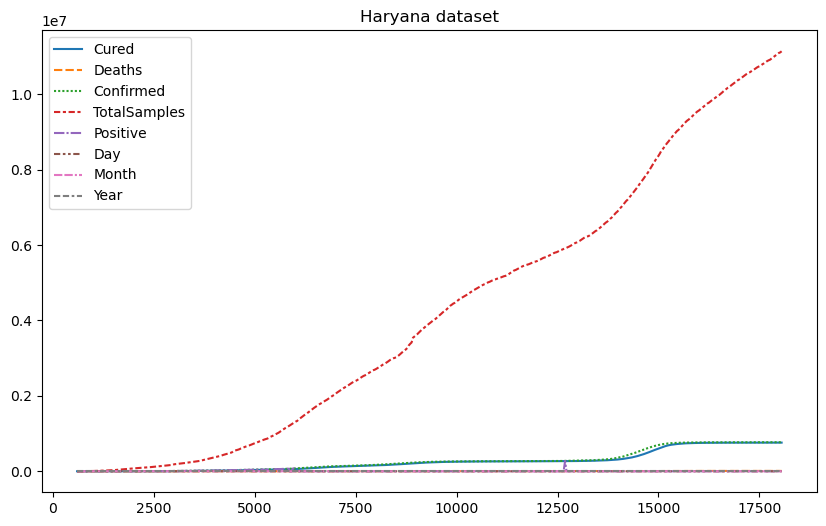

In [82]:
plt.figure(figsize=(10,6))

plt.title("Haryana dataset") 
sns.lineplot(data=df_Haryana)

<AxesSubplot:title={'center':'Maharashtra dataset'}>

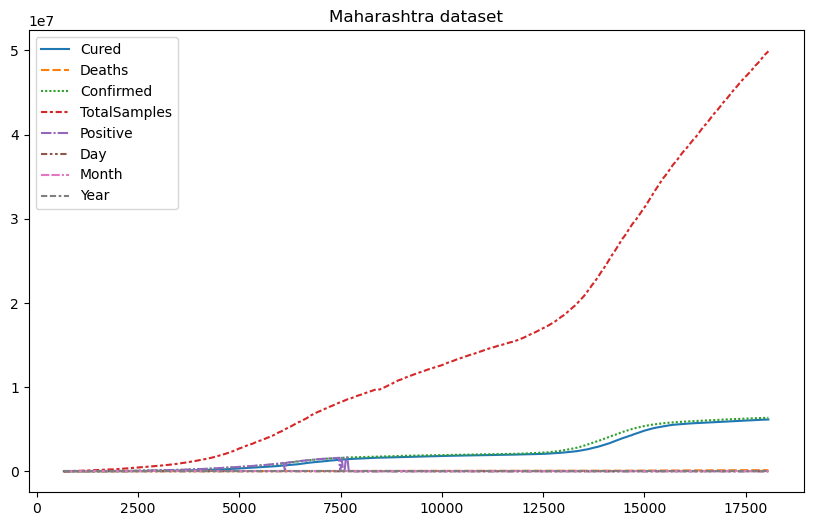

In [83]:
plt.figure(figsize=(10,6))

plt.title("Maharashtra dataset")
sns.lineplot(data=df_Maharashtra)

In [84]:
df_by_State = df.groupby('State')[['TotalSamples']].sum().reset_index()
df_by_State

State  TotalSamples
0                                          0  0.000000e+00
1                Andaman and Nicobar Islands  8.747008e+07
2                             Andhra Pradesh  4.967773e+09
3                          Arunachal Pradesh  1.636096e+08
4                                      Assam  2.853509e+09
5                                      Bihar  7.392796e+09
6                                 Chandigarh  9.974705e+07
7                               Chhattisgarh  1.863129e+09
8   Dadra and Nagar Haveli and Daman and Diu  6.291450e+06
9                                      Delhi  4.310596e+09
10                                       Goa  1.979067e+08
11                                   Gujarat  4.623914e+09
12                                   Haryana  2.056736e+09
13                          Himachal Pradesh  4.244486e+08
14                         Jammu and Kashmir  1.960284e+09
15                                 Jharkhand  2.053512e+09
16                                 Karnataka  6.736115e+09
17                                    Kerala  4.269006e+09
18                                    Ladakh  4.213546e+07
19                               Lakshadweep  2.001715e+07
20                            Madhya Pradesh  2.298458e+09
21                               Maharashtra  7.334574e+09
22                                   Manipur  1.855130e+08
23                                 Meghalaya  1.251595e+08
24                                   Mizoram  8.460259e+07
25                                  Nagaland  5.181064e+07
26                                    Odisha  2.965651e+09
27                                Puducherry  2.383986e+08
28                                    Punjab  2.026576e+09
29                                 Rajasthan  2.520540e+09
30                                    Sikkim  2.978195e+07
31                                Tamil Nadu  6.711189e+09
32                                 Telangana  1.789588e+09
33                                   Tripura  2.467333e+08
34                             Uttar Pradesh  1.138818e+10
35                               Uttarakhand  9.792698e+08
36                               West Bengal  3.051636e+09

This code snippet groups the df DataFrame by the State column and calculates the sum of TotalSamples for each group, then creates a new DataFrame called df_by_State with the resulting data. Here's a breakdown of what each line does:

    df_by_State = df.groupby('State')[['TotalSamples']].sum().reset_index() - This line groups the df DataFrame by the State column using the groupby() method, and calculates the sum of TotalSamples for each group using the sum() method on the TotalSamples column. The resulting DataFrame has two columns: State and TotalSamples. The reset_index() method is then called to convert the groupby result to a DataFrame with a new index, which includes the State column and the sum of TotalSamples for each group. The resulting DataFrame is assigned to a new variable called df_by_State.

Overall, this code snippet seems to be useful for getting the total number of samples tested in each state.

Text(0, 0.5, 'TotalSamples')

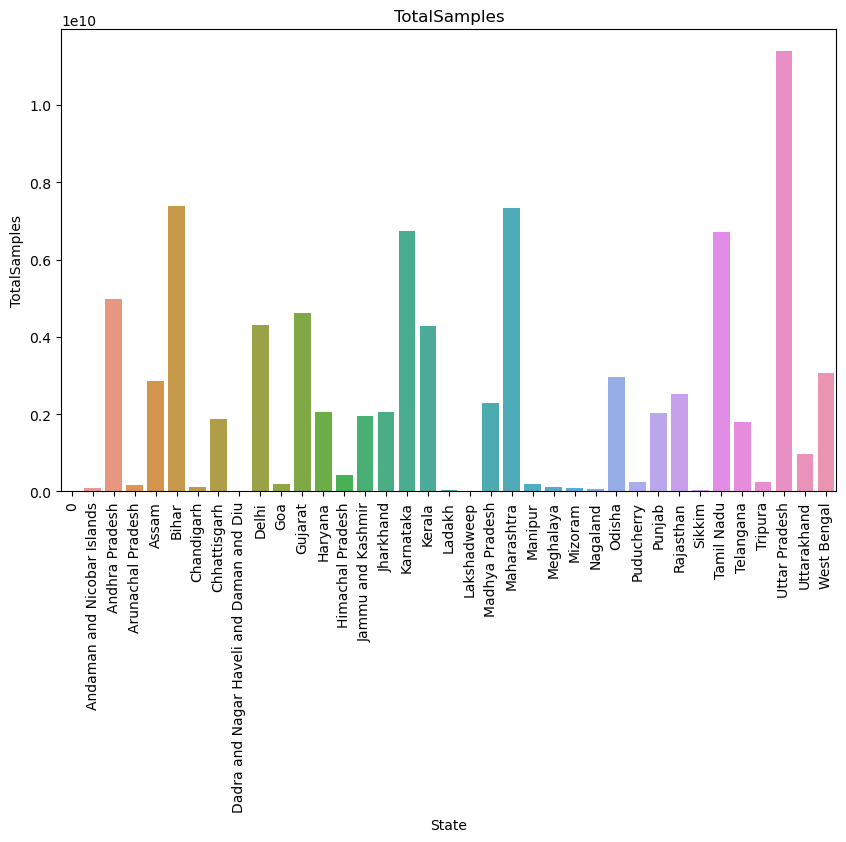

In [85]:
plt.figure(figsize=(10,6))

plt.title("TotalSamples")
sns.barplot(x=df_by_State["State"], y=df_by_State['TotalSamples'])
plt.xticks(rotation=90)

plt.ylabel("TotalSamples")

This code snippet creates a bar plot using Seaborn to visualize the TotalSamples data by state in the df_by_State DataFrame. Here's a breakdown of what each line does:

    plt.figure(figsize=(10,6)) - This line creates a new figure with a size of 10x6 inches using pyplot.figure() from the matplotlib library.

    plt.title("TotalSamples") - This line adds a title to the plot with the string "TotalSamples" using pyplot.title().

    sns.barplot(x=df_by_State["State"], y=df_by_State['TotalSamples']) - This line creates a bar plot using Seaborn's barplot() function. The x-axis is set to the State column in the df_by_State DataFrame, and the y-axis is set to the TotalSamples column.

    plt.xticks(rotation=90) - This line rotates the x-axis tick labels by 90 degrees using pyplot.xticks() from the matplotlib library.

    plt.ylabel("TotalSamples") - This line adds a label to the y-axis with the string "TotalSamples" using pyplot.ylabel().

Overall, this code snippet is useful for creating a visualization of the total number of samples tested in each state. The resulting plot can help us to identify which states have conducted more tests than others.

### Uttar Pradesh has the highest TotalSample collection


In [86]:
CovidCases=df.groupby("Date")[["Cured","Deaths","Confirmed"]].sum().reset_index()

This code snippet groups the df DataFrame by the Date column and calculates the sum of Cured, Deaths, and Confirmed for each date, then creates a new DataFrame called CovidCases with the resulting data. Here's a breakdown of what each line does:

    CovidCases=df.groupby("Date")[["Cured","Deaths","Confirmed"]].sum().reset_index() - This line groups the df DataFrame by the Date column using the groupby() method, and calculates the sum of Cured, Deaths, and Confirmed for each group using the sum() method on the corresponding columns. The resulting DataFrame has four columns: Date, Cured, Deaths, and Confirmed. The reset_index() method is then called to convert the groupby result to a DataFrame with a new index, which includes the Date column and the sum of Cured, Deaths, and Confirmed for each group. The resulting DataFrame is assigned to a new variable called CovidCases.

Overall, this code snippet seems to be useful for getting the total number of confirmed cases, deaths, and recoveries for each day.

In [87]:
CovidCases

Date     Cured  Deaths  Confirmed
0   2020-01-30         0       0          1
1   2020-01-31         0       0          1
2   2020-02-01         0       0          2
3   2020-02-02         0       0          3
4   2020-02-03         0       0          3
..         ...       ...     ...        ...
555 2021-08-07  31055861  427371   31895385
556 2021-08-08  31099771  427862   31934455
557 2021-08-09  31139457  428309   31969954
558 2021-08-10  31180968  428682   31998158
559 2021-08-11  31220981  429179   32036511

[560 rows x 4 columns]

In [88]:
fig=px.line(CovidCases,x='Date',y=CovidCases.columns[1:4],)
fig.update_layout(
    title="Total Confirmed cases VS Total Cured Cases VS Total Deaths",
    xaxis_title="Time Period",
    yaxis_title="Cases",
    legend_title="Cases",
    font=dict(
        size=14
    )
)
fig.layout.template = 'presentation'
fig.show()

This code snippet uses the plotly.express library to create a line plot of the CovidCases DataFrame, showing the total number of confirmed cases, deaths, and recoveries for each day. Here's a breakdown of what each line does:

    fig=px.line(CovidCases,x='Date',y=CovidCases.columns[1:4]) - This line creates a new figure using Plotly Express's line() function. The CovidCases DataFrame is passed as the first argument, and the x parameter is set to the Date column. The y parameter is set to a slice of the CovidCases.columns attribute, which includes the columns from index 1 to 4 (excluding index 4), representing the Cured, Deaths, and Confirmed columns.

    fig.update_layout() - This line updates the layout of the figure using the update_layout() method. The title parameter is set to the string "Total Confirmed cases VS Total Cured Cases VS Total Deaths". The xaxis_title parameter is set to the string "Time Period", and the yaxis_title parameter is set to the string "Cases". The legend_title parameter is set to the string "Cases". Finally, the font parameter is set to a dictionary with a size key of value 14.

    fig.layout.template = 'presentation' - This line sets the template of the figure to "presentation" using the layout.template attribute.

    fig.show() - This line displays the figure.

Overall, this code snippet is useful for creating an interactive visualization of the total number of confirmed cases, deaths, and recoveries over time. The resulting plot can help us to identify the trends and patterns in the spread of the COVID-19 virus.

In [89]:
df_by_Deaths = df.groupby('State')[['Deaths']].sum().reset_index()
df_by_Deaths

State    Deaths
0                                          0   1082659
1                Andaman and Nicobar Islands     26878
2                             Andhra Pradesh   2925738
3                          Arunachal Pradesh     26521
4                                      Assam    632837
5                                      Bihar   1102659
6                                 Chandigarh    143537
7                               Chhattisgarh   2050376
8   Dadra and Nagar Haveli and Daman and Diu       184
9                                      Delhi   4918053
10                                       Goa    444637
11                                   Gujarat   2200496
12                                   Haryana   1493145
13                          Himachal Pradesh    487794
14                         Jammu and Kashmir    835276
15                                 Jharkhand    742441
16                                 Karnataka   6015253
17                                    Kerala   1870170
18                                    Ladakh     28419
19                               Lakshadweep      3857
20                            Madhya Pradesh   1777702
21                               Maharashtra  23587673
22                                   Manipur    162707
23                                 Meghalaya     94545
24                                   Mizoram      9152
25                                  Nagaland     57668
26                                    Odisha    784249
27                                Puducherry    309685
28                                    Punjab   2769226
29                                 Rajasthan   1464135
30                                    Sikkim     46888
31                                Tamil Nadu   5882268
32                                 Telangana    345817
33                                   Tripura    140172
34                             Uttar Pradesh   4118843
35                               Uttarakhand    978633
36                               West Bengal   3828714

<function matplotlib.pyplot.show(close=None, block=None)>

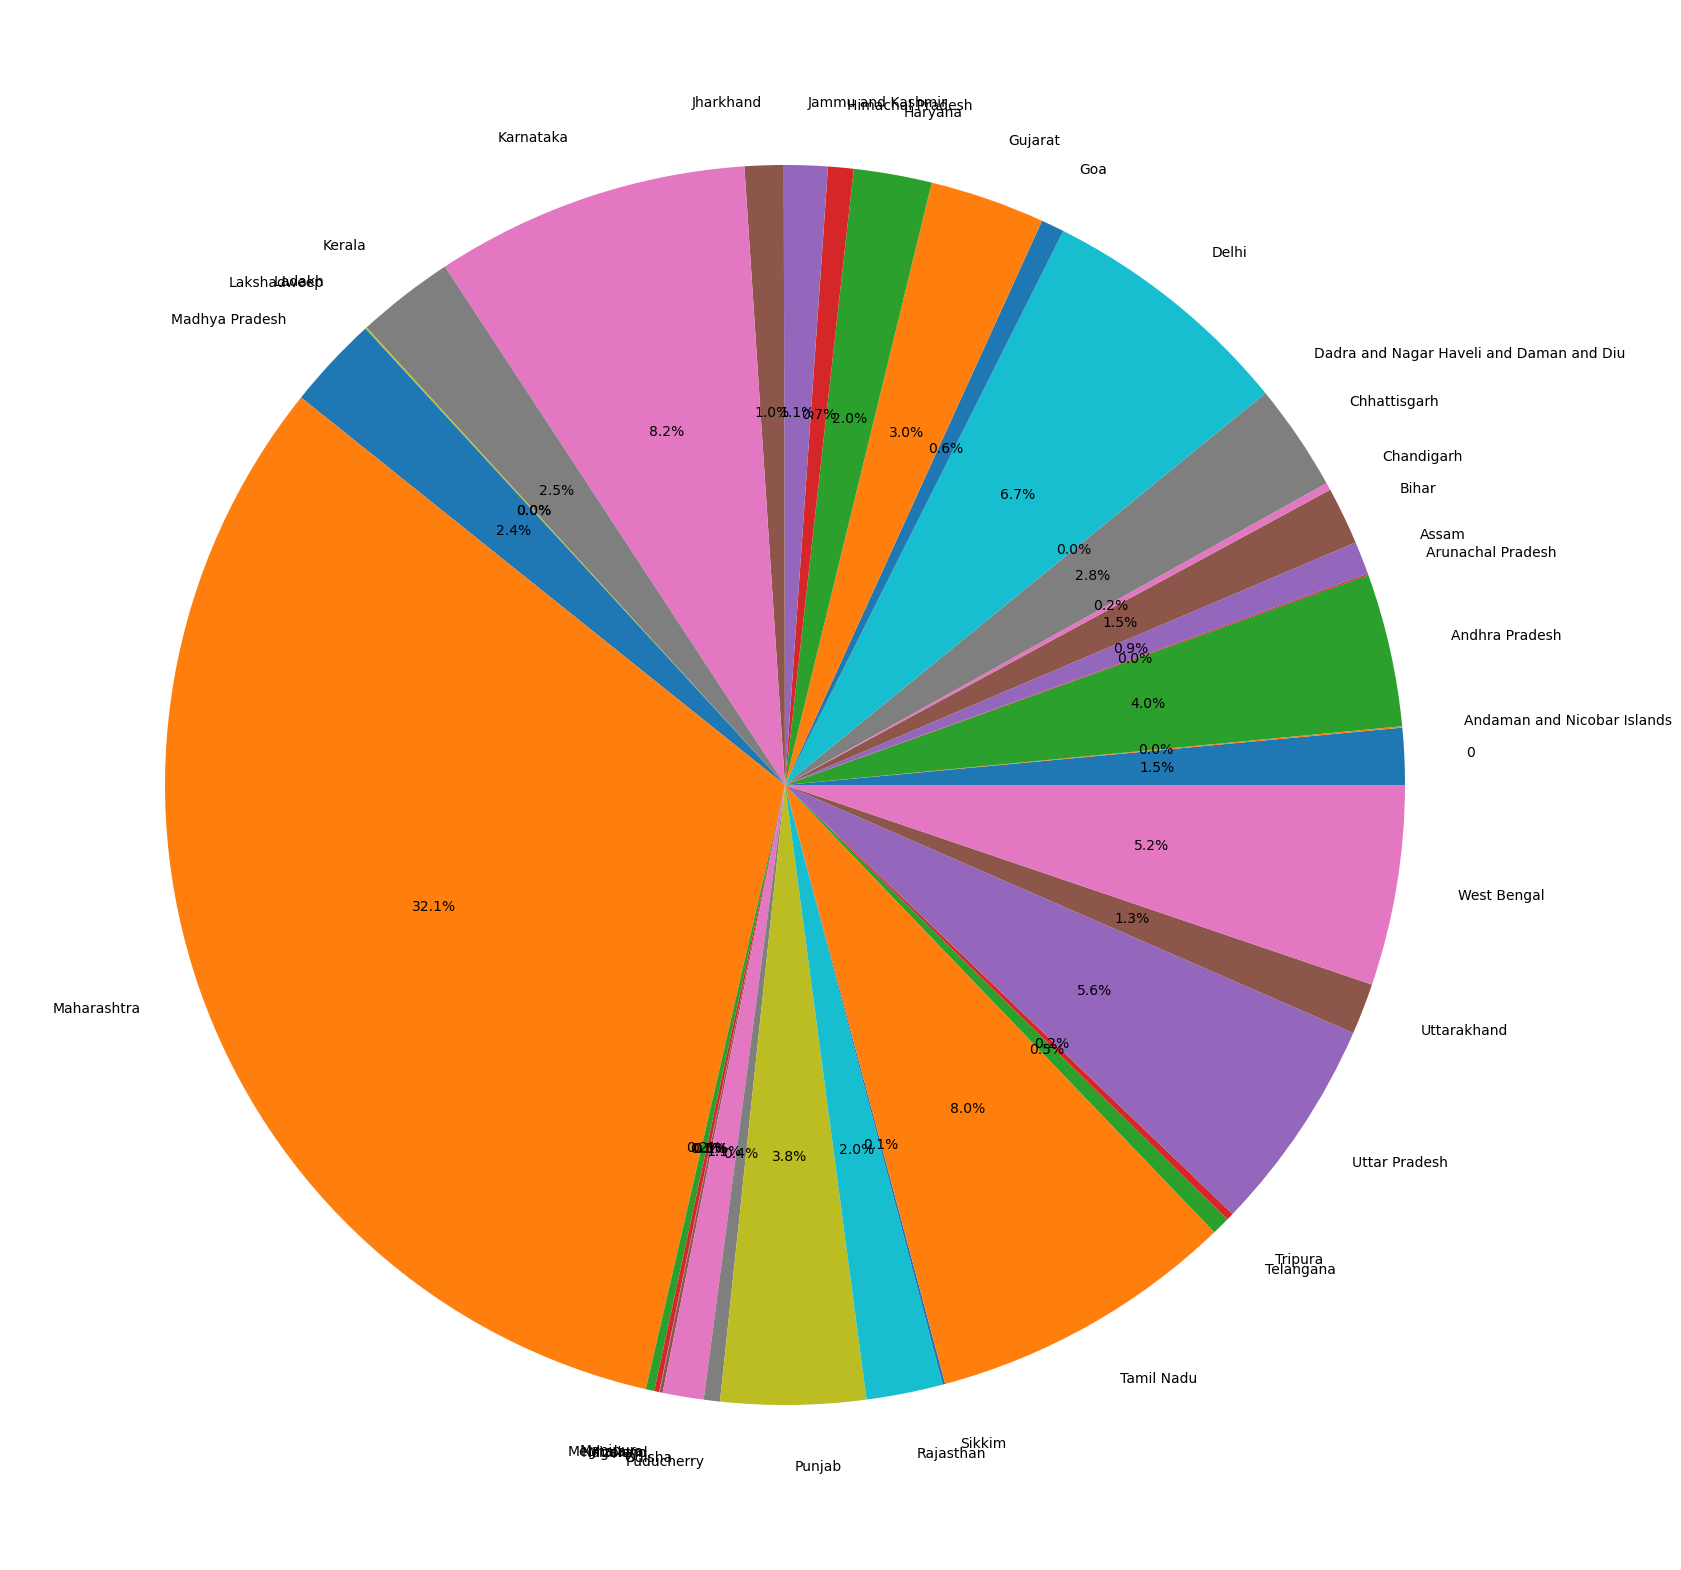

In [90]:
plt.figure(figsize=(20,30))
plt.pie(df_by_Deaths["Deaths"],labels=df_by_Deaths["State"],autopct="%1.1f%%")
plt.show

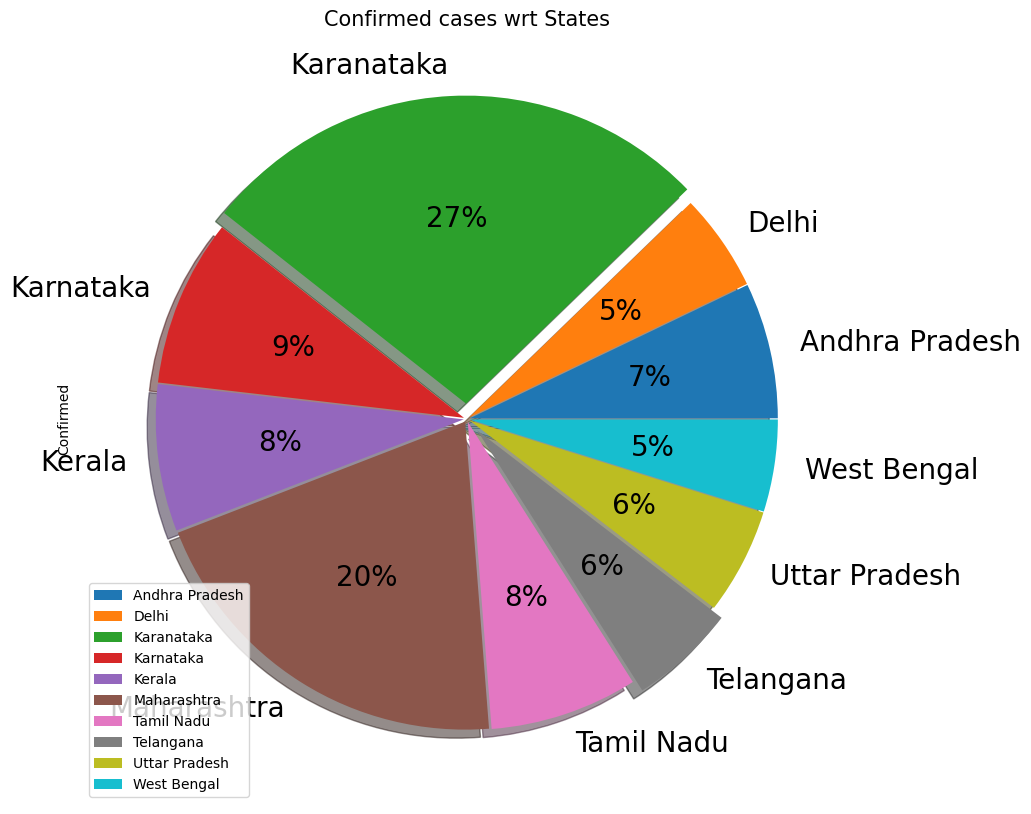

In [91]:
fig = plt.figure(figsize=(20,10))
df_t=df.groupby(['State/UnionTerritory']).agg({'Confirmed':np.mean})
df_t1=df_t.nlargest(10, ['Confirmed'])
df_t1.groupby(["State/UnionTerritory"]).sum()["Confirmed"].plot(kind='pie',rot=0,autopct='%1.0f%%', textprops={'fontsize': 20},explode=[0.01,0.01,0.05,0.01,0.01,0.01,0.01,0.05,0.01,0.01],shadow=True)
plt.title("Confirmed cases wrt States",fontsize=15)
plt.legend()

This code snippet creates a pie chart using matplotlib.pyplot library to show the percentage of confirmed cases in the top 10 States/Union Territories of India. Here's a breakdown of what each line does:

    fig = plt.figure(figsize=(20,10)) - This line creates a new figure with the given size.

    df_t=df.groupby(['State/UnionTerritory']).agg({'Confirmed':np.mean}) - This line groups the df DataFrame by State/UnionTerritory column and calculates the mean of the Confirmed cases.

    df_t1=df_t.nlargest(10, ['Confirmed']) - This line selects the top 10 States/Union Territories with the highest mean of Confirmed cases.

    df_t1.groupby(["State/UnionTerritory"]).sum()["Confirmed"].plot(kind='pie',rot=0,autopct='%1.0f%%', textprops={'fontsize': 20},explode=[0.01,0.01,0.05,0.01,0.01,0.01,0.01,0.05,0.01,0.01],shadow=True) - This line creates a pie chart from the df_t1 DataFrame using the plot() function. The kind parameter is set to 'pie', the rot parameter is set to 0 degrees, the autopct parameter is set to '%1.0f%%' to show the percentage values on the pie chart, the textprops parameter is set to a dictionary with a fontsize key of value 20 to set the font size of the percentage values, the explode parameter is set to a list of values to explode the slices, and the shadow parameter is set to True to add shadows to the pie chart.

    plt.title("Confirmed cases wrt States",fontsize=15) - This line sets the title of the plot with the given font size.

    plt.legend() - This line adds a legend to the plot.

Overall, this code snippet is useful for visualizing the distribution of confirmed cases in the top 10 States/Union Territories of India. The resulting pie chart can help us to quickly compare the relative proportions of confirmed cases across different regions.

In [92]:
df.corr()

Cured    Deaths  Confirmed  TotalSamples  Positive       Day  \
Cured         1.000000  0.917530   0.997751      0.773349  0.050717 -0.006430   
Deaths        0.917530  1.000000   0.918346      0.639107  0.107352 -0.004573   
Confirmed     0.997751  0.918346   1.000000      0.768729  0.068165 -0.006011   
TotalSamples  0.773349  0.639107   0.768729      1.000000  0.006701 -0.008039   
Positive      0.050717  0.107352   0.068165      0.006701  1.000000  0.002779   
Day          -0.006430 -0.004573  -0.006011     -0.008039  0.002779  1.000000   
Month        -0.010734  0.005362  -0.008689     -0.056651  0.080016 -0.020275   
Year          0.337683  0.242641   0.332217      0.424269 -0.058075 -0.050015   

                 Month      Year  
Cured        -0.010734  0.337683  
Deaths        0.005362  0.242641  
Confirmed    -0.008689  0.332217  
TotalSamples -0.056651  0.424269  
Positive      0.080016 -0.058075  
Day          -0.020275 -0.050015  
Month         1.000000 -0.580918  
Year         -0.580918  1.000000

Text(0.5, 1.0, 'Heatmap of Attributes to check the correlation')

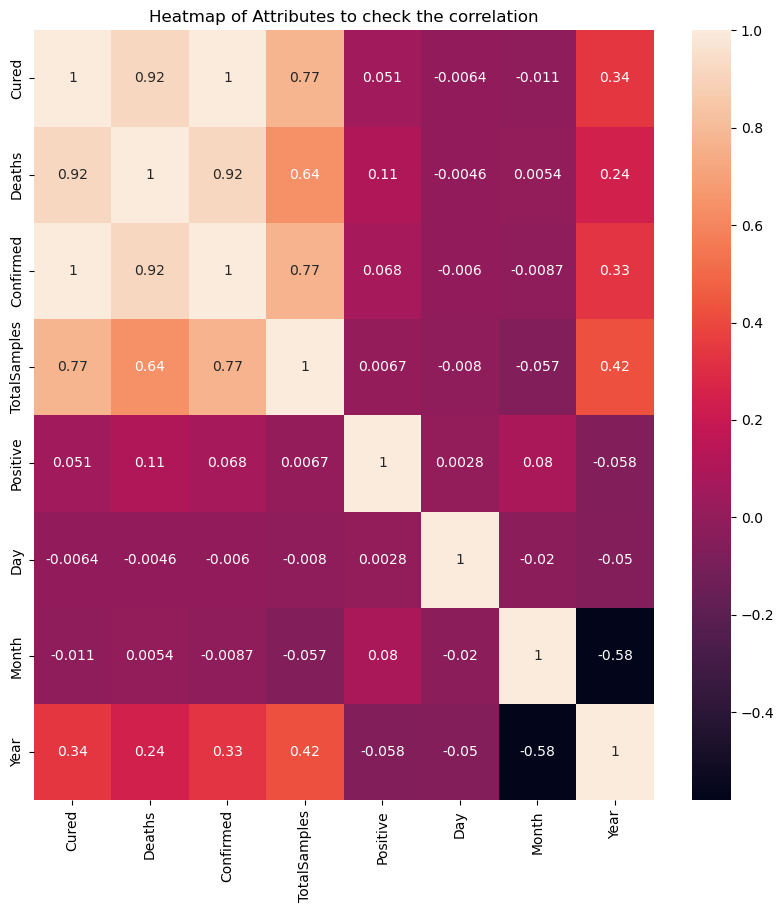

In [93]:
heatmap=df.iloc[:,:]

heatmap_corr=heatmap.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_corr,annot=True)
plt.title("Heatmap of Attributes to check the correlation")

The code I provided does the following steps:

    Creates a list of column names called num_cols which contains the names of all the numerical columns in the df dataframe. In this case, num_cols contains the column names "Confirmed", "Deaths", "Cured", and "TotalSamples".
    
    num_cols = ['Confirmed', 'Deaths', 'Cured', 'TotalSamples']
Selects only the columns in df that are present in the num_cols list and creates a new dataframe called heatmap.

heatmap = df[num_cols]
Calculates the correlation matrix of the heatmap dataframe and stores it in a variable called heatmap_corr.

heatmap_corr = heatmap.corr()
Creates a heatmap of the correlation matrix using Seaborn's heatmap() function. The annot=True parameter adds the correlation coefficients to the heatmap. The plt.title() function sets the title of the heatmap.

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_corr, annot=True)
plt.title("Heatmap of Attributes to check the correlation")


Certainly!

The code I provided does the following steps:

    Creates a list of column names called num_cols which contains the names of all the numerical columns in the df dataframe. In this case, num_cols contains the column names "Confirmed", "Deaths", "Cured", and "TotalSamples".

css

num_cols = ['Confirmed', 'Deaths', 'Cured', 'TotalSamples']

    Selects only the columns in df that are present in the num_cols list and creates a new dataframe called heatmap.

bash

heatmap = df[num_cols]

    Calculates the correlation matrix of the heatmap dataframe and stores it in a variable called heatmap_corr.

makefile

heatmap_corr = heatmap.corr()

    Creates a heatmap of the correlation matrix using Seaborn's heatmap() function. The annot=True parameter adds the correlation coefficients to the heatmap. The plt.title() function sets the title of the heatmap.



plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_corr, annot=True)
plt.title("Heatmap of Attributes to check the correlation")

The resulting heatmap shows the correlation coefficients between the numerical columns in the df dataframe. Darker colors indicate stronger positive or negative correlations, while lighter colors indicate weaker or no correlations. This can be useful for identifying which variables are strongly correlated, and which variables are not.

In [94]:
df_vacc.head()

Updated On  State  Total Doses Administered  Sessions   Sites   \
0 2021-01-16  India                   48276.0    3455.0   2957.0   
1 2021-01-17  India                   58604.0    8532.0   4954.0   
2 2021-01-18  India                   99449.0   13611.0   6583.0   
3 2021-01-19  India                  195525.0   17855.0   7951.0   
4 2021-01-20  India                  251280.0   25472.0  10504.0   

   First Dose Administered  Second Dose Administered  \
0                  48276.0                       0.0   
1                  58604.0                       0.0   
2                  99449.0                       0.0   
3                 195525.0                       0.0   
4                 251280.0                       0.0   

   Male (Doses Administered)  Female (Doses Administered)  \
0                        NaN                          NaN   
1                        NaN                          NaN   
2                        NaN                          NaN   
3                        NaN                          NaN   
4                        NaN                          NaN   

   Transgender (Doses Administered)  ...  18-44 Years (Doses Administered)  \
0                               NaN  ...                               NaN   
1                               NaN  ...                               NaN   
2                               NaN  ...                               NaN   
3                               NaN  ...                               NaN   
4                               NaN  ...                               NaN   

   45-60 Years (Doses Administered)  60+ Years (Doses Administered)  \
0                               NaN                             NaN   
1                               NaN                             NaN   
2                               NaN                             NaN   
3                               NaN                             NaN   
4                               NaN                             NaN   

   18-44 Years(Individuals Vaccinated)  45-60 Years(Individuals Vaccinated)  \
0                                  NaN                                  NaN   
1                                  NaN                                  NaN   
2                                  NaN                                  NaN   
3                                  NaN                                  NaN   
4                                  NaN                                  NaN   

   60+ Years(Individuals Vaccinated)  Male(Individuals Vaccinated)  \
0                                NaN                       23757.0   
1                                NaN                       27348.0   
2                                NaN                       41361.0   
3                                NaN                       81901.0   
4                                NaN                       98111.0   

   Female(Individuals Vaccinated)  Transgender(Individuals Vaccinated)  \
0                         24517.0                                  2.0   
1                         31252.0                                  4.0   
2                         58083.0                                  5.0   
3                        113613.0                                 11.0   
4                        153145.0                                 24.0   

   Total Individuals Vaccinated  
0                       48276.0  
1                       58604.0  
2                       99449.0  
3                      195525.0  
4                      251280.0  

[5 rows x 24 columns]

In [95]:
df_vacc.isna().sum()

Updated On                                0
State                                     0
Total Doses Administered                224
Sessions                                224
 Sites                                  224
First Dose Administered                 224
Second Dose Administered                224
Male (Doses Administered)               384
Female (Doses Administered)             384
Transgender (Doses Administered)        384
 Covaxin (Doses Administered)           224
CoviShield (Doses Administered)         224
Sputnik V (Doses Administered)         4850
AEFI                                   2407
18-44 Years (Doses Administered)       6143
45-60 Years (Doses Administered)       6143
60+ Years (Doses Administered)         6143
18-44 Years(Individuals Vaccinated)    4112
45-60 Years(Individuals Vaccinated)    4111
60+ Years(Individuals Vaccinated)      4111
Male(Individuals Vaccinated)           7685
Female(Individuals Vaccinated)         7685
Transgender(Individuals Vaccinat

In [96]:
df_vacc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7845 entries, 0 to 7844
Data columns (total 24 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Updated On                           7845 non-null   datetime64[ns]
 1   State                                7845 non-null   object        
 2   Total Doses Administered             7621 non-null   float64       
 3   Sessions                             7621 non-null   float64       
 4    Sites                               7621 non-null   float64       
 5   First Dose Administered              7621 non-null   float64       
 6   Second Dose Administered             7621 non-null   float64       
 7   Male (Doses Administered)            7461 non-null   float64       
 8   Female (Doses Administered)          7461 non-null   float64       
 9   Transgender (Doses Administered)     7461 non-null   float64       
 10   Covaxin (Do

In [97]:
df_vacc.describe()

Total Doses Administered      Sessions        Sites   \
count              7.621000e+03  7.621000e+03   7621.000000   
mean               9.188171e+06  4.792358e+05   2282.872064   
std                3.746180e+07  1.911511e+06   7275.973730   
min                7.000000e+00  0.000000e+00      0.000000   
25%                1.356570e+05  6.004000e+03     69.000000   
50%                8.182020e+05  4.547000e+04    597.000000   
75%                6.625243e+06  3.428690e+05   1708.000000   
max                5.132284e+08  3.501031e+07  73933.000000   

       First Dose Administered  Second Dose Administered  \
count             7.621000e+03              7.621000e+03   
mean              7.414415e+06              1.773755e+06   
std               2.995209e+07              7.570382e+06   
min               7.000000e+00              0.000000e+00   
25%               1.166320e+05              1.283100e+04   
50%               6.614590e+05              1.388180e+05   
75%               5.387805e+06              1.166434e+06   
max               4.001504e+08              1.130780e+08   

       Male (Doses Administered)  Female (Doses Administered)  \
count               7.461000e+03                 7.461000e+03   
mean                3.620156e+06                 3.168416e+06   
std                 1.737938e+07                 1.515310e+07   
min                 0.000000e+00                 2.000000e+00   
25%                 5.655500e+04                 5.210700e+04   
50%                 3.897850e+05                 3.342380e+05   
75%                 2.735777e+06                 2.561513e+06   
max                 2.701636e+08                 2.395186e+08   

       Transgender (Doses Administered)   Covaxin (Doses Administered)  \
count                       7461.000000                   7.621000e+03   
mean                        1162.978019                   1.044669e+06   
std                         5931.353995                   4.452259e+06   
min                            0.000000                   0.000000e+00   
25%                            8.000000                   0.000000e+00   
50%                          113.000000                   1.185100e+04   
75%                          800.000000                   7.579300e+05   
max                        98275.000000                   6.236742e+07   

       CoviShield (Doses Administered)  ...  18-44 Years (Doses Administered)  \
count                     7.621000e+03  ...                      1.702000e+03   
mean                      8.126553e+06  ...                      8.773958e+06   
std                       3.298414e+07  ...                      2.660829e+07   
min                       7.000000e+00  ...                      2.662400e+04   
25%                       1.331340e+05  ...                      4.344842e+05   
50%                       7.567360e+05  ...                      3.095970e+06   
75%                       6.007817e+06  ...                      7.366241e+06   
max                       4.468251e+08  ...                      2.243304e+08   

       45-60 Years (Doses Administered)  60+ Years (Doses Administered)  \
count                      1.702000e+03                    1.702000e+03   
mean                       7.442161e+06                    5.641605e+06   
std                        2.225999e+07                    1.681650e+07   
min                        1.681500e+04                    9.994000e+03   
25%                        2.326275e+05                    1.285605e+05   
50%                        2.695938e+06                    1.805696e+06   
75%                        6.969726e+06                    5.294763e+06   
max                        1.667575e+08                    1.186927e+08   

       18-44 Years(Individuals Vaccinated)  \
count                         3.733000e+03   
mean                          1.395895e+06   
std                           5.501454e+06   
min                           1.059000e+03   
25%      

In [98]:
df_vacc = df_vacc.drop(columns=['18-44 Years (Doses Administered)','45-60 Years (Doses Administered)','60+ Years (Doses Administered)','AEFI'],axis = 1)

In [99]:
df_vacc.fillna(0,inplace=True)
df_vacc.head()

Updated On  State  Total Doses Administered  Sessions   Sites   \
0 2021-01-16  India                   48276.0    3455.0   2957.0   
1 2021-01-17  India                   58604.0    8532.0   4954.0   
2 2021-01-18  India                   99449.0   13611.0   6583.0   
3 2021-01-19  India                  195525.0   17855.0   7951.0   
4 2021-01-20  India                  251280.0   25472.0  10504.0   

   First Dose Administered  Second Dose Administered  \
0                  48276.0                       0.0   
1                  58604.0                       0.0   
2                  99449.0                       0.0   
3                 195525.0                       0.0   
4                 251280.0                       0.0   

   Male (Doses Administered)  Female (Doses Administered)  \
0                        0.0                          0.0   
1                        0.0                          0.0   
2                        0.0                          0.0   
3                        0.0                          0.0   
4                        0.0                          0.0   

   Transgender (Doses Administered)   Covaxin (Doses Administered)  \
0                               0.0                          579.0   
1                               0.0                          635.0   
2                               0.0                         1299.0   
3                               0.0                         3017.0   
4                               0.0                         3946.0   

   CoviShield (Doses Administered)  Sputnik V (Doses Administered)  \
0                          47697.0                             0.0   
1                          57969.0                             0.0   
2                          98150.0                             0.0   
3                         192508.0                             0.0   
4                         247334.0                             0.0   

   18-44 Years(Individuals Vaccinated)  45-60 Years(Individuals Vaccinated)  \
0                                  0.0                                  0.0   
1                                  0.0                                  0.0   
2                                  0.0                                  0.0   
3                                  0.0                                  0.0   
4                                  0.0                                  0.0   

   60+ Years(Individuals Vaccinated)  Male(Individuals Vaccinated)  \
0                                0.0                       23757.0   
1                                0.0                       27348.0   
2                                0.0                       41361.0   
3                                0.0                       81901.0   
4                                0.0                       98111.0   

   Female(Individuals Vaccinated)  Transgender(Individuals Vaccinated)  \
0                         24517.0                                  2.0   
1                         31252.0                                  4.0   
2                         58083.0                                  5.0   
3                        113613.0                                 11.0   
4                        153145.0                                 24.0   

   Total Individuals Vaccinated  
0                       48276.0  
1                       58604.0  
2                       99449.0  
3                      195525.0  
4                      251280.0

<AxesSubplot:xlabel='Updated On', ylabel='Total Doses Administered'>

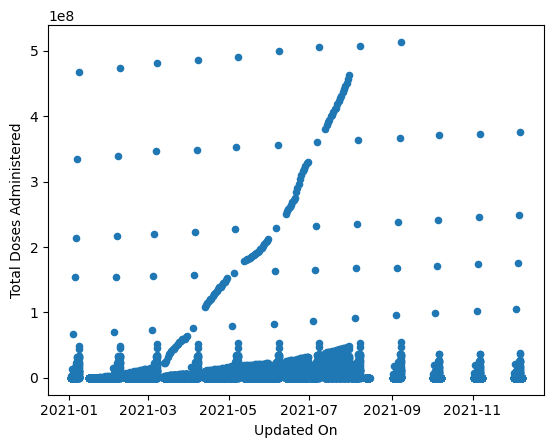

In [100]:
df_vacc.plot.scatter(x='Updated On',y='Total Doses Administered')

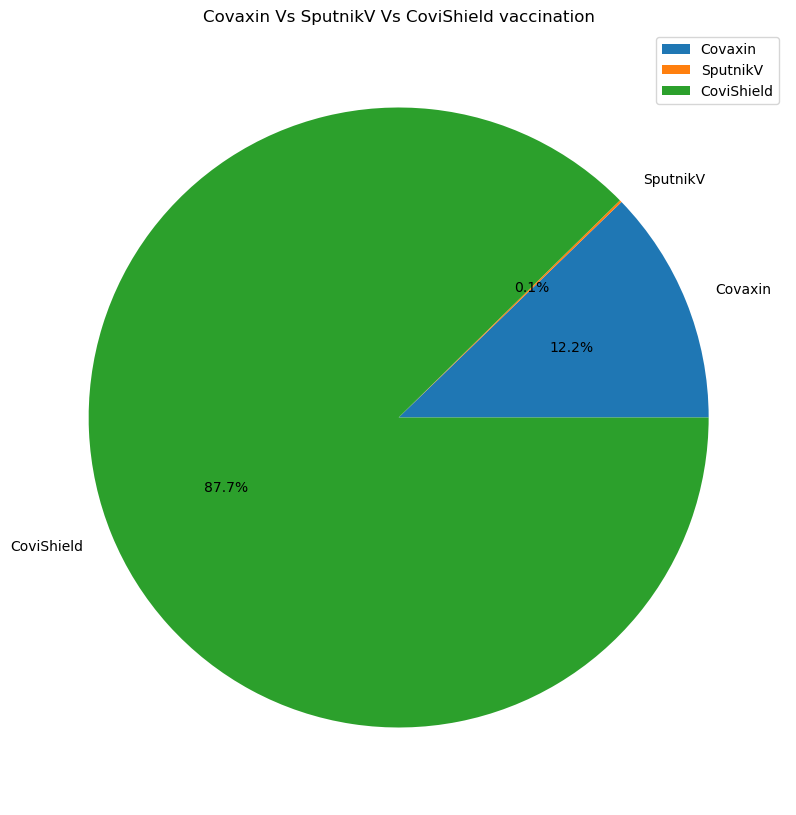

In [101]:
plt.figure(figsize=(10,20))
Covaxin = df_vacc[" Covaxin (Doses Administered)"].max()
SputnikV = df_vacc['Sputnik V (Doses Administered)'].max() 
CoviShield =df_vacc["CoviShield (Doses Administered)"].max()
x = np.array([Covaxin,SputnikV,CoviShield])
plt.pie(x,labels =  ['Covaxin','SputnikV','CoviShield'],autopct="%1.1f%%")
plt.title('Covaxin Vs SputnikV Vs CoviShield vaccination')
plt.legend()
plt.show()

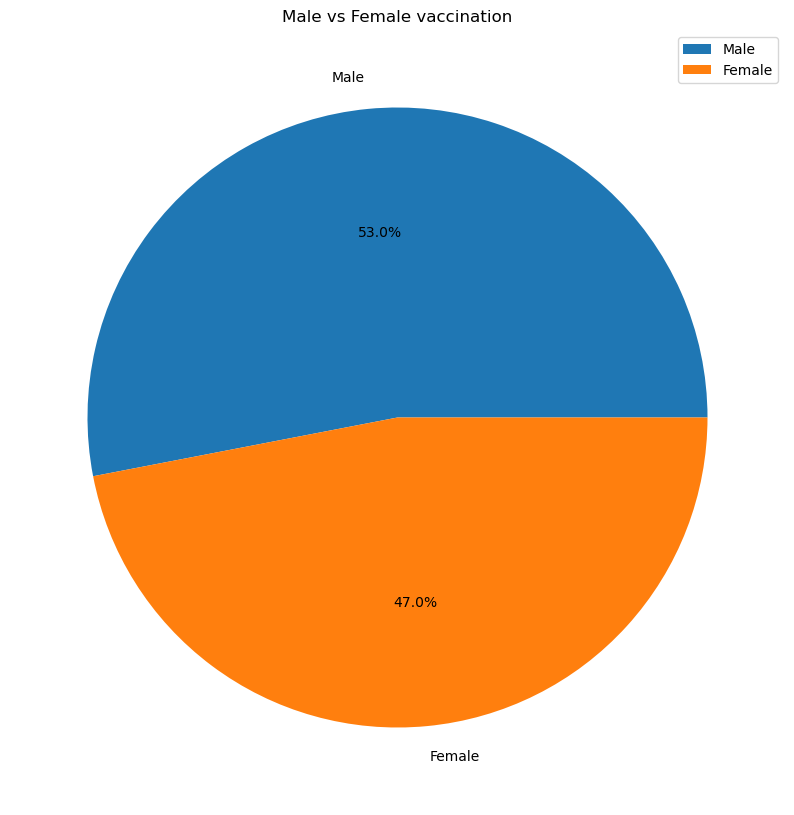

In [102]:
plt.figure(figsize=(10,20))
male = df_vacc['Male(Individuals Vaccinated)'].mean()
female = df_vacc['Female(Individuals Vaccinated)'].mean()
x = np.array([male,female])
plt.pie(x,labels =  ['Male','Female'],autopct="%1.1f%%")
plt.title('Male vs Female vaccination')
plt.legend()
plt.show()

The above code creates a pie chart to compare the average number of males and females who have been vaccinated. It first calculates the mean of the 'Male(Individuals Vaccinated)' and 'Female(Individuals Vaccinated)' columns from the 'df_vacc' dataframe, which contains vaccination data. It then creates a numpy array of these mean values and plots a pie chart using the 'plt.pie' function. The chart shows the percentage of males and females who have been vaccinated, with labels and percentages displayed. Finally, it adds a title to the chart and displays it using the 'plt.show' function.


    plt.figure(figsize=(10,20)): This sets the size of the figure to be 10 inches wide and 20 inches tall.
    
    male = df_vacc['Male(Individuals Vaccinated)'].mean(): This calculates the mean value of the 'Male(Individuals Vaccinated)' column from the 'df_vacc' dataframe and assigns it to the variable 'male'.
    
    female = df_vacc['Female(Individuals Vaccinated)'].mean(): This calculates the mean value of the 'Female(Individuals Vaccinated)' column from the 'df_vacc' dataframe and assigns it to the variable 'female'.
    
    x = np.array([male,female]): This creates a numpy array with the mean values of males and females calculated in step 2 and 3, respectively.
    
    plt.pie(x,labels = ['Male','Female'],autopct="%1.1f%%"): This plots a pie chart using the values in the numpy array 'x'. The 'labels' parameter specifies the labels to be used for each section of the pie chart, and the 'autopct' parameter specifies the format for displaying the percentage values.
    
    plt.title('Male vs Female vaccination'): This sets the title of the chart to 'Male vs Female vaccination'.
    
    plt.legend(): This displays the legend for the chart.
    
    plt.show(): This displays the chart on the screen.

In [103]:
df1_Odisha=df_vacc[df_vacc['State']=='Odisha']
df1_Maharashtra=df_vacc[df_vacc['State']=='Maharashtra']
df1_Delhi=df_vacc[df_vacc['State']=='Delhi']

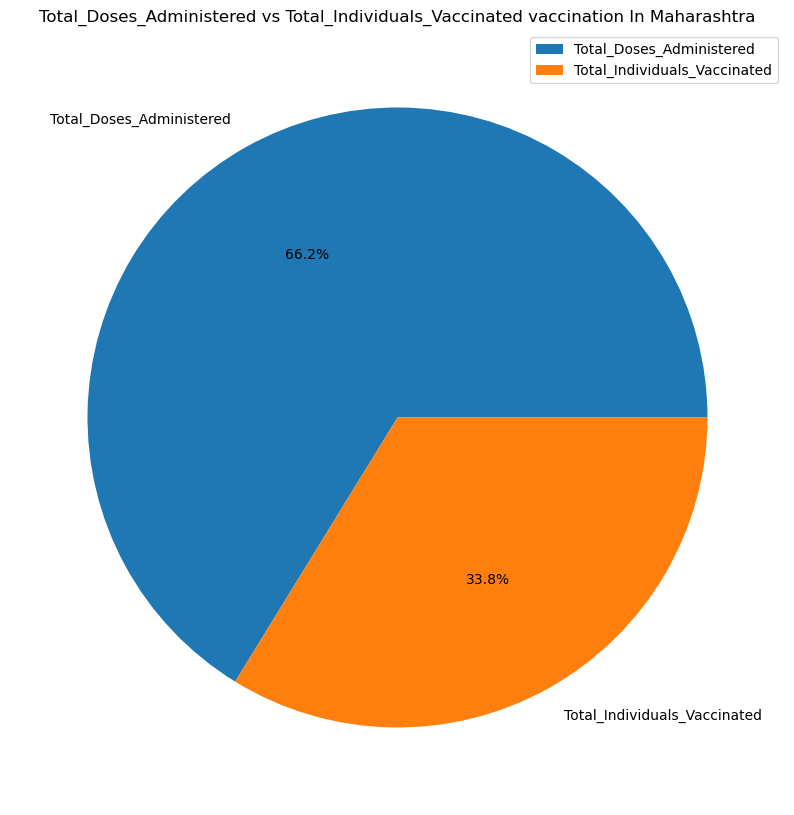

In [104]:
plt.figure(figsize=(10,20))
Total_Doses = df1_Maharashtra["Total Doses Administered"].max() 
Total_Individuals = df1_Maharashtra["Total Individuals Vaccinated"].max()
x = np.array([Total_Doses,Total_Individuals])
plt.pie(x,labels =  ['Total_Doses_Administered','Total_Individuals_Vaccinated'],autopct="%1.1f%%")
plt.title('Total_Doses_Administered vs Total_Individuals_Vaccinated vaccination In Maharashtra')
plt.legend()
plt.show()

In [105]:
df.head()

Date State/UnionTerritory  Cured  Deaths  Confirmed State  \
0 2020-01-30               Kerala      0       0          1     0   
1 2020-01-31               Kerala      0       0          1     0   
2 2020-02-01               Kerala      0       0          2     0   
3 2020-02-02               Kerala      0       0          3     0   
4 2020-02-03               Kerala      0       0          3     0   

   TotalSamples Negative  Positive  Day  Month  Year  
0             0        0       0.0   30      1  2020  
1             0        0       0.0   31      1  2020  
2             0        0       0.0    1      2  2020  
3             0        0       0.0    2      2  2020  
4             0        0       0.0    3      2  2020

In [106]:
df.describe()

Cured         Deaths     Confirmed  TotalSamples      Positive  \
count  1.811100e+04   18111.000000  1.811100e+04  1.811100e+04  1.811100e+04   
mean   2.786221e+05    4052.178621  3.010148e+05  4.757145e+06  1.745889e+04   
std    6.148774e+05   10918.816423  6.561346e+05  8.496938e+06  9.709808e+04   
min    0.000000e+00       0.000000  0.000000e+00  0.000000e+00  0.000000e+00   
25%    3.358500e+03      32.000000  4.376000e+03  6.240150e+04  0.000000e+00   
50%    3.335800e+04     588.000000  3.977000e+04  5.603400e+05  0.000000e+00   
75%    2.788595e+05    3643.500000  3.001465e+05  6.074854e+06  2.450000e+02   
max    6.159676e+06  134201.000000  6.363442e+06  6.789786e+07  1.638961e+06   

                Day         Month          Year  
count  18111.000000  18111.000000  18111.000000  
mean      15.679145      6.207443   2020.443267  
std        8.836388      3.060116      0.496785  
min        1.000000      1.000000   2020.000000  
25%        8.000000      4.000000   2020.000000  
50%       16.000000      6.000000   2020.000000  
75%       23.000000      8.000000   2021.000000  
max       31.000000     12.000000   2021.000000

In [107]:
a=df.groupby(["State"])["Confirmed"].describe()
a

count          mean           std  \
State                                                                          
0                                         2168.0  5.438372e+04  2.328850e+05   
Andaman and Nicobar Islands                453.0  4.243755e+03  2.359979e+03   
Andhra Pradesh                             488.0  8.000889e+05  6.049950e+05   
Arunachal Pradesh                          477.0  1.491243e+04  1.253161e+04   
Assam                                      469.0  2.115785e+05  1.583198e+05   
Bihar                                      489.0  2.718430e+05  2.397058e+05   
Chandigarh                                 479.0  2.207944e+04  2.145995e+04   
Chhattisgarh                               482.0  3.377016e+05  3.549294e+05   
Dadra and Nagar Haveli and Daman and Diu   153.0  1.365438e+03  1.220891e+03   
Delhi                                      489.0  5.844190e+05  4.912416e+05   
Goa                                        483.0  5.811171e+04  5.546183e+04   
Gujarat                                    487.0  2.917323e+05  2.802199e+05   
Haryana                                    492.0  2.714968e+05  2.628296e+05   
Himachal Pradesh                           487.0  6.124139e+04  6.971588e+04   
Jammu and Kashmir                          489.0  1.181880e+05  1.024314e+05   
Jharkhand                                  484.0  1.273679e+05  1.174558e+05   
Karnataka                                  490.0  9.856480e+05  9.289050e+05   
Kerala                                     497.0  9.161319e+05  1.033205e+06   
Ladakh                                     294.0  9.109374e+03  7.752859e+03   
Lakshadweep                                195.0  4.641251e+03  4.194129e+03   
Madhya Pradesh                             492.0  2.756589e+05  2.742867e+05   
Maharashtra                                488.0  2.286583e+06  2.073045e+06   
Manipur                                    406.0  2.885522e+04  2.571636e+04   
Meghalaya                                  409.0  1.634594e+04  1.829301e+04   
Mizoram                                    465.0  5.980985e+03  8.976508e+03   
Nagaland                                   447.0  1.115458e+04  8.020317e+03   
Odisha                                     492.0  3.234582e+05  2.942750e+05   
Puducherry                                 478.0  4.164021e+04  3.799460e+04   
Punjab                                     491.0  2.023410e+05  2.019218e+05   
Rajasthan                                  491.0  3.287457e+05  3.263501e+05   
Sikkim                                     394.0  7.302048e+03  7.538475e+03   
Tamil Nadu                                 491.0  8.744330e+05  7.691256e+05   
Telangana                                  101.0  5.932834e+05  5.335482e+04   
Tripura                                    447.0  2.944497e+04  2.191540e+04   
Uttar Pradesh                              490.0  6.343157e+05  5.836390e+05   
Uttarakhand                                491.0  1.075311e+05  1.163735e+05   
West Bengal                                493.0  5.305729e+05  4.934677e+05   

                                               min        25%        50%  \
State                                                                      
0                                              0.0      13.00     2441.5   
Andaman and Nicobar Islands                   11.0    3223.00     4912.0   
Andhra Pradesh                                86.0  225155.00   873148.0   
Arunachal Pradesh                              1.0    2701.00    16536.0   
Assam                                          5.0   90740.00   215250.0   
Bihar                                         30.0   75294.00   239322.0   
Chandigarh                                    16.0    1350.50    18027.0   
Chhattisgarh                                   9.0   14073.00   254945.0   
Dadra and Nagar Haveli and Daman and Diu       1.0      88.00     1145.0   
Delhi                                        152.0  144127.00   597112.0   
Goa       

C:\Users\sanke\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:ylabel='Density'>

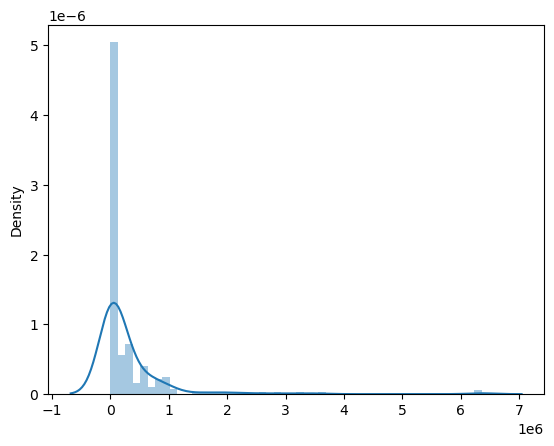

In [108]:
sns.distplot(a)

In [109]:
b=df.groupby(["State"])["Confirmed"].median()

In [110]:
b

State
0                                              2441.5
Andaman and Nicobar Islands                    4912.0
Andhra Pradesh                               873148.0
Arunachal Pradesh                             16536.0
Assam                                        215250.0
Bihar                                        239322.0
Chandigarh                                    18027.0
Chhattisgarh                                 254945.0
Dadra and Nagar Haveli and Daman and Diu       1145.0
Delhi                                        597112.0
Goa                                           49235.0
Gujarat                                      220168.0
Haryana                                      244592.0
Himachal Pradesh                              46201.0
Jammu and Kashmir                            114038.0
Jharkhand                                    110916.5
Karnataka                                    893505.0
Kerala                                       625767.0
Ladakh                